<center><h1>TP9: Improving a model!</h1></center>

# Warning :
# "File -> Save a copy in Drive" before starting to modify the notebook, otherwise changes won't be saved.

In [ ]:
! wget https://remysun.github.io/uploads/DSAI_ADL_TP9/utils.py

--2023-12-05 13:00:53--  https://remysun.github.io/uploads/DSAI_ADL_TP9/utils.py
Resolving remysun.github.io (remysun.github.io)... 185.199.109.153, 185.199.108.153, 185.199.111.153, ...
Connecting to remysun.github.io (remysun.github.io)|185.199.109.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2627 (2.6K) [application/octet-stream]
Saving to: ‘utils.py’

utils.py            100%[===================>]   2.57K  --.-KB/s    in 0s      

2023-12-05 13:00:53 (53.7 MB/s) - ‘utils.py’ saved [2627/2627]



In [ ]:
import argparse
import os
import time

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from utils import *

PRINT_INTERVAL = 200
PATH="datasets"

In [ ]:
class ConvNet(nn.Module):
    """
    Cette classe contient la structure du réseau de neurones
    """

    def __init__(self):
        super(ConvNet, self).__init__()
        # On défini d'abord les couches de convolution et de pooling comme un
        # groupe de couches `self.features`
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
        )
        # On défini les couches fully connected comme un groupe de couches
        # `self.classifier`
        self.classifier = nn.Sequential(
            nn.Linear(4*4*64, 1000),
            nn.ReLU(),
            nn.Linear(1000, 10),
            # Rappel : Le softmax est inclus dans la loss, ne pas le mettre ici
        )

    # méthode appelée quand on applique le réseau à un batch d'input
    def forward(self, input):
        bsize = input.size(0) # taille du batch
        output = self.features(input) # on calcule la sortie des conv
        output = output.view(bsize, -1) # on applati les feature map 2D en un
                                        # vecteur 1D pour chaque input
        output = self.classifier(output) # on calcule la sortie des fc
        return output



def get_dataset(batch_size, cuda=False):
    """
    Cette fonction charge le dataset et effectue des transformations sur chaqu
    image (listées dans `transform=...`).
    """
    train_dataset = datasets.CIFAR10(PATH, train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor()
        ]))
    val_dataset = datasets.CIFAR10(PATH, train=False, download=True,
        transform=transforms.Compose([
            transforms.ToTensor()
        ]))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader



def epoch(data, model, criterion, optimizer=None, cuda=False):
    """
    Fait une passe (appelée epoch en anglais) sur les données `data` avec le
    modèle `model`. Evalue `criterion` comme loss.
    Si `optimizer` est fourni, effectue une epoch d'apprentissage en utilisant
    l'optimiseur donné, sinon, effectue une epoch d'évaluation (pas de backward)
    du modèle.
    """

    # indique si le modele est en mode eval ou train (certaines couches se
    # comportent différemment en train et en eval)
    model.eval() if optimizer is None else model.train()

    # objets pour stocker les moyennes des metriques
    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()
    global loss_plot

    # on itere sur les batchs du dataset
    tic = time.time()
    for i, (input, target) in enumerate(data):

        if cuda: # si on fait du GPU, passage en CUDA
            input = input.cuda()
            target = target.cuda()

        # forward
        output = model(input)
        loss = criterion(output, target)

        # backward si on est en "train"
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # calcul des metriques
        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        # mise a jour des moyennes
        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)
        if optimizer:
            loss_plot.update(avg_loss.val)
        # affichage des infos
        if i % PRINT_INTERVAL == 0:
            print('[{0:s} Batch {1:03d}/{2:03d}]\t'
                  'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:5.1f} ({top1.avg:5.1f})\t'
                  'Prec@5 {top5.val:5.1f} ({top5.avg:5.1f})'.format(
                   "EVAL" if optimizer is None else "TRAIN", i, len(data), batch_time=avg_batch_time, loss=avg_loss,
                   top1=avg_top1_acc, top5=avg_top5_acc))
            if optimizer:
                loss_plot.plot()

    # Affichage des infos sur l'epoch
    print('\n===============> Total time {batch_time:d}s\t'
          'Avg loss {loss.avg:.4f}\t'
          'Avg Prec@1 {top1.avg:5.2f} %\t'
          'Avg Prec@5 {top5.avg:5.2f} %\n'.format(
           batch_time=int(avg_batch_time.sum), loss=avg_loss,
           top1=avg_top1_acc, top5=avg_top5_acc))

    return avg_top1_acc, avg_top5_acc, avg_loss


def main(batch_size=128, lr=0.1, epochs=5, cuda=False):

    # ex de params :
    #   {"batch_size": 128, "epochs": 5, "lr": 0.1}

    # define model, loss, optim
    model = ConvNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)

    if cuda: # si on fait du GPU, passage en CUDA
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # On récupère les données
    train, test = get_dataset(batch_size, cuda)

    # init plots
    plot = AccLossPlot()
    global loss_plot
    loss_plot = TrainLossPlot()

    # On itère sur les epochs
    for i in range(epochs):
        print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")
        # Phase de train
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        # Phase d'evaluation
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)
        # plot
        plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)


100%|██████████| 170498071/170498071 [00:04<00:00, 40177715.14it/s]


Extracting datasets/cifar-10-python.tar.gz to datasets
Files already downloaded and verified
=== EPOCH 1 =====

[TRAIN Batch 000/391]	Time 2.305s (2.305s)	Loss 2.3028 (2.3028)	Prec@1  14.8 ( 14.8)	Prec@5  48.4 ( 48.4)


<Figure size 640x480 with 0 Axes>

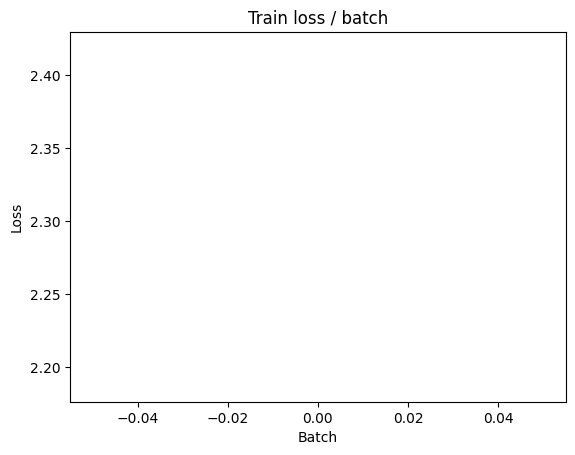

[TRAIN Batch 200/391]	Time 0.013s (0.032s)	Loss 2.1063 (2.2351)	Prec@1  20.3 ( 16.6)	Prec@5  78.1 ( 63.4)


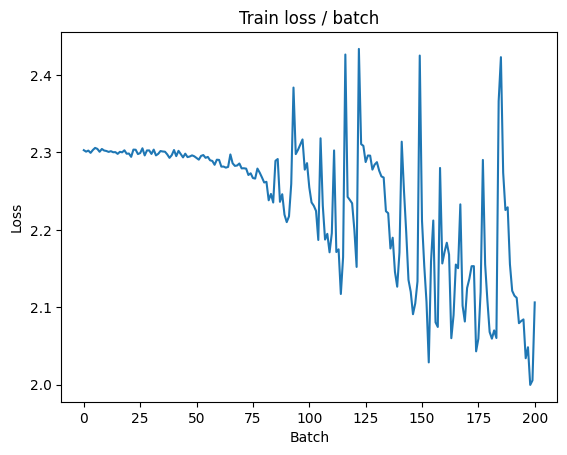


===============> Total time 10s	Avg loss 2.1123	Avg Prec@1 22.53 %	Avg Prec@5 71.06 %

[EVAL Batch 000/079]	Time 0.101s (0.101s)	Loss 1.8213 (1.8213)	Prec@1  31.2 ( 31.2)	Prec@5  85.2 ( 85.2)

===============> Total time 1s	Avg loss 1.7907	Avg Prec@1 33.96 %	Avg Prec@5 85.77 %



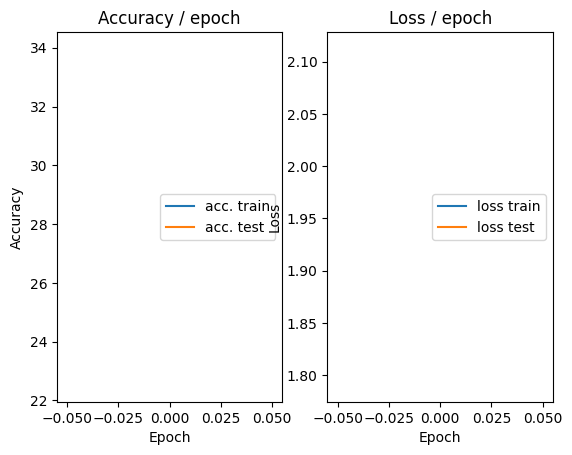

=== EPOCH 2 =====

[TRAIN Batch 000/391]	Time 0.187s (0.187s)	Loss 1.8326 (1.8326)	Prec@1  39.1 ( 39.1)	Prec@5  84.4 ( 84.4)


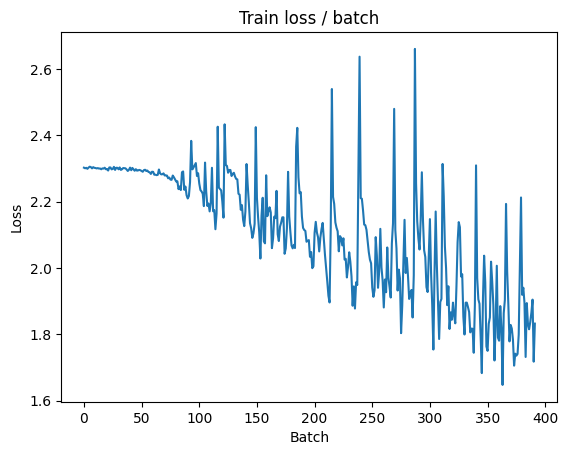

[TRAIN Batch 200/391]	Time 0.024s (0.029s)	Loss 1.5999 (1.7283)	Prec@1  39.8 ( 37.6)	Prec@5  89.1 ( 86.8)


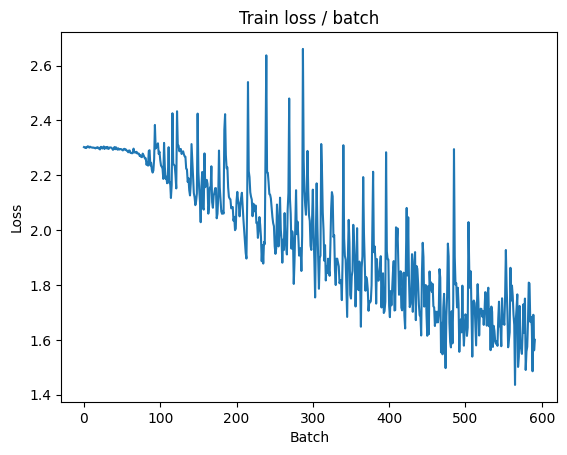


===============> Total time 9s	Avg loss 1.6504	Avg Prec@1 40.29 %	Avg Prec@5 88.58 %

[EVAL Batch 000/079]	Time 0.103s (0.103s)	Loss 1.4238 (1.4238)	Prec@1  48.4 ( 48.4)	Prec@5  89.1 ( 89.1)

===============> Total time 1s	Avg loss 1.4660	Avg Prec@1 47.16 %	Avg Prec@5 92.15 %



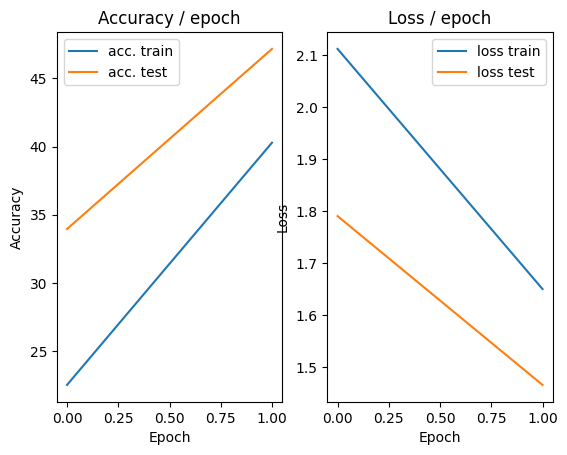

=== EPOCH 3 =====

[TRAIN Batch 000/391]	Time 0.118s (0.118s)	Loss 1.2860 (1.2860)	Prec@1  50.8 ( 50.8)	Prec@5  93.0 ( 93.0)


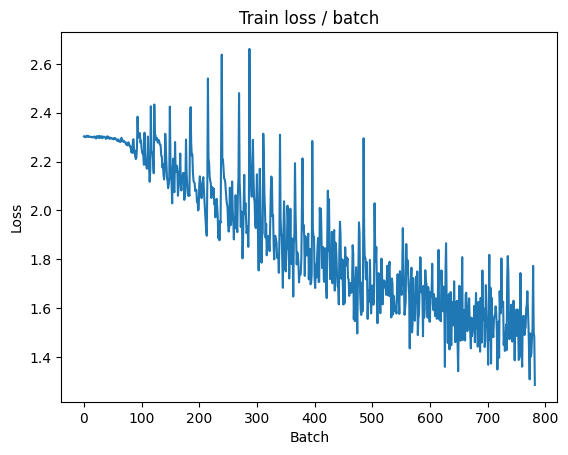

[TRAIN Batch 200/391]	Time 0.017s (0.030s)	Loss 1.4816 (1.4439)	Prec@1  49.2 ( 47.7)	Prec@5  90.6 ( 92.6)


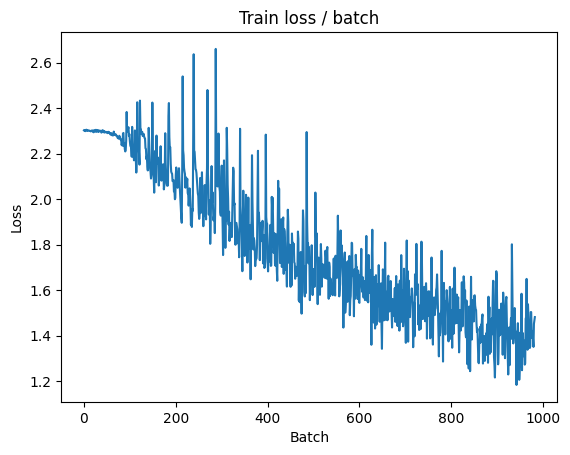


===============> Total time 11s	Avg loss 1.4128	Avg Prec@1 49.14 %	Avg Prec@5 92.95 %

[EVAL Batch 000/079]	Time 0.184s (0.184s)	Loss 1.1998 (1.1998)	Prec@1  62.5 ( 62.5)	Prec@5  94.5 ( 94.5)

===============> Total time 2s	Avg loss 1.2764	Avg Prec@1 54.43 %	Avg Prec@5 94.39 %



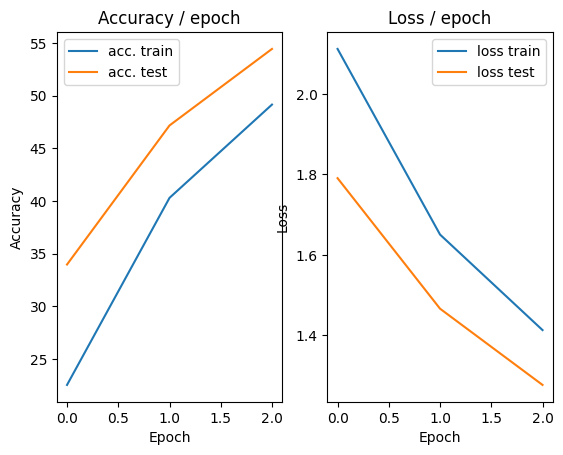

=== EPOCH 4 =====

[TRAIN Batch 000/391]	Time 0.120s (0.120s)	Loss 1.2004 (1.2004)	Prec@1  55.5 ( 55.5)	Prec@5  97.7 ( 97.7)


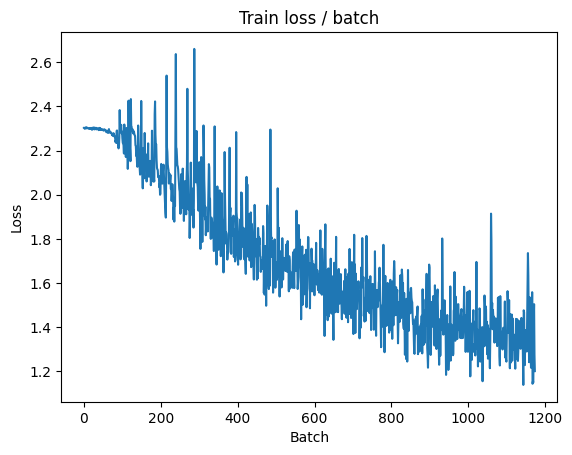

[TRAIN Batch 200/391]	Time 0.093s (0.030s)	Loss 1.1683 (1.2773)	Prec@1  64.1 ( 54.4)	Prec@5  94.5 ( 94.6)


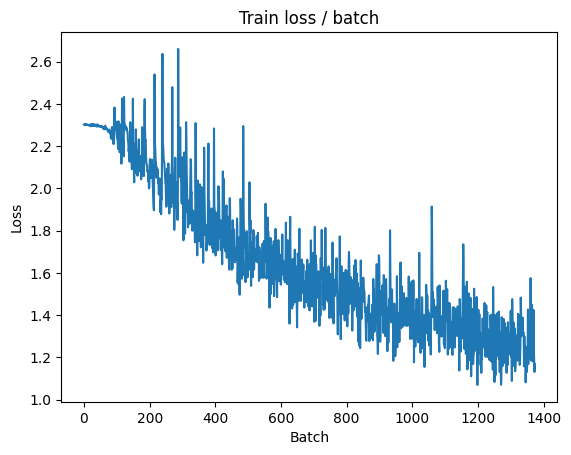


===============> Total time 10s	Avg loss 1.2487	Avg Prec@1 55.64 %	Avg Prec@5 94.80 %

[EVAL Batch 000/079]	Time 0.114s (0.114s)	Loss 1.3200 (1.3200)	Prec@1  54.7 ( 54.7)	Prec@5  92.2 ( 92.2)

===============> Total time 1s	Avg loss 1.4149	Avg Prec@1 50.16 %	Avg Prec@5 92.77 %



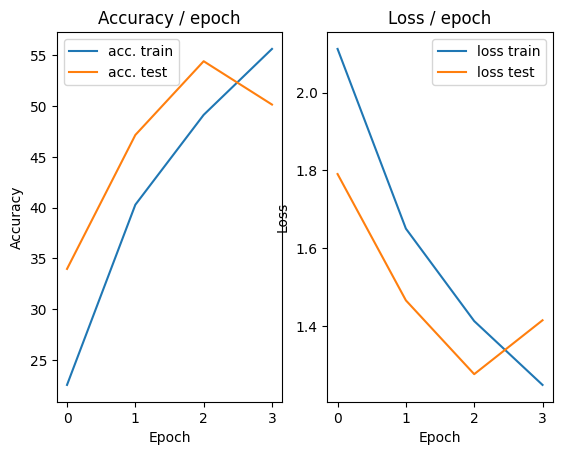

=== EPOCH 5 =====

[TRAIN Batch 000/391]	Time 0.126s (0.126s)	Loss 1.4511 (1.4511)	Prec@1  50.0 ( 50.0)	Prec@5  94.5 ( 94.5)


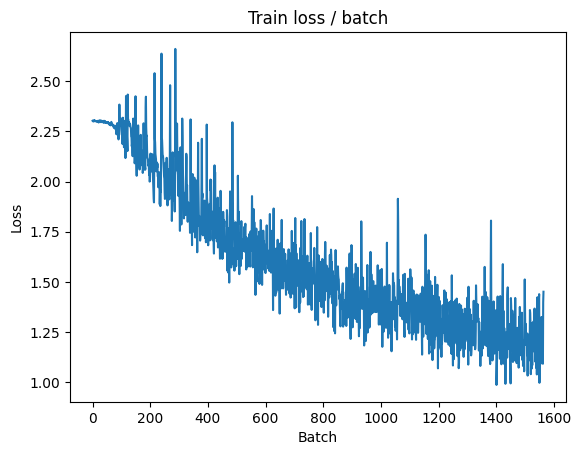

[TRAIN Batch 200/391]	Time 0.032s (0.025s)	Loss 1.0052 (1.1276)	Prec@1  64.1 ( 60.2)	Prec@5  96.9 ( 95.8)


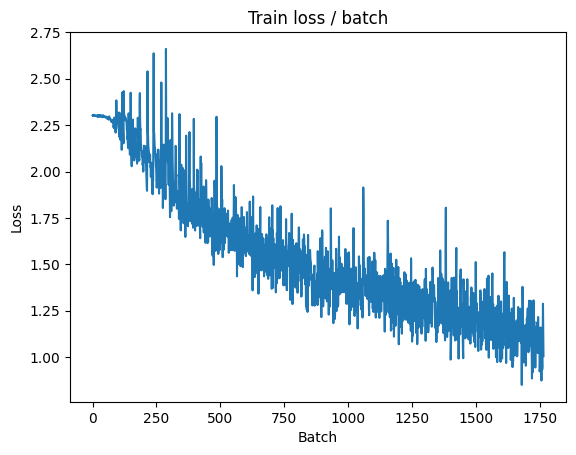


===============> Total time 10s	Avg loss 1.1117	Avg Prec@1 60.77 %	Avg Prec@5 95.98 %

[EVAL Batch 000/079]	Time 0.102s (0.102s)	Loss 1.0095 (1.0095)	Prec@1  61.7 ( 61.7)	Prec@5  96.1 ( 96.1)

===============> Total time 1s	Avg loss 1.1618	Avg Prec@1 58.39 %	Avg Prec@5 95.43 %



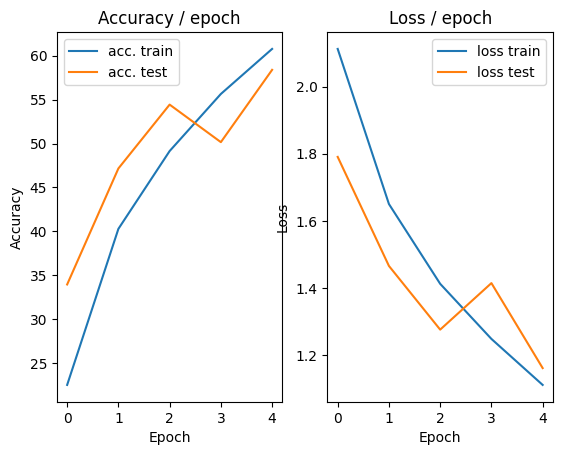

=== EPOCH 6 =====

[TRAIN Batch 000/391]	Time 0.126s (0.126s)	Loss 1.1732 (1.1732)	Prec@1  57.0 ( 57.0)	Prec@5  96.1 ( 96.1)


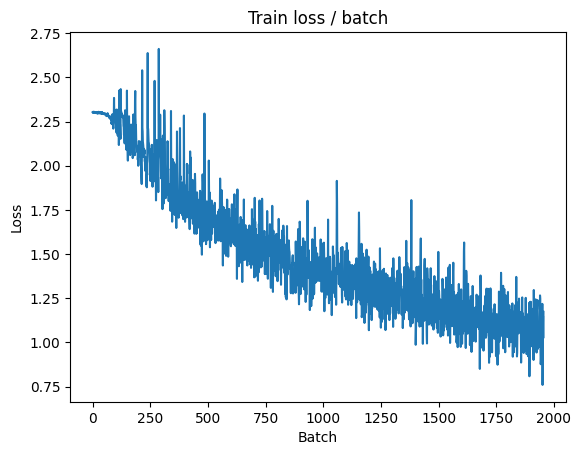

[TRAIN Batch 200/391]	Time 0.018s (0.022s)	Loss 0.8702 (0.9977)	Prec@1  66.4 ( 64.6)	Prec@5  96.9 ( 96.9)


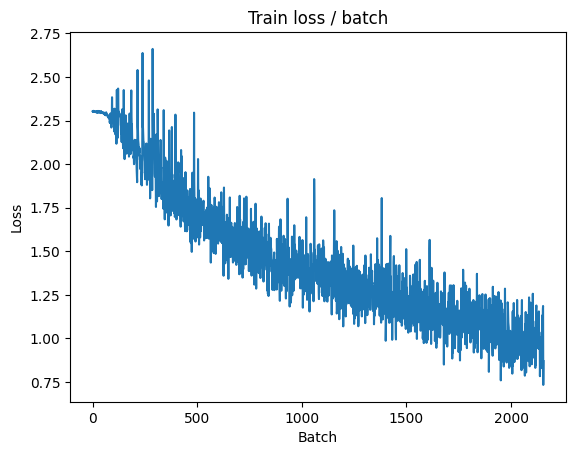


===============> Total time 10s	Avg loss 0.9896	Avg Prec@1 65.01 %	Avg Prec@5 96.90 %

[EVAL Batch 000/079]	Time 0.113s (0.113s)	Loss 1.0374 (1.0374)	Prec@1  62.5 ( 62.5)	Prec@5  96.9 ( 96.9)

===============> Total time 1s	Avg loss 1.1147	Avg Prec@1 61.90 %	Avg Prec@5 95.55 %



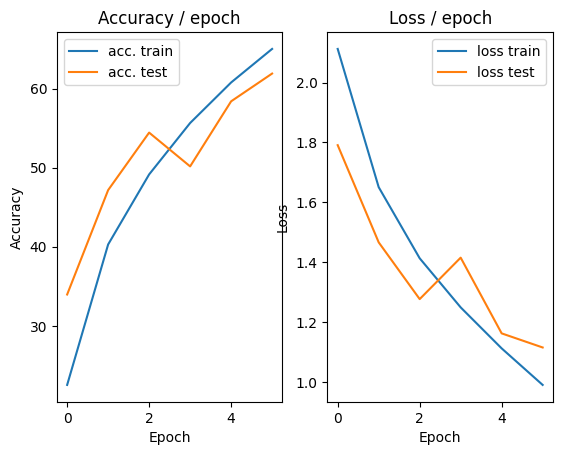

=== EPOCH 7 =====

[TRAIN Batch 000/391]	Time 0.147s (0.147s)	Loss 0.9188 (0.9188)	Prec@1  72.7 ( 72.7)	Prec@5  96.9 ( 96.9)


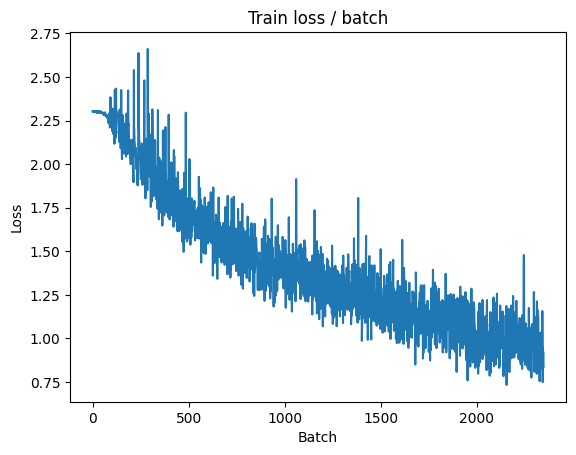

[TRAIN Batch 200/391]	Time 0.013s (0.022s)	Loss 0.7988 (0.8807)	Prec@1  70.3 ( 69.2)	Prec@5  98.4 ( 97.5)


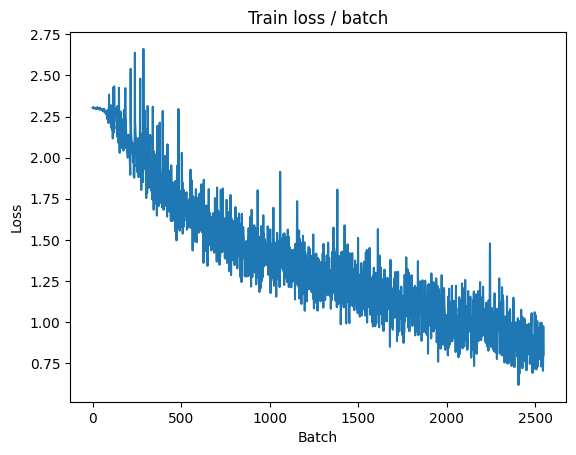


===============> Total time 9s	Avg loss 0.8731	Avg Prec@1 69.53 %	Avg Prec@5 97.60 %

[EVAL Batch 000/079]	Time 0.190s (0.190s)	Loss 0.9652 (0.9652)	Prec@1  66.4 ( 66.4)	Prec@5  96.9 ( 96.9)

===============> Total time 2s	Avg loss 1.0092	Avg Prec@1 64.95 %	Avg Prec@5 96.64 %



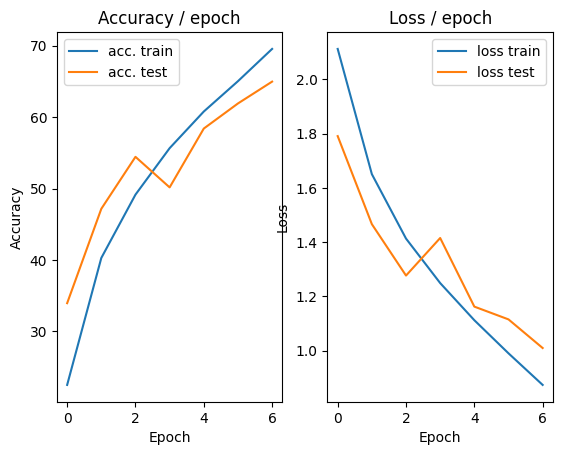

=== EPOCH 8 =====

[TRAIN Batch 000/391]	Time 0.124s (0.124s)	Loss 0.8008 (0.8008)	Prec@1  71.9 ( 71.9)	Prec@5  98.4 ( 98.4)


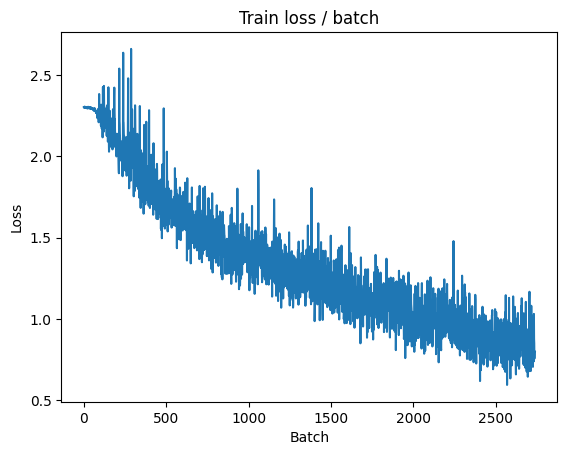

[TRAIN Batch 200/391]	Time 0.014s (0.022s)	Loss 0.6118 (0.7754)	Prec@1  78.1 ( 73.2)	Prec@5 100.0 ( 98.3)


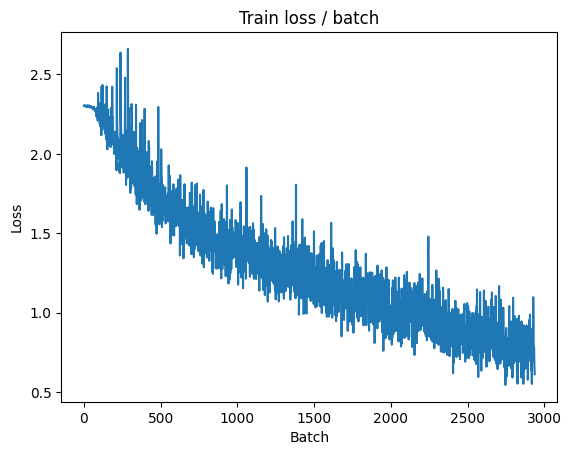


===============> Total time 8s	Avg loss 0.7733	Avg Prec@1 72.96 %	Avg Prec@5 98.27 %

[EVAL Batch 000/079]	Time 0.117s (0.117s)	Loss 0.8213 (0.8213)	Prec@1  68.8 ( 68.8)	Prec@5  99.2 ( 99.2)

===============> Total time 1s	Avg loss 0.9274	Avg Prec@1 67.11 %	Avg Prec@5 97.26 %



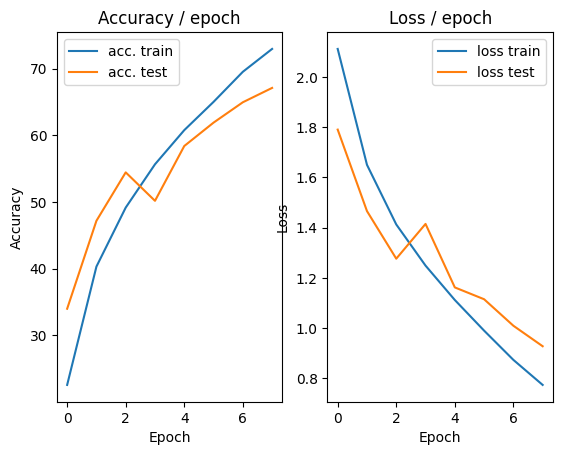

=== EPOCH 9 =====

[TRAIN Batch 000/391]	Time 0.177s (0.177s)	Loss 0.6312 (0.6312)	Prec@1  79.7 ( 79.7)	Prec@5  98.4 ( 98.4)


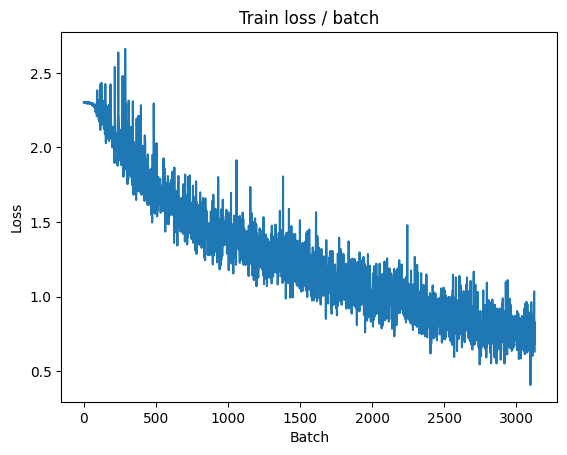

[TRAIN Batch 200/391]	Time 0.014s (0.027s)	Loss 0.6889 (0.6710)	Prec@1  75.8 ( 76.5)	Prec@5  99.2 ( 98.8)


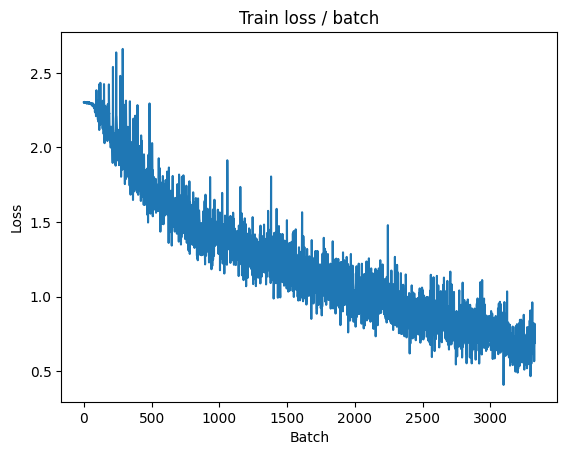


===============> Total time 9s	Avg loss 0.6744	Avg Prec@1 76.25 %	Avg Prec@5 98.76 %

[EVAL Batch 000/079]	Time 0.115s (0.115s)	Loss 0.9560 (0.9560)	Prec@1  68.8 ( 68.8)	Prec@5  95.3 ( 95.3)

===============> Total time 1s	Avg loss 0.9485	Avg Prec@1 68.27 %	Avg Prec@5 96.98 %



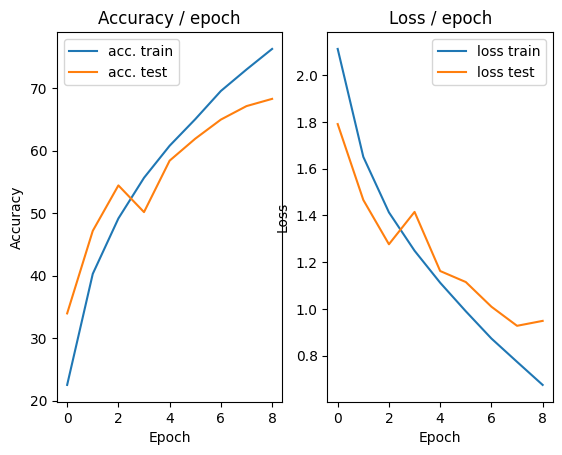

=== EPOCH 10 =====

[TRAIN Batch 000/391]	Time 0.150s (0.150s)	Loss 0.6402 (0.6402)	Prec@1  78.1 ( 78.1)	Prec@5  99.2 ( 99.2)


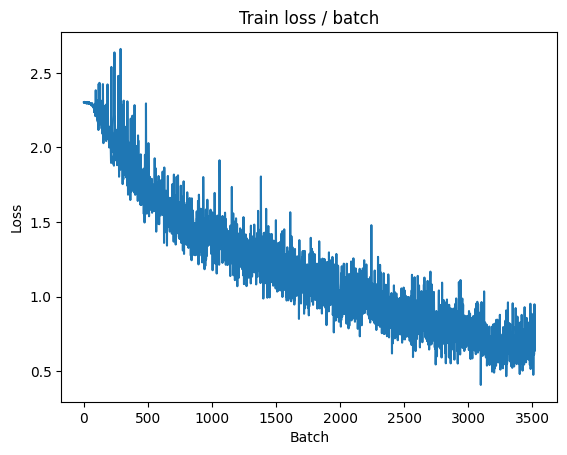

[TRAIN Batch 200/391]	Time 0.015s (0.030s)	Loss 0.8539 (0.5662)	Prec@1  68.8 ( 80.1)	Prec@5  97.7 ( 99.3)


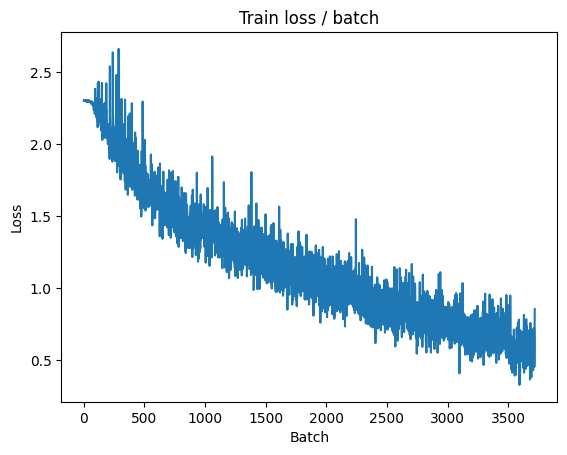


===============> Total time 10s	Avg loss 0.5764	Avg Prec@1 79.83 %	Avg Prec@5 99.21 %

[EVAL Batch 000/079]	Time 0.114s (0.114s)	Loss 1.1324 (1.1324)	Prec@1  64.1 ( 64.1)	Prec@5  94.5 ( 94.5)

===============> Total time 1s	Avg loss 1.0731	Avg Prec@1 66.31 %	Avg Prec@5 96.95 %



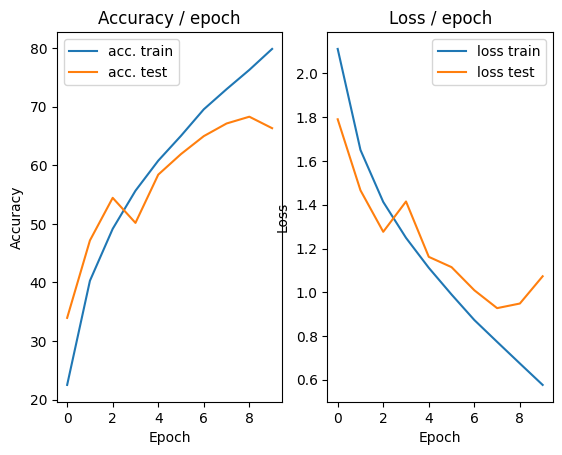

=== EPOCH 11 =====

[TRAIN Batch 000/391]	Time 0.135s (0.135s)	Loss 0.5507 (0.5507)	Prec@1  83.6 ( 83.6)	Prec@5  99.2 ( 99.2)


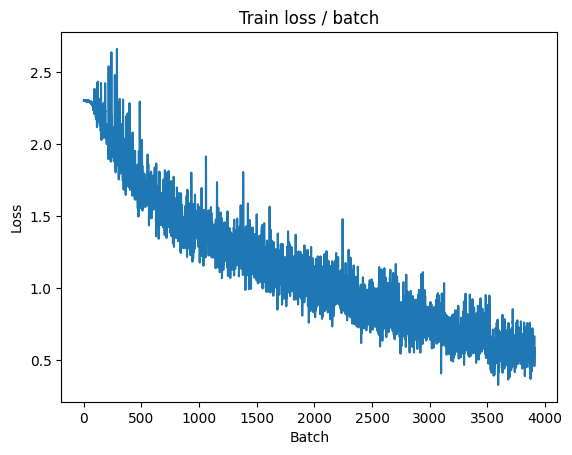

[TRAIN Batch 200/391]	Time 0.025s (0.028s)	Loss 0.3797 (0.4755)	Prec@1  86.7 ( 83.4)	Prec@5  99.2 ( 99.5)


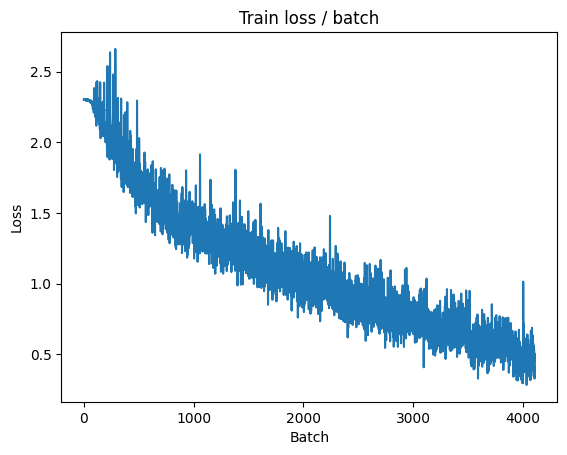


===============> Total time 10s	Avg loss 0.4861	Avg Prec@1 82.94 %	Avg Prec@5 99.44 %

[EVAL Batch 000/079]	Time 0.108s (0.108s)	Loss 1.0879 (1.0879)	Prec@1  67.2 ( 67.2)	Prec@5  96.9 ( 96.9)

===============> Total time 1s	Avg loss 1.0425	Avg Prec@1 67.53 %	Avg Prec@5 97.02 %



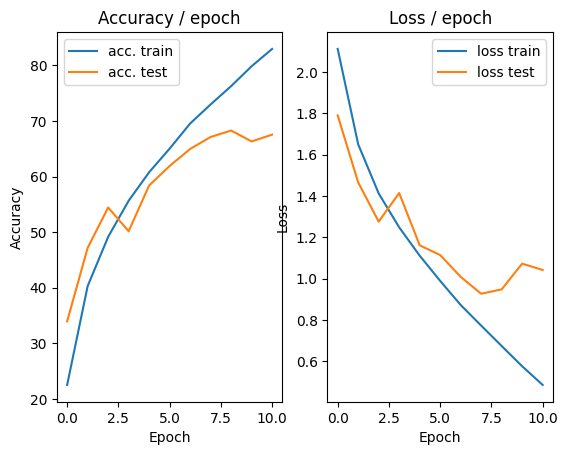

=== EPOCH 12 =====

[TRAIN Batch 000/391]	Time 0.133s (0.133s)	Loss 0.4129 (0.4129)	Prec@1  83.6 ( 83.6)	Prec@5 100.0 (100.0)


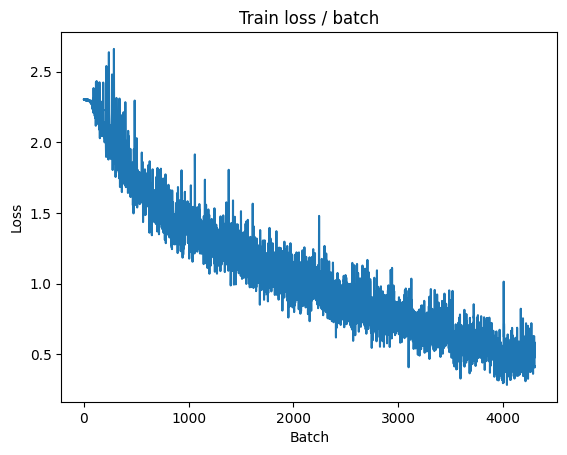

[TRAIN Batch 200/391]	Time 0.014s (0.024s)	Loss 0.3306 (0.3742)	Prec@1  86.7 ( 87.2)	Prec@5 100.0 ( 99.7)


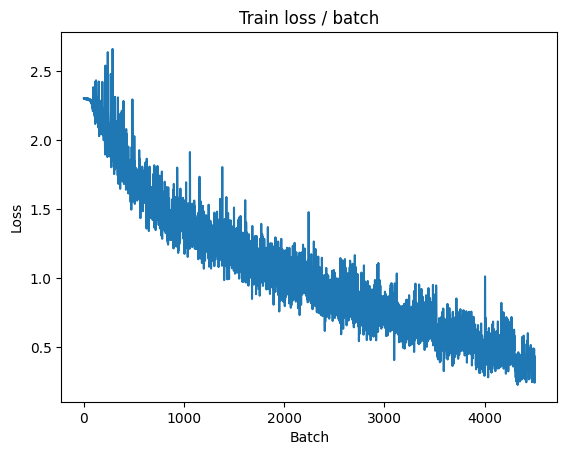


===============> Total time 10s	Avg loss 0.3905	Avg Prec@1 86.50 %	Avg Prec@5 99.68 %

[EVAL Batch 000/079]	Time 0.127s (0.127s)	Loss 1.1155 (1.1155)	Prec@1  69.5 ( 69.5)	Prec@5  96.9 ( 96.9)

===============> Total time 1s	Avg loss 1.1549	Avg Prec@1 67.66 %	Avg Prec@5 96.76 %



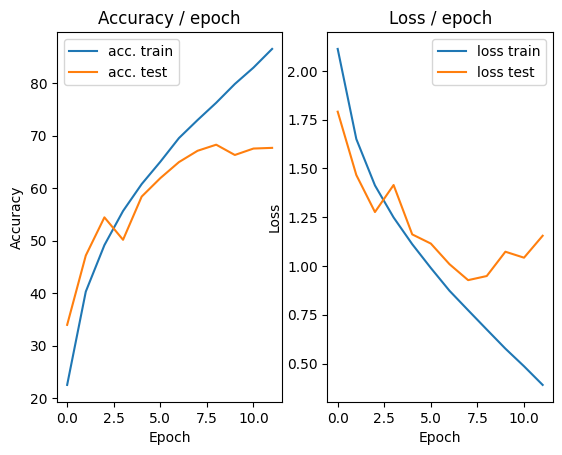

=== EPOCH 13 =====

[TRAIN Batch 000/391]	Time 0.142s (0.142s)	Loss 0.2999 (0.2999)	Prec@1  89.1 ( 89.1)	Prec@5 100.0 (100.0)


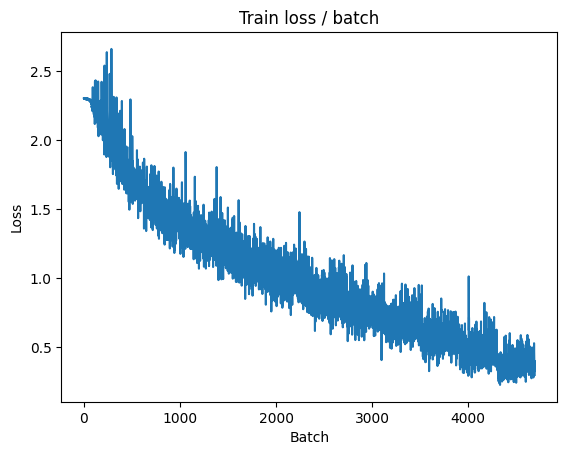

[TRAIN Batch 200/391]	Time 0.008s (0.023s)	Loss 0.3249 (0.2817)	Prec@1  85.9 ( 90.5)	Prec@5 100.0 ( 99.8)


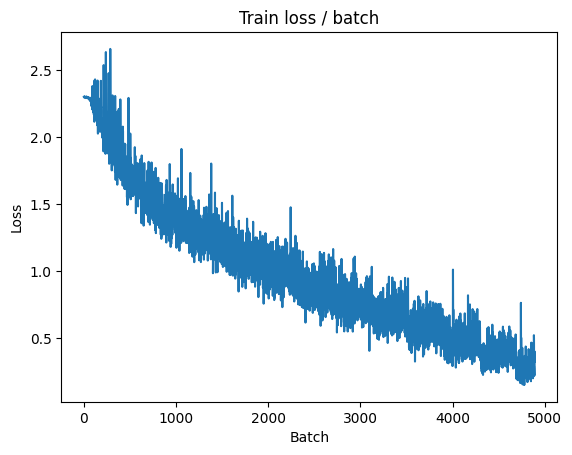


===============> Total time 10s	Avg loss 0.3081	Avg Prec@1 89.40 %	Avg Prec@5 99.84 %

[EVAL Batch 000/079]	Time 0.150s (0.150s)	Loss 1.1851 (1.1851)	Prec@1  69.5 ( 69.5)	Prec@5  95.3 ( 95.3)

===============> Total time 1s	Avg loss 1.0969	Avg Prec@1 69.48 %	Avg Prec@5 97.07 %



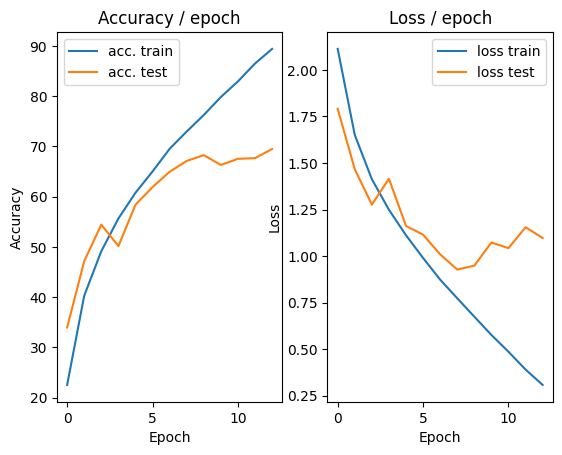

=== EPOCH 14 =====

[TRAIN Batch 000/391]	Time 0.156s (0.156s)	Loss 0.1499 (0.1499)	Prec@1  95.3 ( 95.3)	Prec@5 100.0 (100.0)


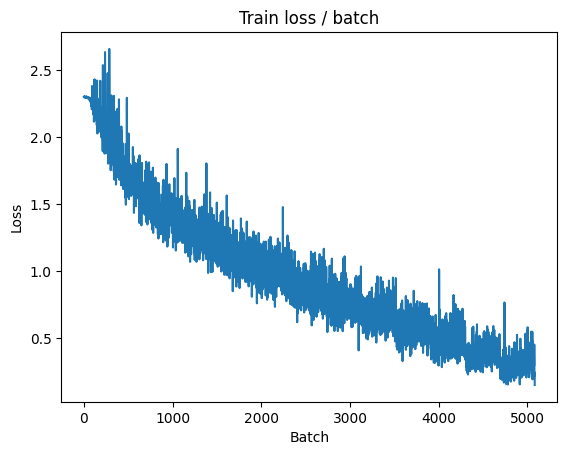

[TRAIN Batch 200/391]	Time 0.027s (0.023s)	Loss 0.3237 (0.2078)	Prec@1  88.3 ( 92.9)	Prec@5 100.0 ( 99.9)


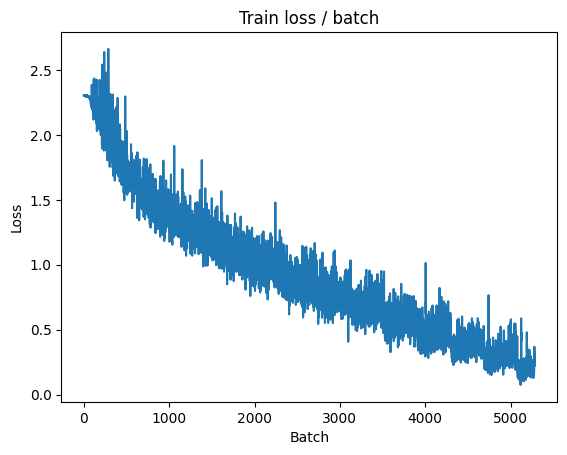


===============> Total time 9s	Avg loss 0.2284	Avg Prec@1 92.11 %	Avg Prec@5 99.93 %

[EVAL Batch 000/079]	Time 0.146s (0.146s)	Loss 1.2849 (1.2849)	Prec@1  76.6 ( 76.6)	Prec@5  95.3 ( 95.3)

===============> Total time 2s	Avg loss 1.2636	Avg Prec@1 68.00 %	Avg Prec@5 97.18 %



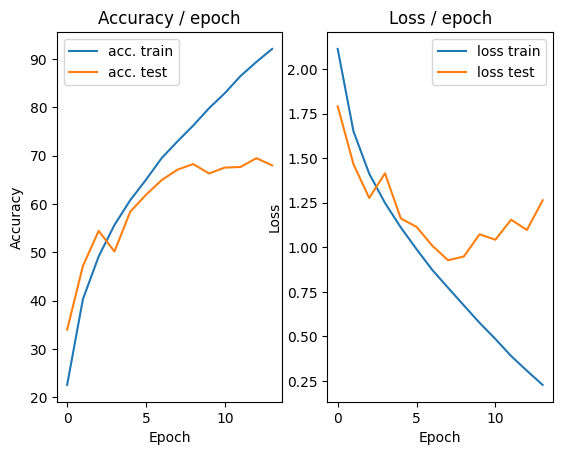

=== EPOCH 15 =====

[TRAIN Batch 000/391]	Time 0.148s (0.148s)	Loss 0.3035 (0.3035)	Prec@1  89.1 ( 89.1)	Prec@5  99.2 ( 99.2)


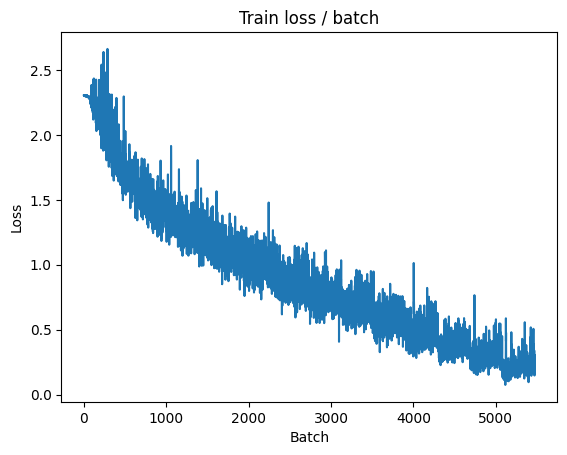

[TRAIN Batch 200/391]	Time 0.024s (0.023s)	Loss 0.1480 (0.1410)	Prec@1  94.5 ( 95.5)	Prec@5 100.0 (100.0)


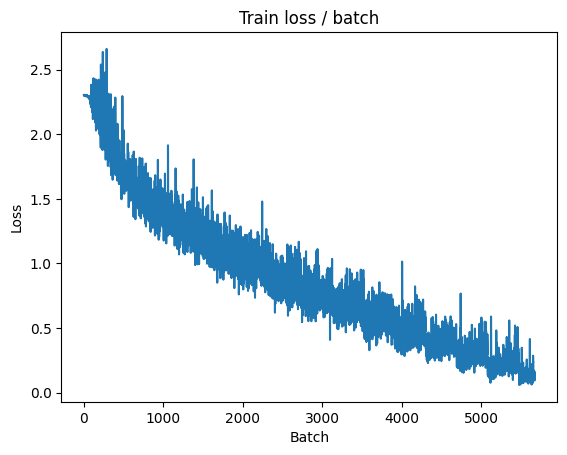


===============> Total time 8s	Avg loss 0.1704	Avg Prec@1 94.27 %	Avg Prec@5 99.97 %

[EVAL Batch 000/079]	Time 0.117s (0.117s)	Loss 1.6306 (1.6306)	Prec@1  70.3 ( 70.3)	Prec@5  95.3 ( 95.3)

===============> Total time 1s	Avg loss 1.2694	Avg Prec@1 69.30 %	Avg Prec@5 97.07 %



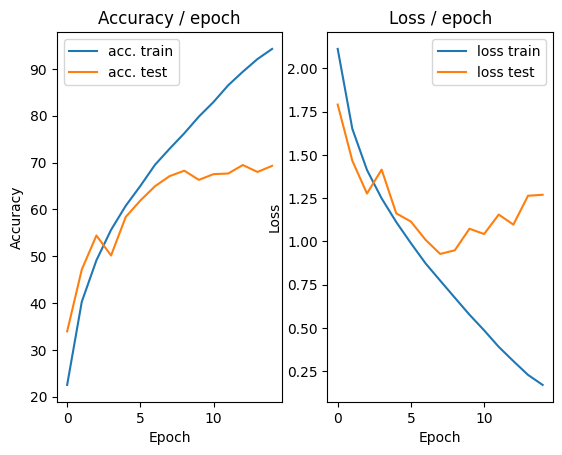

=== EPOCH 16 =====

[TRAIN Batch 000/391]	Time 0.172s (0.172s)	Loss 0.0997 (0.0997)	Prec@1  97.7 ( 97.7)	Prec@5 100.0 (100.0)


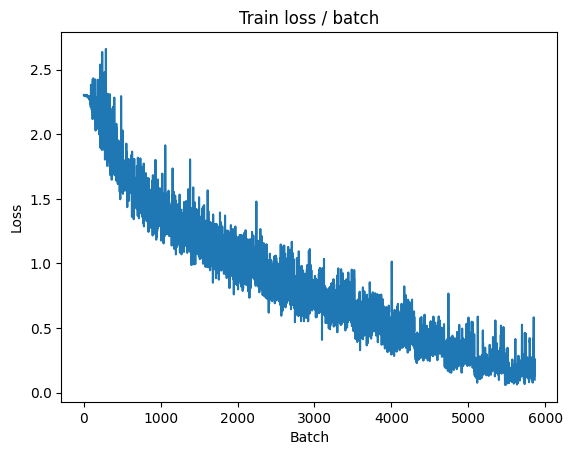

[TRAIN Batch 200/391]	Time 0.018s (0.027s)	Loss 0.0821 (0.0932)	Prec@1  97.7 ( 97.2)	Prec@5 100.0 (100.0)


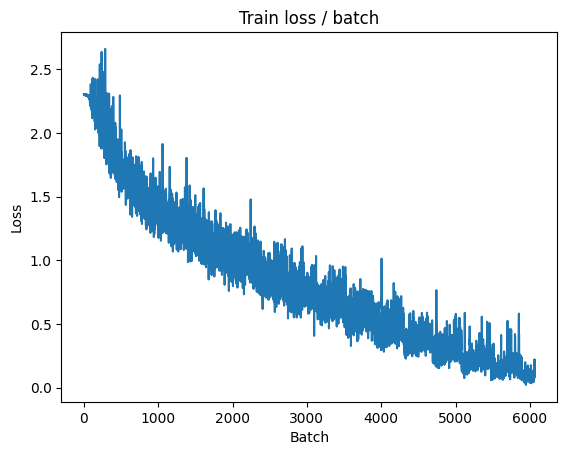


===============> Total time 9s	Avg loss 0.1162	Avg Prec@1 96.28 %	Avg Prec@5 99.99 %

[EVAL Batch 000/079]	Time 0.127s (0.127s)	Loss 1.5304 (1.5304)	Prec@1  71.9 ( 71.9)	Prec@5  94.5 ( 94.5)

===============> Total time 1s	Avg loss 1.4120	Avg Prec@1 69.40 %	Avg Prec@5 96.80 %



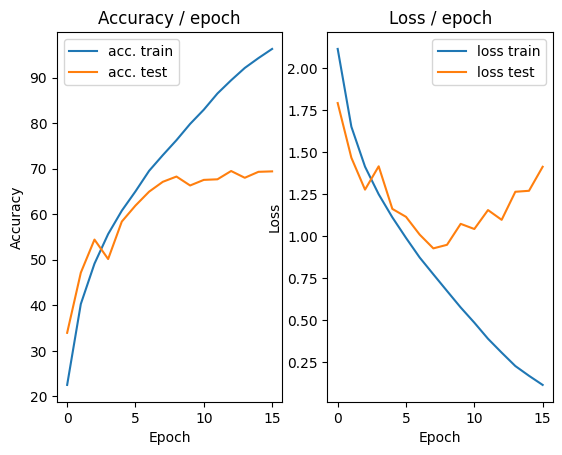

=== EPOCH 17 =====

[TRAIN Batch 000/391]	Time 0.147s (0.147s)	Loss 0.2245 (0.2245)	Prec@1  93.0 ( 93.0)	Prec@5 100.0 (100.0)


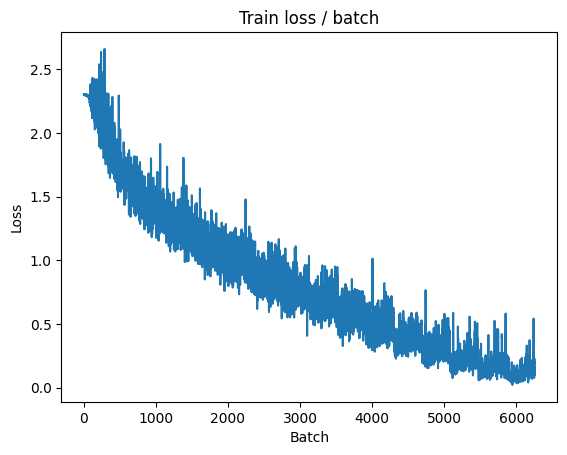

[TRAIN Batch 200/391]	Time 0.017s (0.031s)	Loss 0.0387 (0.0630)	Prec@1  99.2 ( 98.1)	Prec@5 100.0 (100.0)


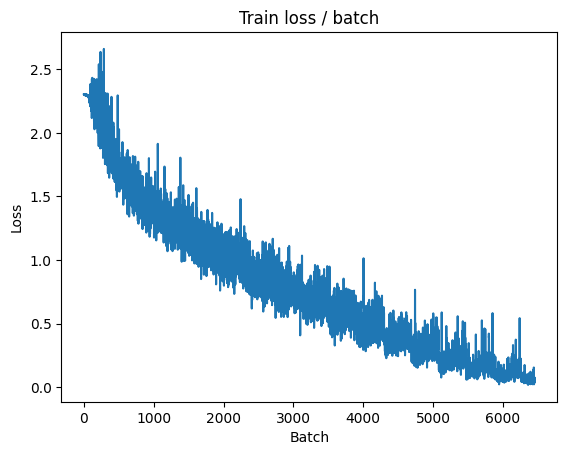


===============> Total time 10s	Avg loss 0.0852	Avg Prec@1 97.36 %	Avg Prec@5 99.99 %

[EVAL Batch 000/079]	Time 0.124s (0.124s)	Loss 1.8967 (1.8967)	Prec@1  68.0 ( 68.0)	Prec@5  95.3 ( 95.3)

===============> Total time 1s	Avg loss 1.5118	Avg Prec@1 69.00 %	Avg Prec@5 96.77 %



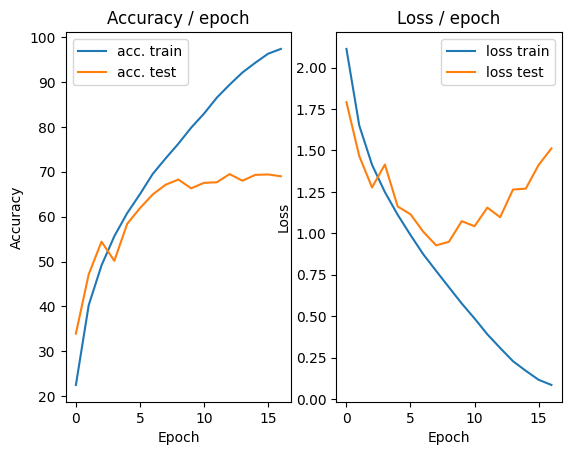

=== EPOCH 18 =====

[TRAIN Batch 000/391]	Time 0.169s (0.169s)	Loss 0.1122 (0.1122)	Prec@1  96.9 ( 96.9)	Prec@5 100.0 (100.0)


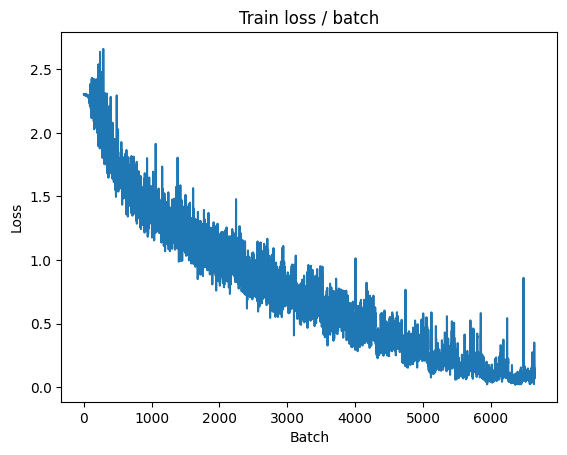

[TRAIN Batch 200/391]	Time 0.014s (0.027s)	Loss 0.0396 (0.0493)	Prec@1  99.2 ( 98.6)	Prec@5 100.0 (100.0)


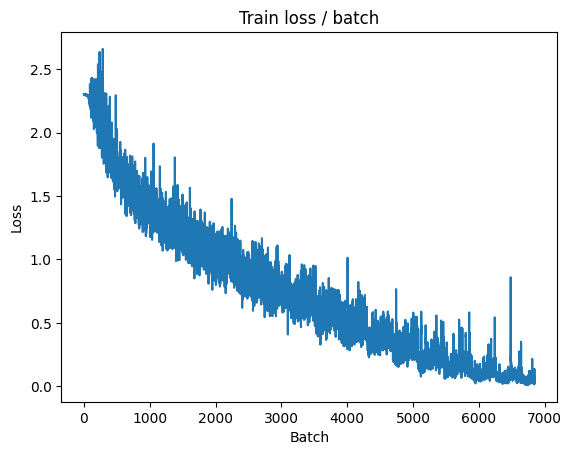


===============> Total time 10s	Avg loss 0.0614	Avg Prec@1 98.12 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.133s (0.133s)	Loss 1.8781 (1.8781)	Prec@1  68.8 ( 68.8)	Prec@5  95.3 ( 95.3)

===============> Total time 1s	Avg loss 1.6030	Avg Prec@1 69.23 %	Avg Prec@5 97.15 %



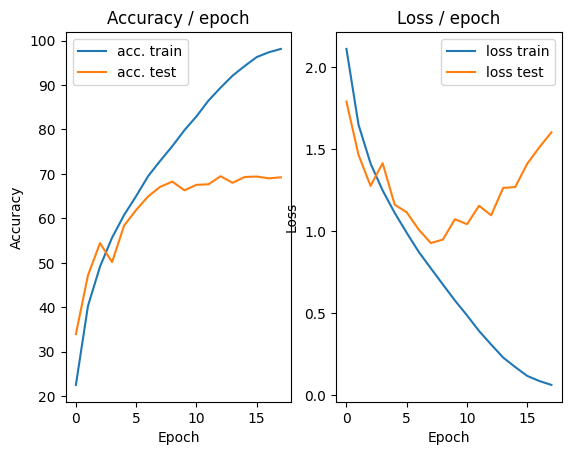

=== EPOCH 19 =====

[TRAIN Batch 000/391]	Time 0.137s (0.137s)	Loss 0.0324 (0.0324)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


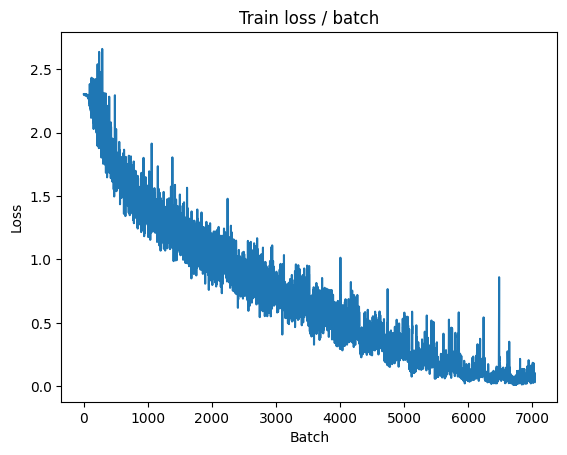

[TRAIN Batch 200/391]	Time 0.008s (0.023s)	Loss 0.0312 (0.0291)	Prec@1  99.2 ( 99.3)	Prec@5 100.0 (100.0)


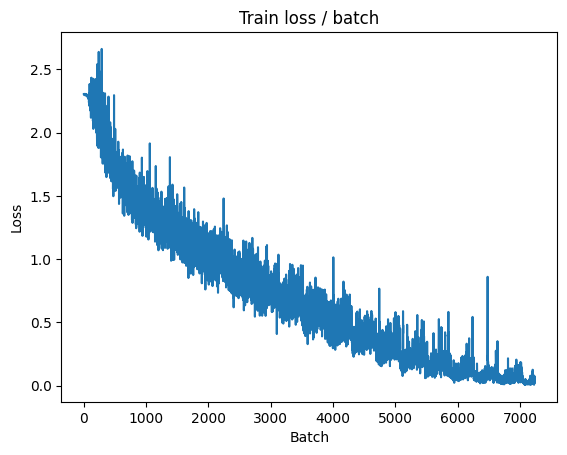


===============> Total time 10s	Avg loss 0.0451	Avg Prec@1 98.61 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.119s (0.119s)	Loss 2.2970 (2.2970)	Prec@1  68.0 ( 68.0)	Prec@5  96.1 ( 96.1)

===============> Total time 1s	Avg loss 1.7509	Avg Prec@1 69.76 %	Avg Prec@5 97.24 %



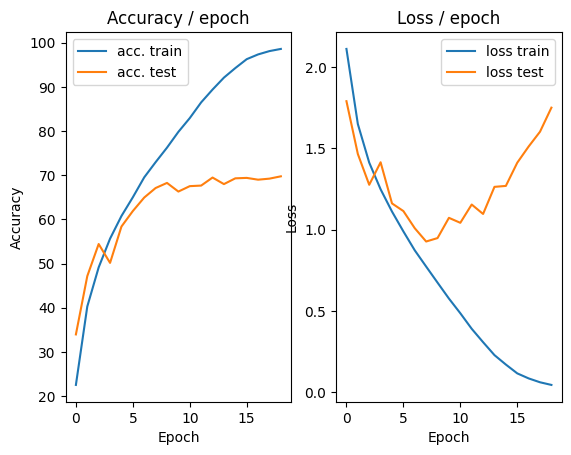

=== EPOCH 20 =====

[TRAIN Batch 000/391]	Time 0.163s (0.163s)	Loss 0.1267 (0.1267)	Prec@1  96.1 ( 96.1)	Prec@5 100.0 (100.0)


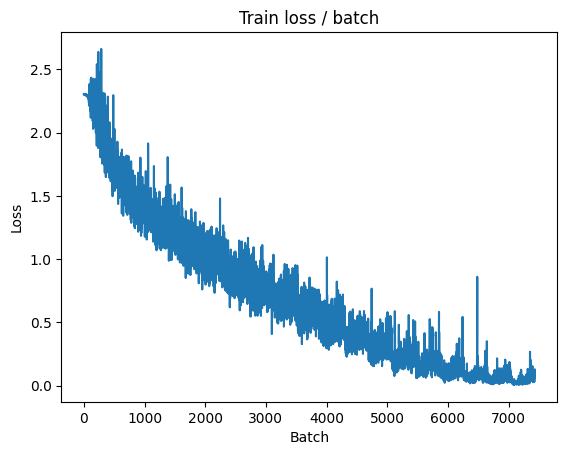

[TRAIN Batch 200/391]	Time 0.009s (0.023s)	Loss 0.0223 (0.0399)	Prec@1 100.0 ( 98.8)	Prec@5 100.0 (100.0)


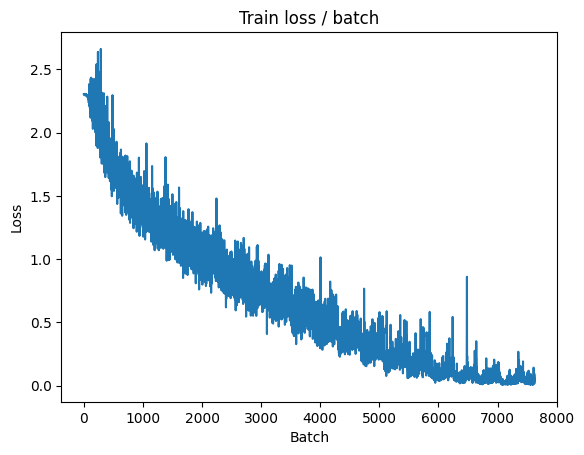


===============> Total time 10s	Avg loss 0.0530	Avg Prec@1 98.44 %	Avg Prec@5 99.99 %

[EVAL Batch 000/079]	Time 0.205s (0.205s)	Loss 2.3088 (2.3088)	Prec@1  68.0 ( 68.0)	Prec@5  96.1 ( 96.1)

===============> Total time 1s	Avg loss 1.8319	Avg Prec@1 69.03 %	Avg Prec@5 97.23 %



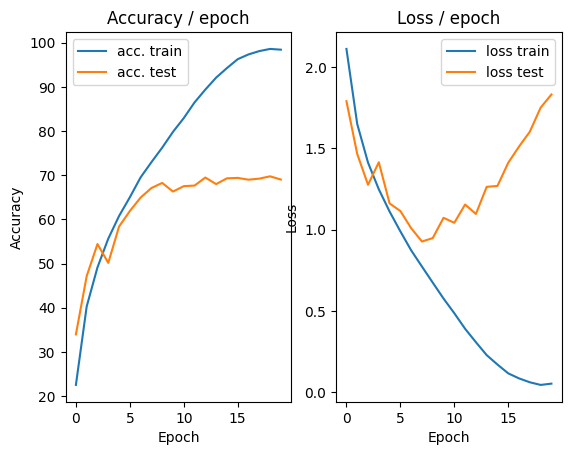

=== EPOCH 21 =====

[TRAIN Batch 000/391]	Time 0.151s (0.151s)	Loss 0.0961 (0.0961)	Prec@1  98.4 ( 98.4)	Prec@5 100.0 (100.0)


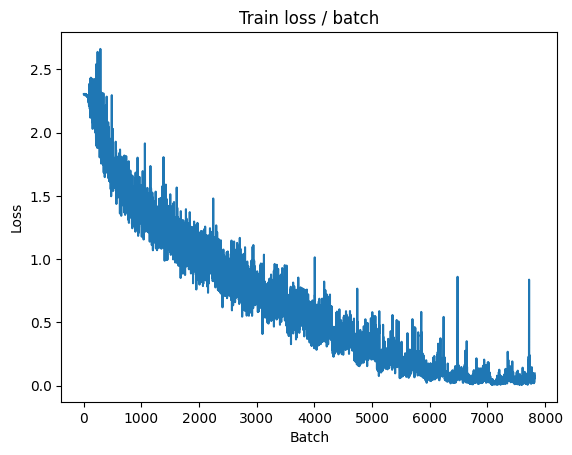

[TRAIN Batch 200/391]	Time 0.013s (0.023s)	Loss 0.0260 (0.0255)	Prec@1  99.2 ( 99.3)	Prec@5 100.0 (100.0)


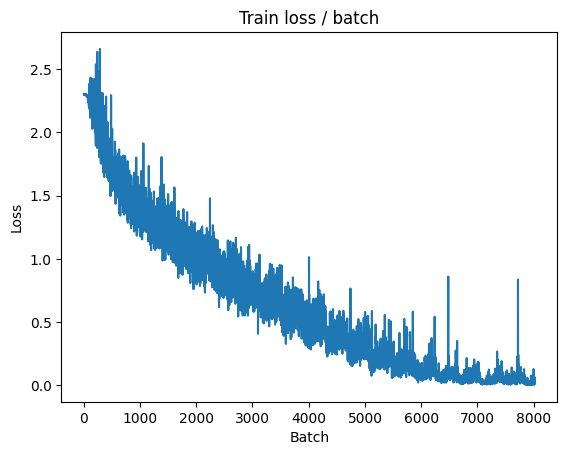


===============> Total time 8s	Avg loss 0.0331	Avg Prec@1 99.05 %	Avg Prec@5 99.99 %

[EVAL Batch 000/079]	Time 0.194s (0.194s)	Loss 2.4650 (2.4650)	Prec@1  69.5 ( 69.5)	Prec@5  96.1 ( 96.1)

===============> Total time 2s	Avg loss 1.9149	Avg Prec@1 68.10 %	Avg Prec@5 96.88 %



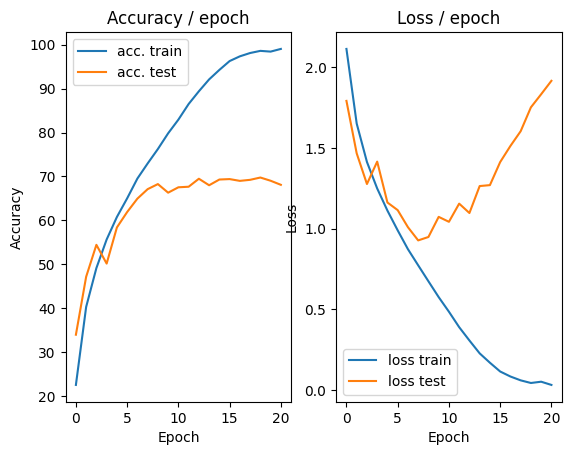

=== EPOCH 22 =====

[TRAIN Batch 000/391]	Time 0.216s (0.216s)	Loss 0.0998 (0.0998)	Prec@1  95.3 ( 95.3)	Prec@5 100.0 (100.0)


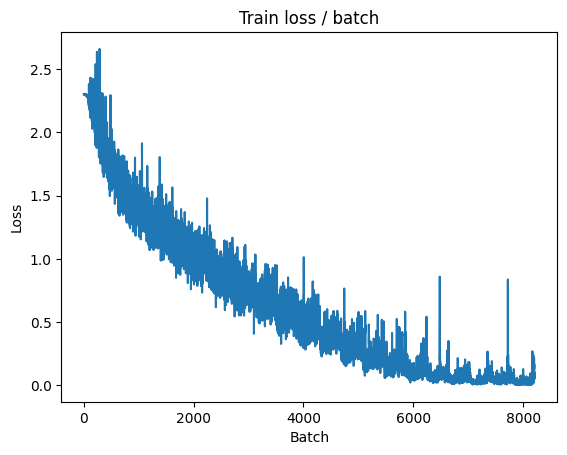

[TRAIN Batch 200/391]	Time 0.016s (0.024s)	Loss 0.0117 (0.1406)	Prec@1 100.0 ( 96.4)	Prec@5 100.0 ( 99.8)


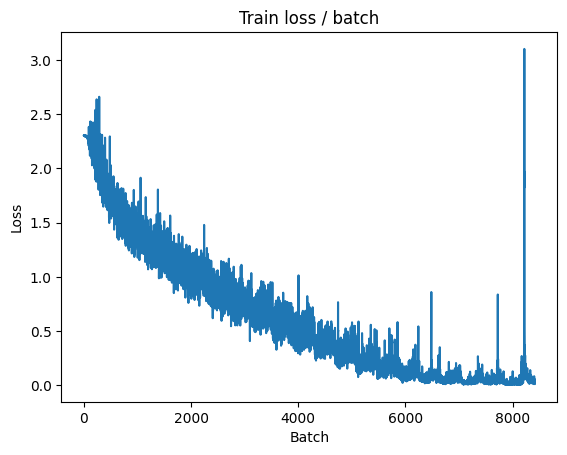


===============> Total time 8s	Avg loss 0.0919	Avg Prec@1 97.56 %	Avg Prec@5 99.91 %

[EVAL Batch 000/079]	Time 0.125s (0.125s)	Loss 2.3323 (2.3323)	Prec@1  71.9 ( 71.9)	Prec@5  96.1 ( 96.1)

===============> Total time 1s	Avg loss 1.8153	Avg Prec@1 69.39 %	Avg Prec@5 97.05 %



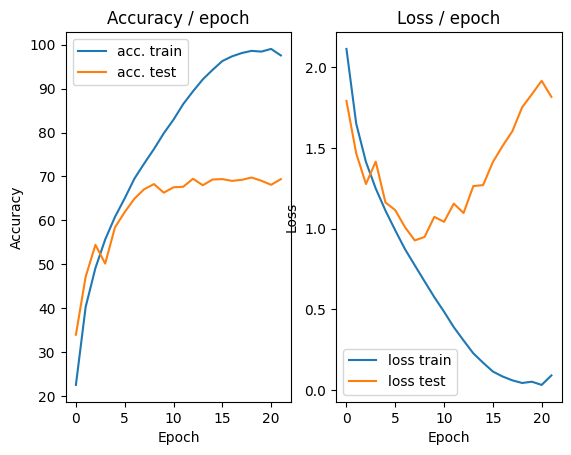

=== EPOCH 23 =====

[TRAIN Batch 000/391]	Time 0.202s (0.202s)	Loss 0.0721 (0.0721)	Prec@1  98.4 ( 98.4)	Prec@5 100.0 (100.0)


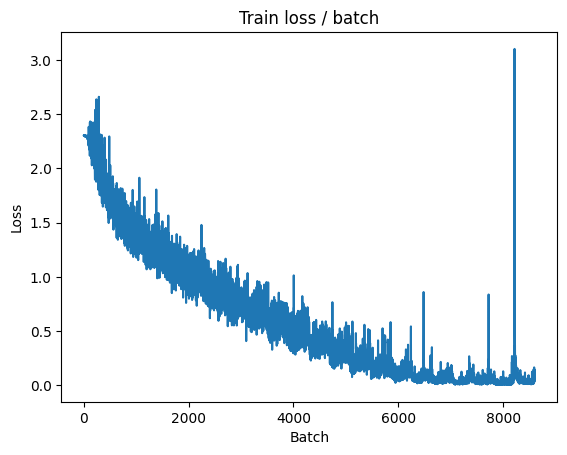

[TRAIN Batch 200/391]	Time 0.017s (0.030s)	Loss 0.0069 (0.0179)	Prec@1 100.0 ( 99.6)	Prec@5 100.0 (100.0)


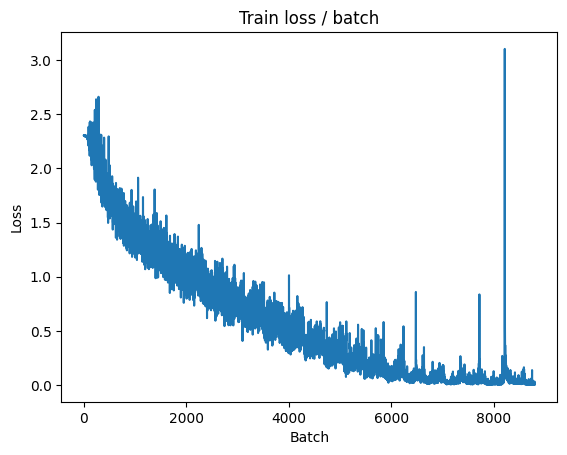


===============> Total time 10s	Avg loss 0.0180	Avg Prec@1 99.52 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.130s (0.130s)	Loss 2.2368 (2.2368)	Prec@1  73.4 ( 73.4)	Prec@5  93.8 ( 93.8)

===============> Total time 1s	Avg loss 1.8366	Avg Prec@1 71.33 %	Avg Prec@5 97.38 %



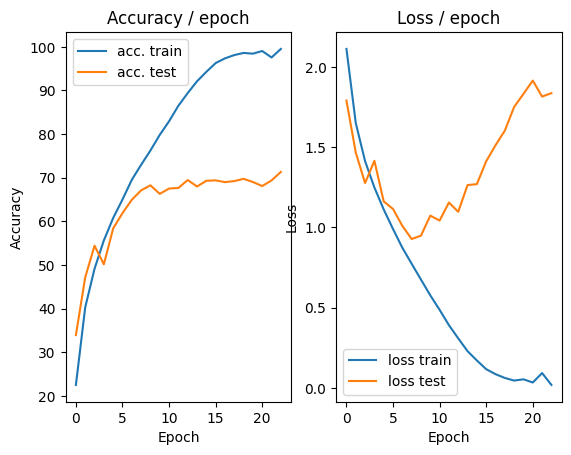

=== EPOCH 24 =====

[TRAIN Batch 000/391]	Time 0.154s (0.154s)	Loss 0.0037 (0.0037)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


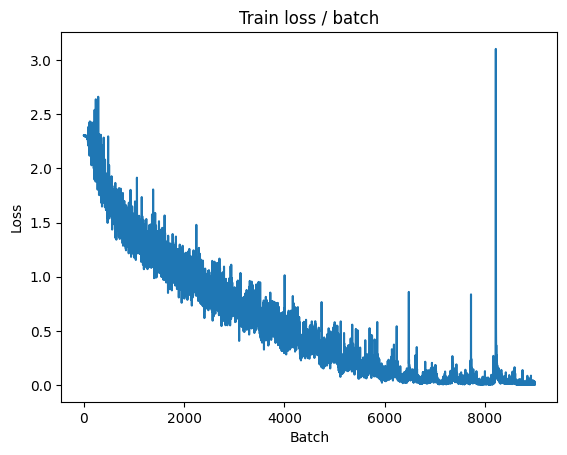

[TRAIN Batch 200/391]	Time 0.020s (0.032s)	Loss 0.0054 (0.0052)	Prec@1 100.0 ( 99.9)	Prec@5 100.0 (100.0)


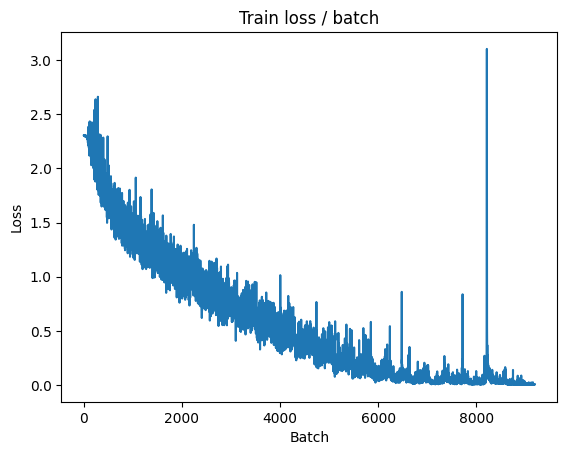


===============> Total time 10s	Avg loss 0.0046	Avg Prec@1 99.92 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.122s (0.122s)	Loss 2.5470 (2.5470)	Prec@1  72.7 ( 72.7)	Prec@5  94.5 ( 94.5)

===============> Total time 1s	Avg loss 1.9474	Avg Prec@1 71.97 %	Avg Prec@5 97.40 %



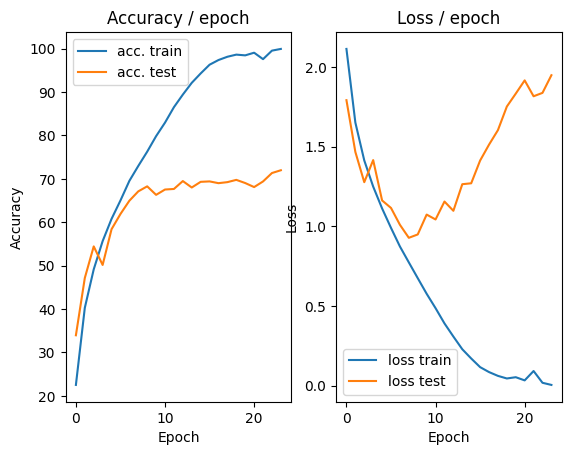

=== EPOCH 25 =====

[TRAIN Batch 000/391]	Time 0.168s (0.168s)	Loss 0.0020 (0.0020)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


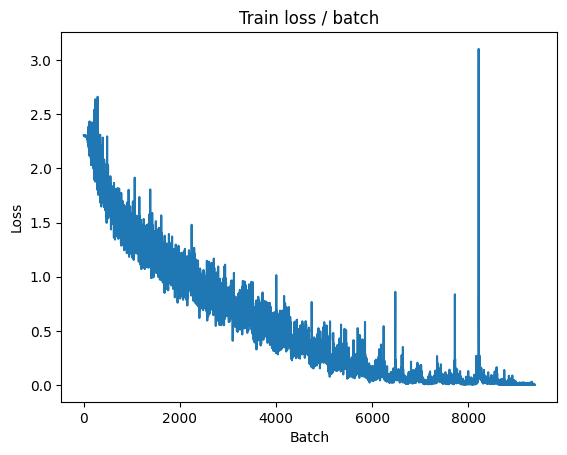

[TRAIN Batch 200/391]	Time 0.024s (0.029s)	Loss 0.0040 (0.0013)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


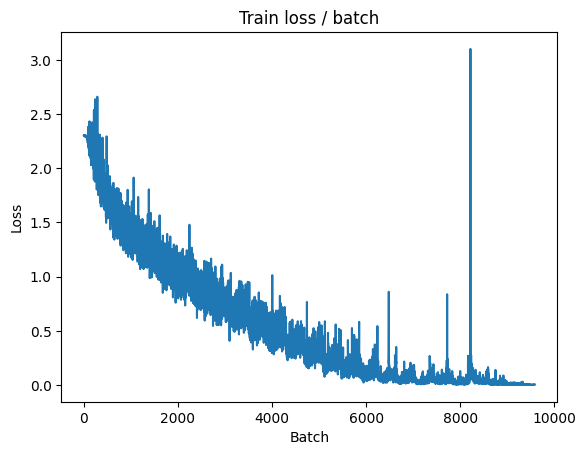


===============> Total time 10s	Avg loss 0.0015	Avg Prec@1 99.98 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.129s (0.129s)	Loss 2.4682 (2.4682)	Prec@1  76.6 ( 76.6)	Prec@5  95.3 ( 95.3)

===============> Total time 1s	Avg loss 1.9792	Avg Prec@1 72.24 %	Avg Prec@5 97.49 %



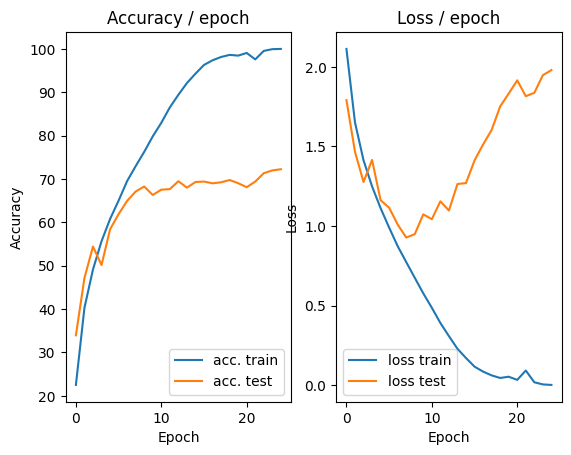

=== EPOCH 26 =====

[TRAIN Batch 000/391]	Time 0.152s (0.152s)	Loss 0.0008 (0.0008)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


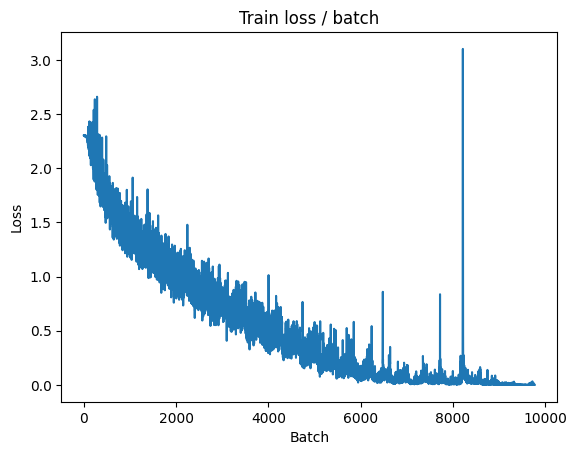

[TRAIN Batch 200/391]	Time 0.014s (0.023s)	Loss 0.0003 (0.0006)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


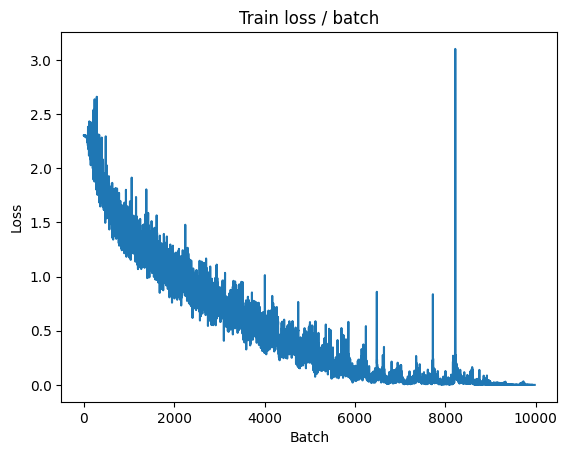


===============> Total time 10s	Avg loss 0.0007	Avg Prec@1 100.00 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.128s (0.128s)	Loss 2.6124 (2.6124)	Prec@1  73.4 ( 73.4)	Prec@5  95.3 ( 95.3)

===============> Total time 1s	Avg loss 2.0477	Avg Prec@1 72.48 %	Avg Prec@5 97.43 %



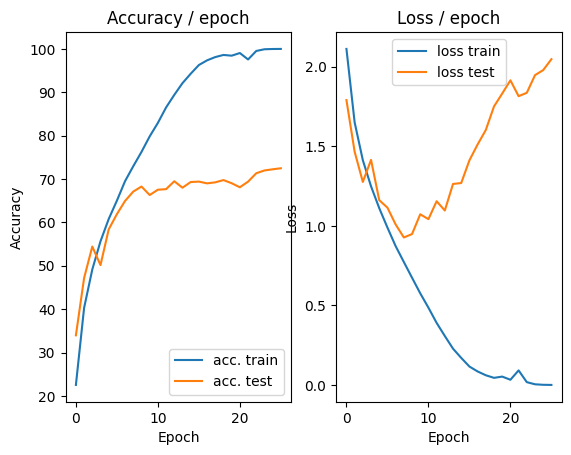

=== EPOCH 27 =====

[TRAIN Batch 000/391]	Time 0.160s (0.160s)	Loss 0.0005 (0.0005)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


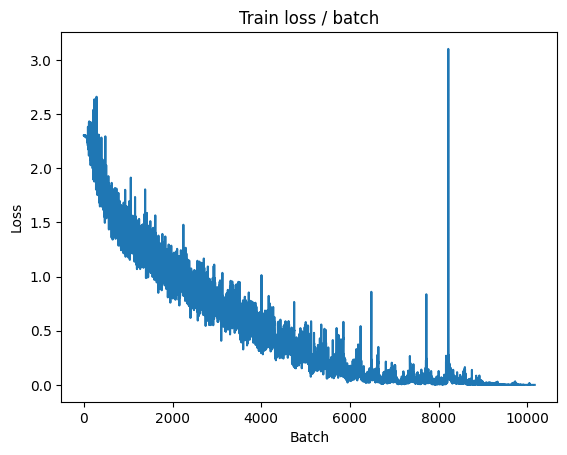

[TRAIN Batch 200/391]	Time 0.033s (0.023s)	Loss 0.0003 (0.0004)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


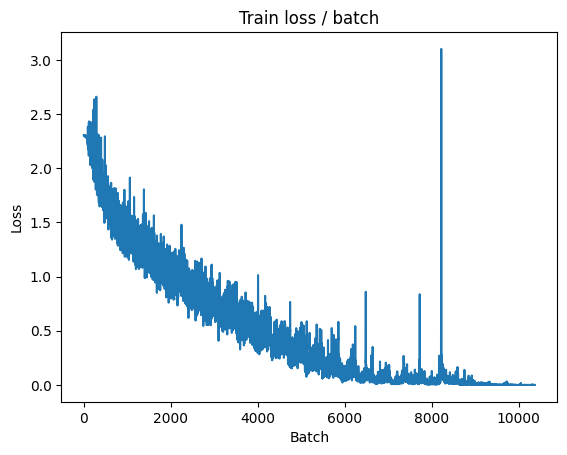


===============> Total time 10s	Avg loss 0.0004	Avg Prec@1 100.00 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.182s (0.182s)	Loss 2.6428 (2.6428)	Prec@1  74.2 ( 74.2)	Prec@5  95.3 ( 95.3)

===============> Total time 1s	Avg loss 2.0901	Avg Prec@1 72.43 %	Avg Prec@5 97.46 %



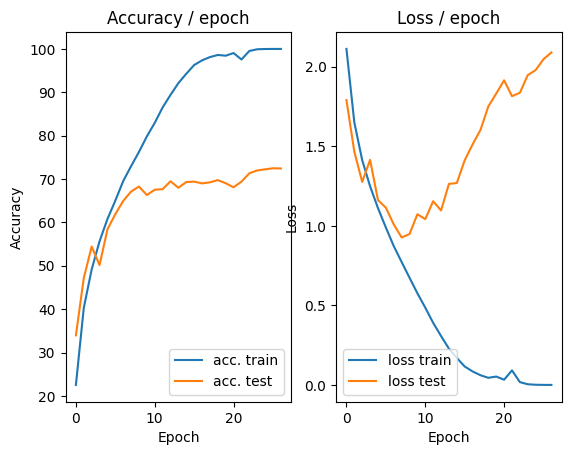

=== EPOCH 28 =====

[TRAIN Batch 000/391]	Time 0.171s (0.171s)	Loss 0.0003 (0.0003)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


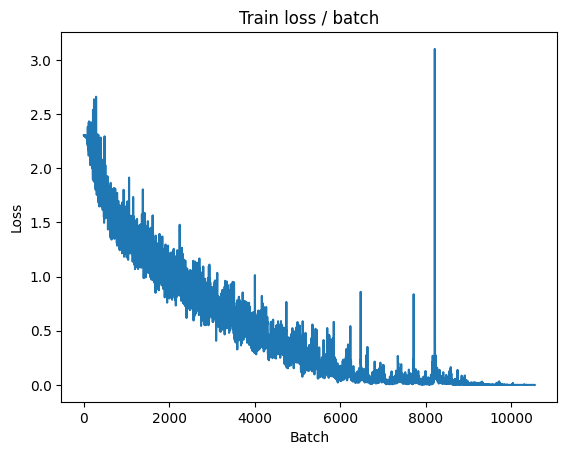

[TRAIN Batch 200/391]	Time 0.013s (0.023s)	Loss 0.0002 (0.0003)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


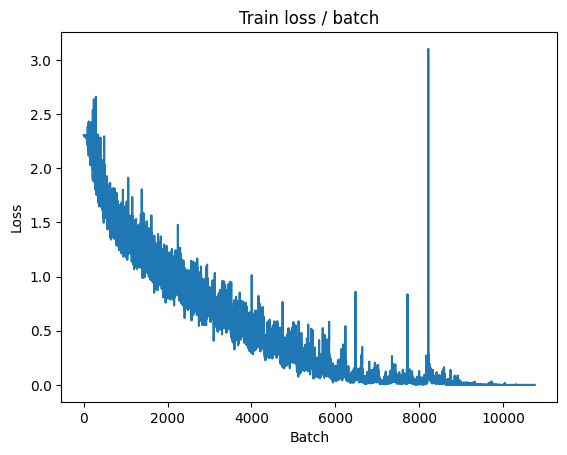


===============> Total time 9s	Avg loss 0.0003	Avg Prec@1 100.00 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.225s (0.225s)	Loss 2.6873 (2.6873)	Prec@1  75.0 ( 75.0)	Prec@5  95.3 ( 95.3)

===============> Total time 2s	Avg loss 2.1198	Avg Prec@1 72.55 %	Avg Prec@5 97.49 %



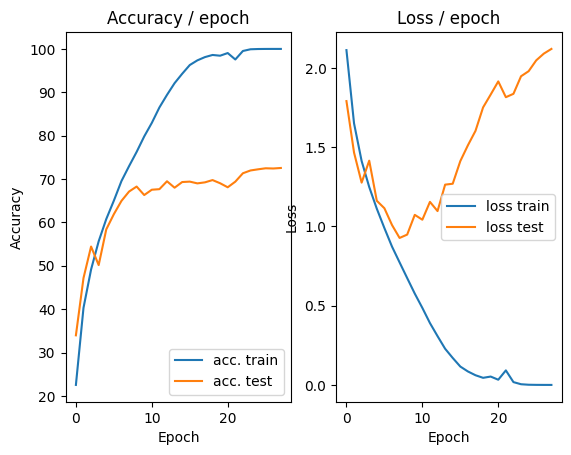

=== EPOCH 29 =====

[TRAIN Batch 000/391]	Time 0.172s (0.172s)	Loss 0.0003 (0.0003)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


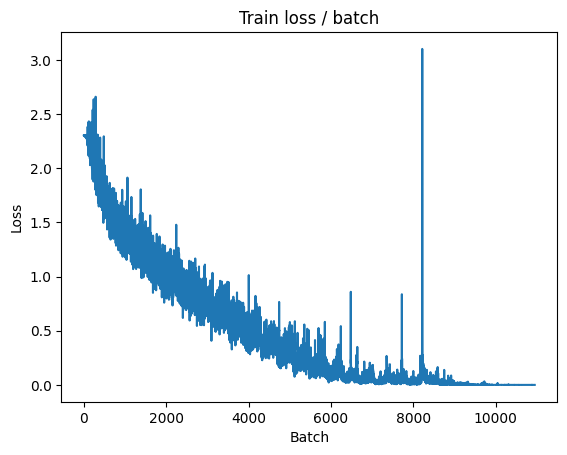

[TRAIN Batch 200/391]	Time 0.013s (0.024s)	Loss 0.0003 (0.0003)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


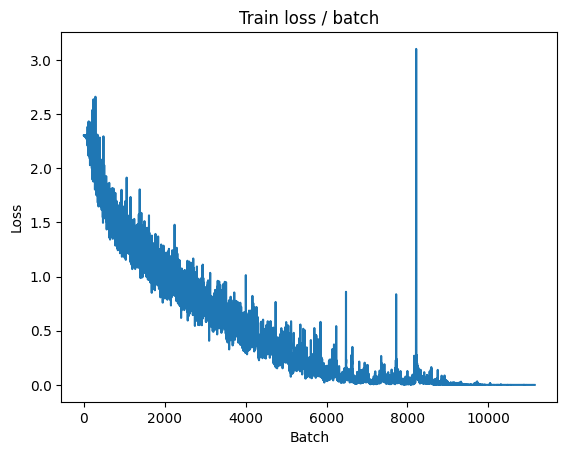


===============> Total time 9s	Avg loss 0.0003	Avg Prec@1 100.00 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.130s (0.130s)	Loss 2.7146 (2.7146)	Prec@1  75.0 ( 75.0)	Prec@5  95.3 ( 95.3)

===============> Total time 2s	Avg loss 2.1488	Avg Prec@1 72.49 %	Avg Prec@5 97.46 %



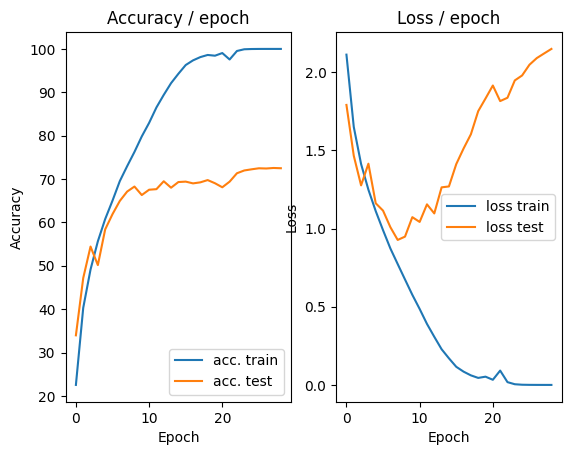

=== EPOCH 30 =====

[TRAIN Batch 000/391]	Time 0.250s (0.250s)	Loss 0.0002 (0.0002)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


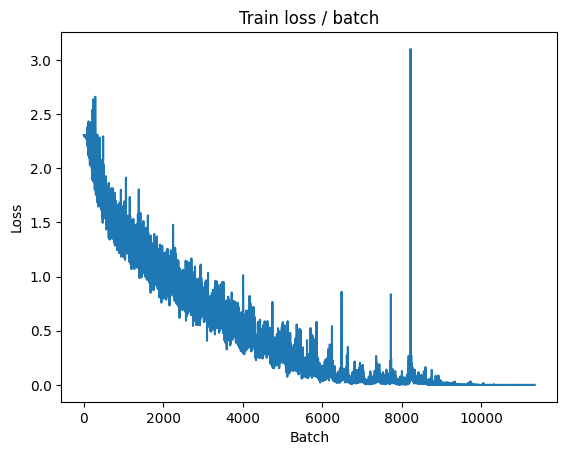

[TRAIN Batch 200/391]	Time 0.018s (0.028s)	Loss 0.0001 (0.0002)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


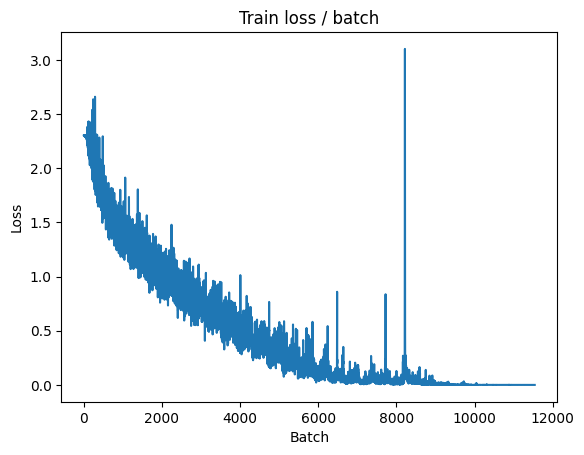


===============> Total time 9s	Avg loss 0.0002	Avg Prec@1 100.00 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.137s (0.137s)	Loss 2.7363 (2.7363)	Prec@1  75.0 ( 75.0)	Prec@5  95.3 ( 95.3)

===============> Total time 1s	Avg loss 2.1763	Avg Prec@1 72.44 %	Avg Prec@5 97.45 %



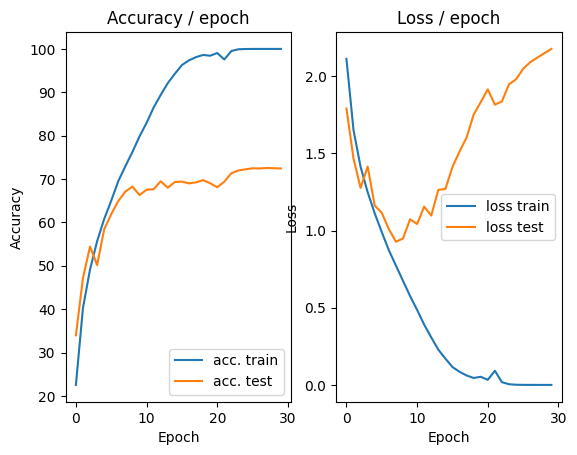

In [ ]:
main(128, 0.1, epochs=30, cuda=True)

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler

# Trial 1: My first attempt!

In [ ]:
class ConvNet(nn.Module):
    """
    Cette classe contient la structure du réseau de neurones
    """

    def __init__(self):
        super(ConvNet, self).__init__()
        # On défini d'abord les couches de convolution et de pooling comme un
        # groupe de couches `self.features`
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
        )
        # On défini les couches fully connected comme un groupe de couches
        # `self.classifier`
        self.classifier = nn.Sequential(
            nn.Linear(4*4*64, 1000),
            nn.ReLU(),
            nn.Linear(1000, 10),
            # Rappel : Le softmax est inclus dans la loss, ne pas le mettre ici
        )

    # méthode appelée quand on applique le réseau à un batch d'input
    def forward(self, input):
        bsize = input.size(0) # taille du batch
        output = self.features(input) # on calcule la sortie des conv
        output = output.view(bsize, -1) # on applati les feature map 2D en un
                                        # vecteur 1D pour chaque input
        output = self.classifier(output) # on calcule la sortie des fc
        return output



def get_dataset(batch_size, cuda=False):
    """
    Cette fonction charge le dataset et effectue des transformations sur chaqu
    image (listées dans `transform=...`).
    """
    train_dataset = datasets.CIFAR10(PATH, train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor()
        ]))
    test_dataset = datasets.CIFAR10(PATH, train=False, download=True,
        transform=transforms.Compose([
            transforms.ToTensor()
        ]))

    inds = list(range(len(train_dataset)))
    np.random.seed(0)
    np.random.shuffle(inds)
    train_idx, valid_idx = inds[5000:], inds[:5000]
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, pin_memory=cuda, num_workers=2, sampler=train_sampler)
    val_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, pin_memory=cuda, num_workers=2, sampler=val_sampler)
    test_loader = torch.utils.data.DataLoader(test_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader, test_loader



def epoch(data, model, criterion, optimizer=None, cuda=False):
    """
    Fait une passe (appelée epoch en anglais) sur les données `data` avec le
    modèle `model`. Evalue `criterion` comme loss.
    Si `optimizer` est fourni, effectue une epoch d'apprentissage en utilisant
    l'optimiseur donné, sinon, effectue une epoch d'évaluation (pas de backward)
    du modèle.
    """

    # indique si le modele est en mode eval ou train (certaines couches se
    # comportent différemment en train et en eval)
    model.eval() if optimizer is None else model.train()

    # objets pour stocker les moyennes des metriques
    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()
    global loss_plot

    # on itere sur les batchs du dataset
    tic = time.time()
    for i, (input, target) in enumerate(data):

        if cuda: # si on fait du GPU, passage en CUDA
            input = input.cuda()
            target = target.cuda()

        # forward
        output = model(input)
        loss = criterion(output, target)

        # backward si on est en "train"
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # calcul des metriques
        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        # mise a jour des moyennes
        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)
        if optimizer:
            loss_plot.update(avg_loss.val)
        # affichage des infos
        if i % PRINT_INTERVAL == 0:
            print('[{0:s} Batch {1:03d}/{2:03d}]\t'
                  'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:5.1f} ({top1.avg:5.1f})\t'
                  'Prec@5 {top5.val:5.1f} ({top5.avg:5.1f})'.format(
                   "EVAL" if optimizer is None else "TRAIN", i, len(data), batch_time=avg_batch_time, loss=avg_loss,
                   top1=avg_top1_acc, top5=avg_top5_acc))
            if optimizer:
                loss_plot.plot()

    # Affichage des infos sur l'epoch
    print('\n===============> Total time {batch_time:d}s\t'
          'Avg loss {loss.avg:.4f}\t'
          'Avg Prec@1 {top1.avg:5.2f} %\t'
          'Avg Prec@5 {top5.avg:5.2f} %\n'.format(
           batch_time=int(avg_batch_time.sum), loss=avg_loss,
           top1=avg_top1_acc, top5=avg_top5_acc))

    return avg_top1_acc, avg_top5_acc, avg_loss


def main(batch_size=128, lr=0.1, epochs=5, cuda=False):

    # ex de params :
    #   {"batch_size": 128, "epochs": 5, "lr": 0.1}

    # define model, loss, optim
    model = ConvNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, momentum=0.9)

    if cuda: # si on fait du GPU, passage en CUDA
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # On récupère les données
    train, val, test = get_dataset(batch_size, cuda)

    # init plots
    plot = AccLossPlot()
    global loss_plot
    loss_plot = TrainLossPlot()

    # On itère sur les epochs
    for i in range(epochs):
        print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")
        # Phase de train
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        # Phase de validation
        top1_acc_val, top5_acc_val, loss_val = epoch(val, model, criterion, cuda=cuda)
        # Phase d'evaluation
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)
        # plot
        plot.update(loss.avg, loss_val.avg, top1_acc.avg, top1_acc_val.avg)
    print("Final perfomance is {}".format(top1_acc_test))

Files already downloaded and verified
Files already downloaded and verified
=== EPOCH 1 =====

[TRAIN Batch 000/352]	Time 0.480s (0.480s)	Loss 2.3030 (2.3030)	Prec@1  11.7 ( 11.7)	Prec@5  49.2 ( 49.2)


<Figure size 640x480 with 0 Axes>

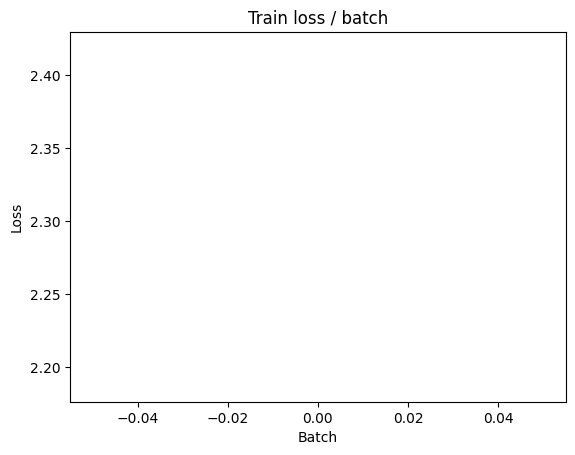

[TRAIN Batch 200/352]	Time 0.057s (0.028s)	Loss 2.3091 (2.2830)	Prec@1   8.6 ( 13.3)	Prec@5  53.1 ( 57.5)


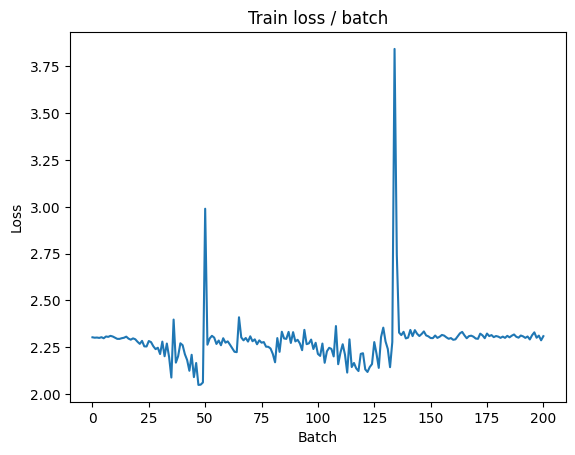


===============> Total time 10s	Avg loss 2.2927	Avg Prec@1 11.80 %	Avg Prec@5 54.12 %

[EVAL Batch 000/040]	Time 0.146s (0.146s)	Loss 2.3059 (2.3059)	Prec@1   7.8 (  7.8)	Prec@5  48.4 ( 48.4)

===============> Total time 0s	Avg loss 2.3049	Avg Prec@1  9.43 %	Avg Prec@5 49.79 %

[EVAL Batch 000/079]	Time 0.118s (0.118s)	Loss 2.3106 (2.3106)	Prec@1   7.8 (  7.8)	Prec@5  46.1 ( 46.1)

===============> Total time 1s	Avg loss 2.3041	Avg Prec@1  9.96 %	Avg Prec@5 50.07 %



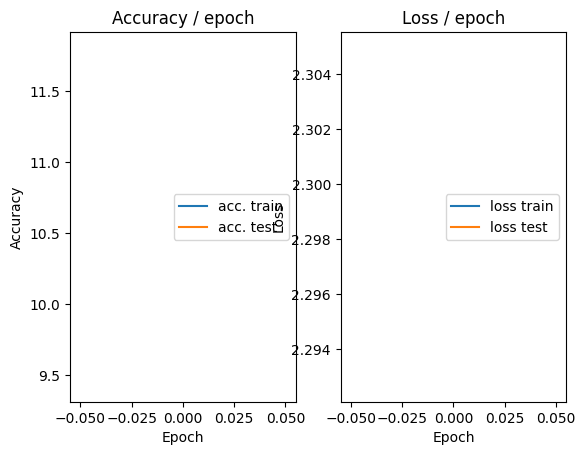

=== EPOCH 2 =====

[TRAIN Batch 000/352]	Time 0.243s (0.243s)	Loss 2.3063 (2.3063)	Prec@1  11.7 ( 11.7)	Prec@5  47.7 ( 47.7)


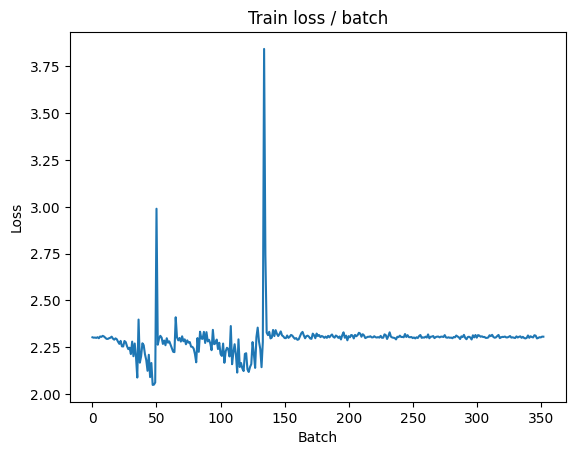

[TRAIN Batch 200/352]	Time 0.015s (0.025s)	Loss 2.3097 (2.3046)	Prec@1   8.6 ( 10.1)	Prec@5  50.0 ( 49.8)


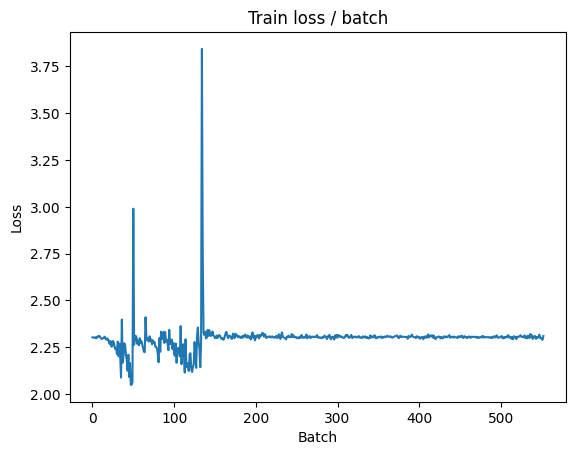


===============> Total time 10s	Avg loss 2.3044	Avg Prec@1 10.10 %	Avg Prec@5 50.40 %

[EVAL Batch 000/040]	Time 0.155s (0.155s)	Loss 2.3016 (2.3016)	Prec@1  10.2 ( 10.2)	Prec@5  56.2 ( 56.2)

===============> Total time 0s	Avg loss 2.3029	Avg Prec@1 10.39 %	Avg Prec@5 50.66 %

[EVAL Batch 000/079]	Time 0.127s (0.127s)	Loss 2.3023 (2.3023)	Prec@1  10.2 ( 10.2)	Prec@5  48.4 ( 48.4)

===============> Total time 1s	Avg loss 2.3033	Avg Prec@1 10.03 %	Avg Prec@5 49.79 %



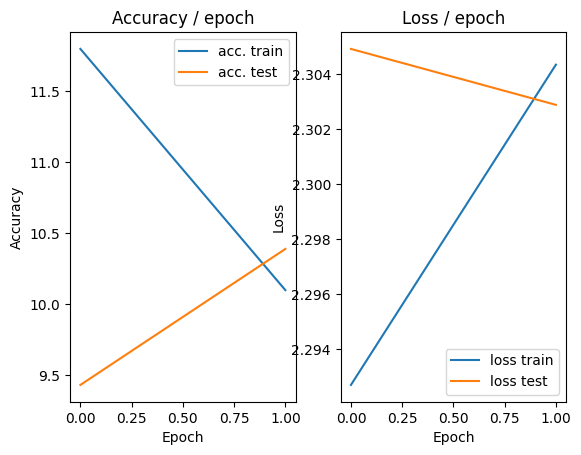

=== EPOCH 3 =====

[TRAIN Batch 000/352]	Time 0.465s (0.465s)	Loss 2.3076 (2.3076)	Prec@1  10.2 ( 10.2)	Prec@5  44.5 ( 44.5)


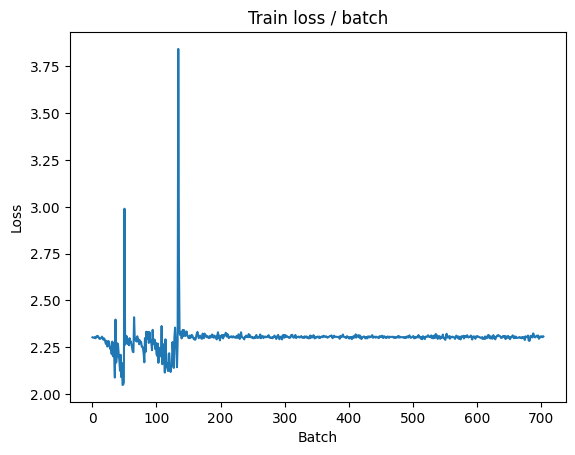

[TRAIN Batch 200/352]	Time 0.012s (0.025s)	Loss 2.3054 (2.3047)	Prec@1  10.2 (  9.9)	Prec@5  50.0 ( 49.9)


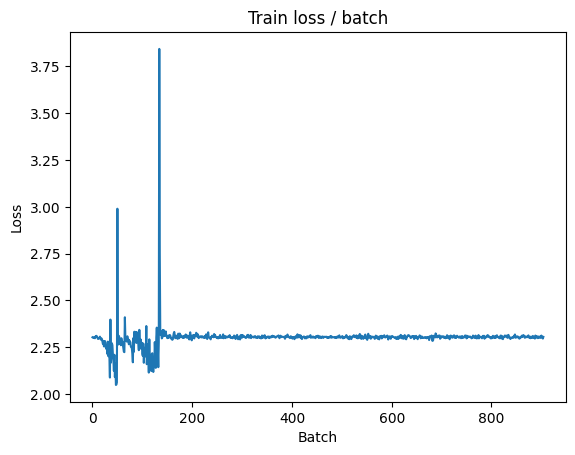


===============> Total time 10s	Avg loss 2.3044	Avg Prec@1  9.84 %	Avg Prec@5 50.01 %

[EVAL Batch 000/040]	Time 0.218s (0.218s)	Loss 2.2992 (2.2992)	Prec@1  13.3 ( 13.3)	Prec@5  53.9 ( 53.9)

===============> Total time 1s	Avg loss 2.3058	Avg Prec@1  9.53 %	Avg Prec@5 48.67 %

[EVAL Batch 000/079]	Time 0.119s (0.119s)	Loss 2.3095 (2.3095)	Prec@1   7.8 (  7.8)	Prec@5  50.0 ( 50.0)

===============> Total time 1s	Avg loss 2.3044	Avg Prec@1  9.89 %	Avg Prec@5 50.07 %



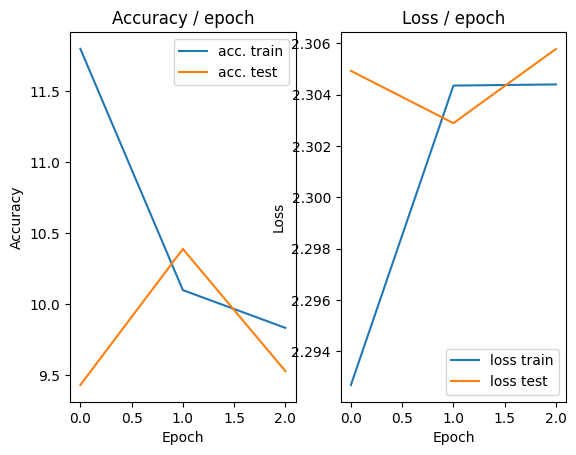

=== EPOCH 4 =====

[TRAIN Batch 000/352]	Time 0.246s (0.246s)	Loss 2.3069 (2.3069)	Prec@1   8.6 (  8.6)	Prec@5  52.3 ( 52.3)


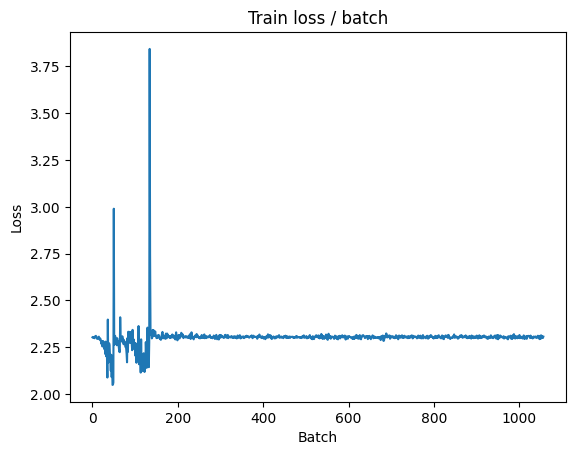

[TRAIN Batch 200/352]	Time 0.014s (0.025s)	Loss 2.2981 (2.3046)	Prec@1  13.3 (  9.8)	Prec@5  57.8 ( 50.0)


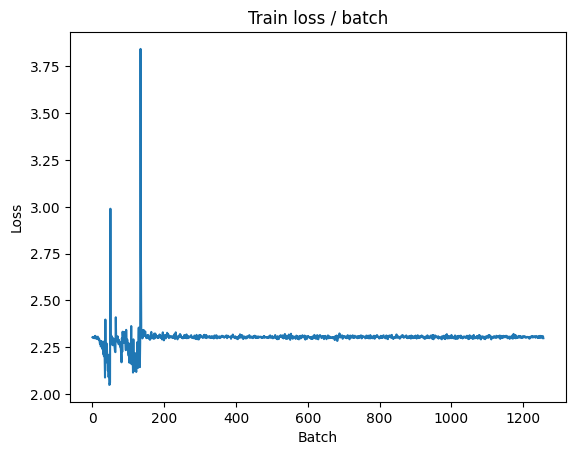


===============> Total time 9s	Avg loss 2.3044	Avg Prec@1  9.77 %	Avg Prec@5 49.98 %

[EVAL Batch 000/040]	Time 0.229s (0.229s)	Loss 2.3018 (2.3018)	Prec@1   8.6 (  8.6)	Prec@5  52.3 ( 52.3)

===============> Total time 1s	Avg loss 2.3035	Avg Prec@1 10.18 %	Avg Prec@5 50.92 %

[EVAL Batch 000/079]	Time 0.214s (0.214s)	Loss 2.2994 (2.2994)	Prec@1  14.8 ( 14.8)	Prec@5  50.0 ( 50.0)

===============> Total time 1s	Avg loss 2.3038	Avg Prec@1  9.89 %	Avg Prec@5 50.00 %



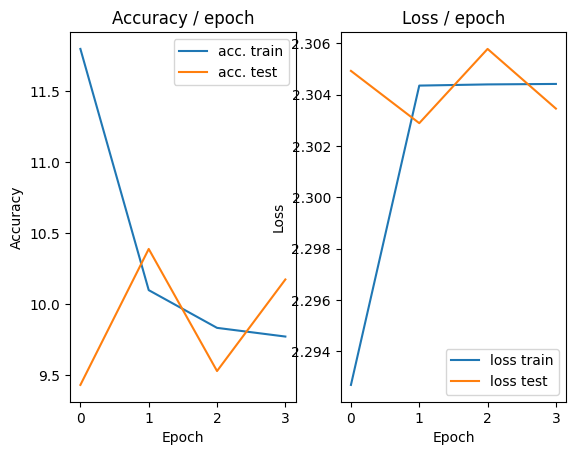

=== EPOCH 5 =====

[TRAIN Batch 000/352]	Time 0.233s (0.233s)	Loss 2.2979 (2.2979)	Prec@1  14.1 ( 14.1)	Prec@5  54.7 ( 54.7)


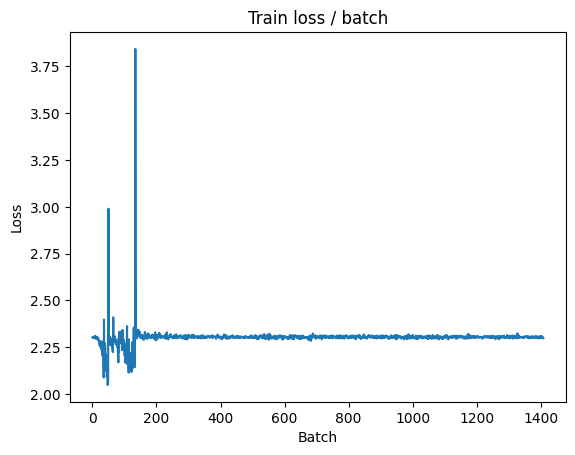

[TRAIN Batch 200/352]	Time 0.013s (0.025s)	Loss 2.3026 (2.3041)	Prec@1  10.9 ( 10.0)	Prec@5  49.2 ( 50.3)


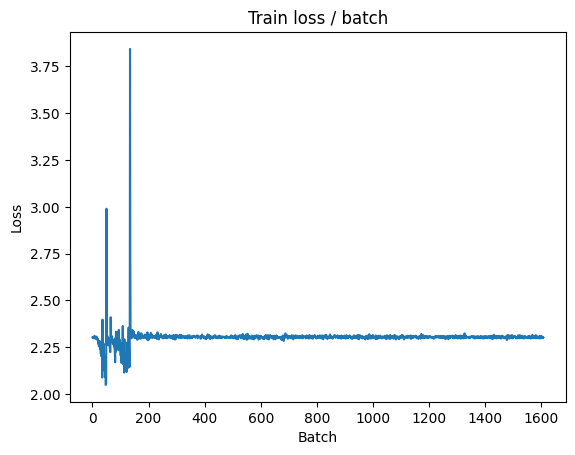


===============> Total time 8s	Avg loss 2.3040	Avg Prec@1  9.97 %	Avg Prec@5 50.17 %

[EVAL Batch 000/040]	Time 0.185s (0.185s)	Loss 2.3044 (2.3044)	Prec@1   8.6 (  8.6)	Prec@5  54.7 ( 54.7)

===============> Total time 1s	Avg loss 2.3043	Avg Prec@1 10.10 %	Avg Prec@5 49.65 %

[EVAL Batch 000/079]	Time 0.173s (0.173s)	Loss 2.2993 (2.2993)	Prec@1   8.6 (  8.6)	Prec@5  55.5 ( 55.5)

===============> Total time 2s	Avg loss 2.3038	Avg Prec@1  9.96 %	Avg Prec@5 49.86 %



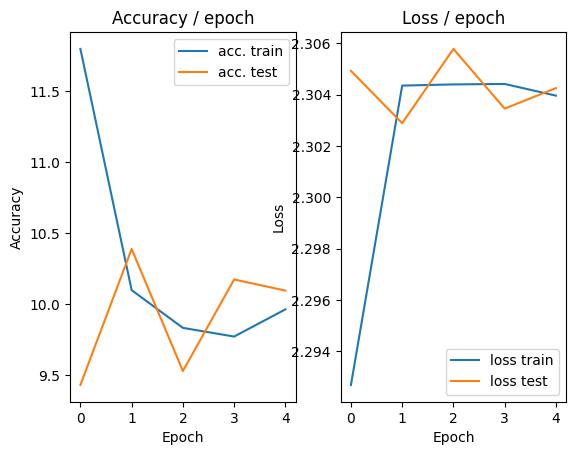

=== EPOCH 6 =====

[TRAIN Batch 000/352]	Time 0.487s (0.487s)	Loss 2.3043 (2.3043)	Prec@1   9.4 (  9.4)	Prec@5  49.2 ( 49.2)


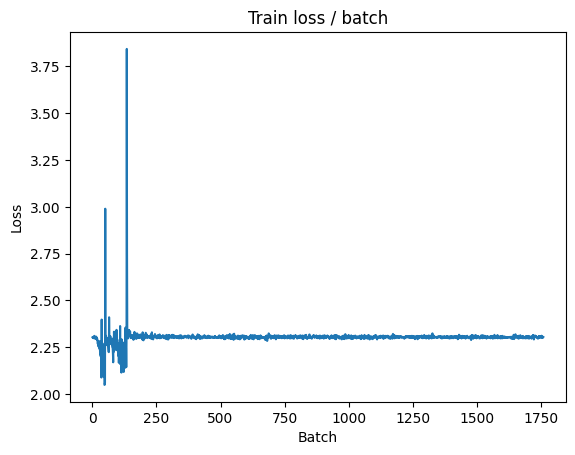

[TRAIN Batch 200/352]	Time 0.026s (0.026s)	Loss 2.3062 (2.3042)	Prec@1  12.5 (  9.9)	Prec@5  50.8 ( 50.2)


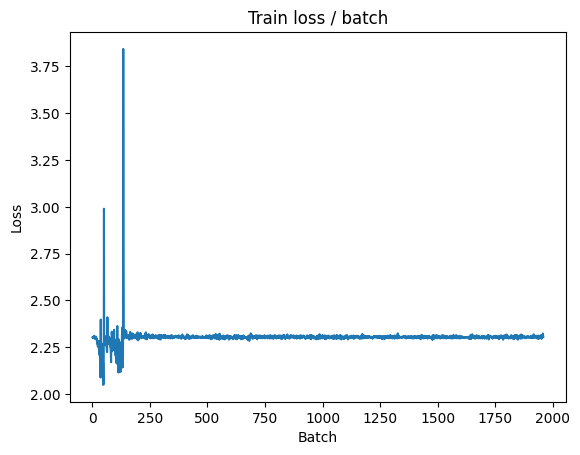


===============> Total time 8s	Avg loss 2.3044	Avg Prec@1 10.03 %	Avg Prec@5 50.01 %

[EVAL Batch 000/040]	Time 0.147s (0.147s)	Loss 2.2942 (2.2942)	Prec@1  14.8 ( 14.8)	Prec@5  54.7 ( 54.7)

===============> Total time 0s	Avg loss 2.3046	Avg Prec@1  9.82 %	Avg Prec@5 48.85 %

[EVAL Batch 000/079]	Time 0.135s (0.135s)	Loss 2.3070 (2.3070)	Prec@1  10.2 ( 10.2)	Prec@5  51.6 ( 51.6)

===============> Total time 2s	Avg loss 2.3048	Avg Prec@1 10.03 %	Avg Prec@5 49.86 %



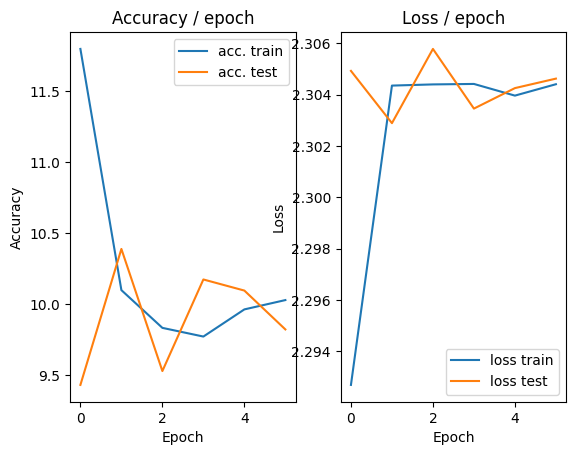

=== EPOCH 7 =====

[TRAIN Batch 000/352]	Time 0.354s (0.354s)	Loss 2.2915 (2.2915)	Prec@1  14.1 ( 14.1)	Prec@5  57.0 ( 57.0)


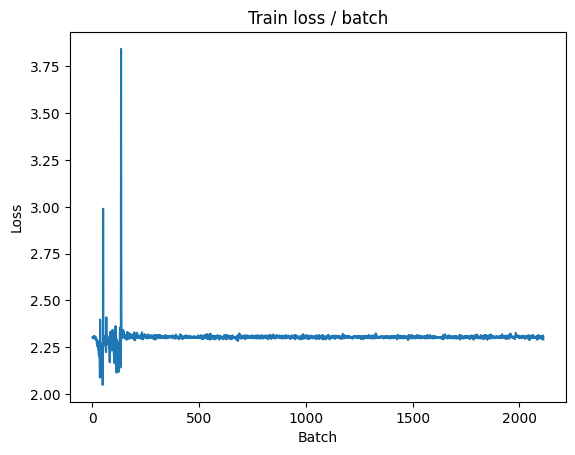

[TRAIN Batch 200/352]	Time 0.018s (0.026s)	Loss 2.3100 (2.3046)	Prec@1   8.6 ( 10.1)	Prec@5  45.3 ( 50.1)


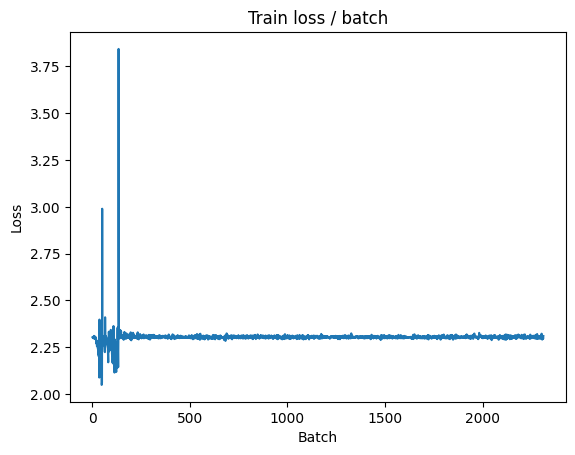


===============> Total time 8s	Avg loss 2.3045	Avg Prec@1 10.14 %	Avg Prec@5 50.02 %

[EVAL Batch 000/040]	Time 0.139s (0.139s)	Loss 2.3026 (2.3026)	Prec@1  10.9 ( 10.9)	Prec@5  56.2 ( 56.2)

===============> Total time 0s	Avg loss 2.3041	Avg Prec@1  9.53 %	Avg Prec@5 49.38 %

[EVAL Batch 000/079]	Time 0.123s (0.123s)	Loss 2.3014 (2.3014)	Prec@1   7.8 (  7.8)	Prec@5  50.8 ( 50.8)

===============> Total time 1s	Avg loss 2.3037	Avg Prec@1  9.89 %	Avg Prec@5 50.07 %



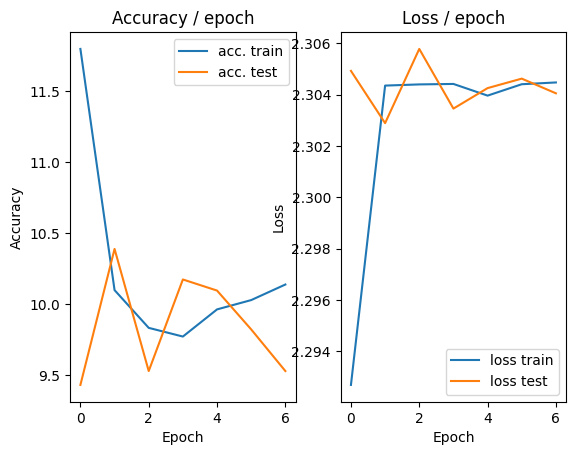

=== EPOCH 8 =====

[TRAIN Batch 000/352]	Time 0.670s (0.670s)	Loss 2.3061 (2.3061)	Prec@1   6.2 (  6.2)	Prec@5  45.3 ( 45.3)


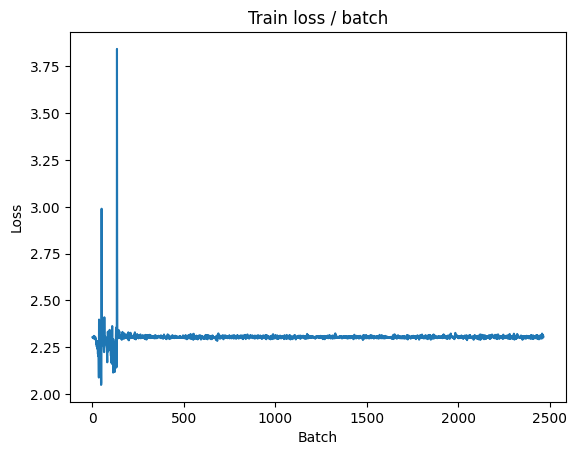

[TRAIN Batch 200/352]	Time 0.014s (0.030s)	Loss 2.3053 (2.3044)	Prec@1   5.5 (  9.8)	Prec@5  48.4 ( 50.1)


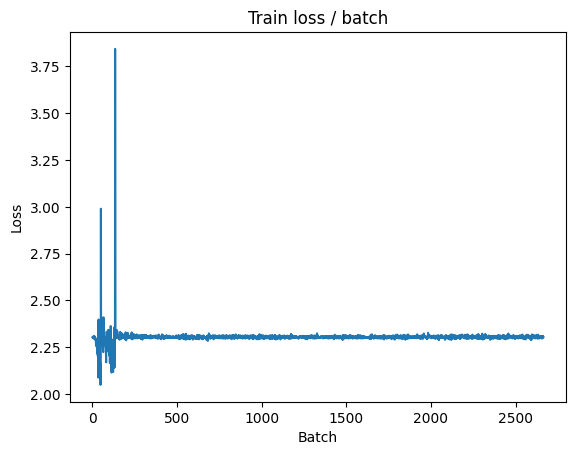


===============> Total time 9s	Avg loss 2.3048	Avg Prec@1  9.88 %	Avg Prec@5 49.99 %

[EVAL Batch 000/040]	Time 0.151s (0.151s)	Loss 2.3071 (2.3071)	Prec@1   8.6 (  8.6)	Prec@5  53.1 ( 53.1)

===============> Total time 0s	Avg loss 2.3028	Avg Prec@1  9.80 %	Avg Prec@5 51.91 %

[EVAL Batch 000/079]	Time 0.127s (0.127s)	Loss 2.3046 (2.3046)	Prec@1   8.6 (  8.6)	Prec@5  46.1 ( 46.1)

===============> Total time 1s	Avg loss 2.3039	Avg Prec@1  9.96 %	Avg Prec@5 50.14 %



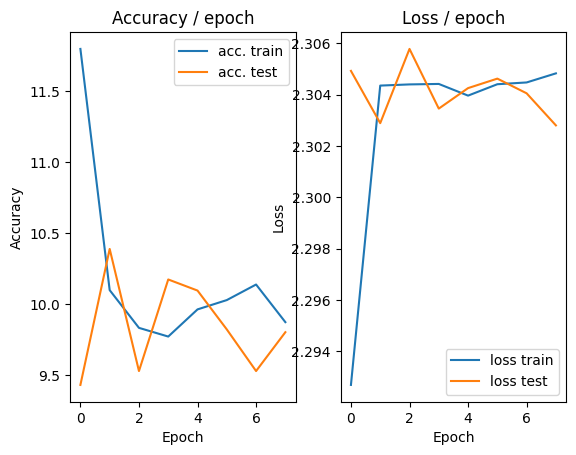

=== EPOCH 9 =====

[TRAIN Batch 000/352]	Time 0.231s (0.231s)	Loss 2.3046 (2.3046)	Prec@1   7.0 (  7.0)	Prec@5  53.1 ( 53.1)


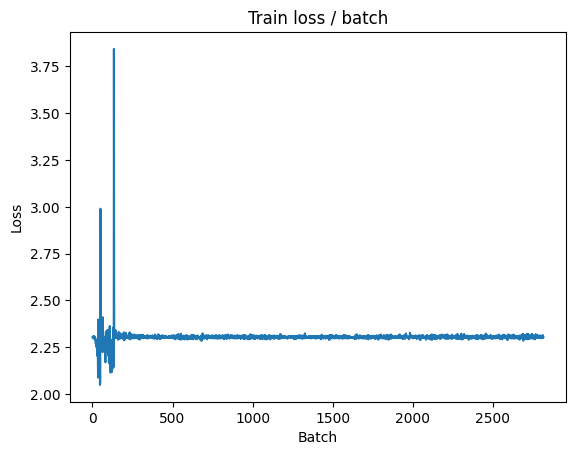

[TRAIN Batch 200/352]	Time 0.019s (0.032s)	Loss 2.3032 (2.3044)	Prec@1  10.2 ( 10.0)	Prec@5  50.8 ( 49.8)


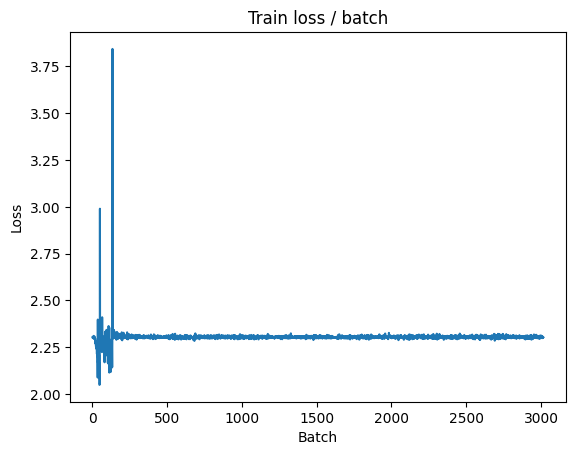


===============> Total time 10s	Avg loss 2.3046	Avg Prec@1 10.03 %	Avg Prec@5 49.90 %

[EVAL Batch 000/040]	Time 0.157s (0.157s)	Loss 2.3114 (2.3114)	Prec@1  10.2 ( 10.2)	Prec@5  44.5 ( 44.5)

===============> Total time 0s	Avg loss 2.3060	Avg Prec@1  9.53 %	Avg Prec@5 49.77 %

[EVAL Batch 000/079]	Time 0.129s (0.129s)	Loss 2.3062 (2.3062)	Prec@1   7.8 (  7.8)	Prec@5  51.6 ( 51.6)

===============> Total time 1s	Avg loss 2.3050	Avg Prec@1  9.89 %	Avg Prec@5 50.07 %



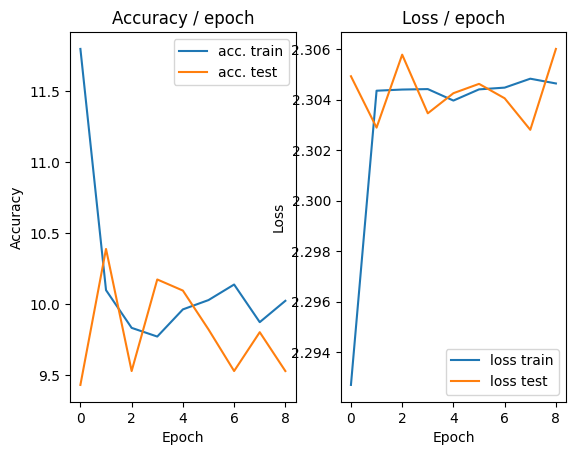

=== EPOCH 10 =====

[TRAIN Batch 000/352]	Time 0.495s (0.495s)	Loss 2.3126 (2.3126)	Prec@1   7.8 (  7.8)	Prec@5  50.8 ( 50.8)


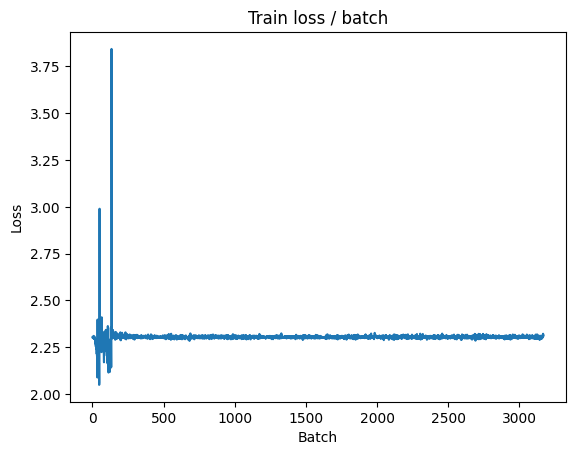

[TRAIN Batch 200/352]	Time 0.017s (0.034s)	Loss 2.3050 (2.3044)	Prec@1  10.9 (  9.8)	Prec@5  46.9 ( 50.0)


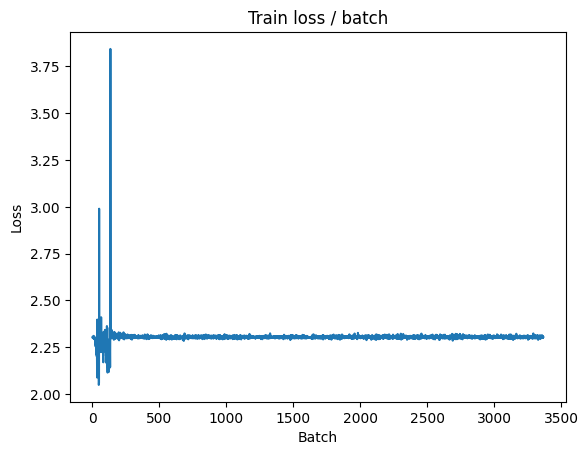


===============> Total time 12s	Avg loss 2.3043	Avg Prec@1  9.97 %	Avg Prec@5 50.20 %

[EVAL Batch 000/040]	Time 0.148s (0.148s)	Loss 2.3138 (2.3138)	Prec@1   7.0 (  7.0)	Prec@5  50.8 ( 50.8)

===============> Total time 0s	Avg loss 2.3085	Avg Prec@1  9.24 %	Avg Prec@5 48.30 %

[EVAL Batch 000/079]	Time 0.143s (0.143s)	Loss 2.3075 (2.3075)	Prec@1   7.8 (  7.8)	Prec@5  50.0 ( 50.0)

===============> Total time 1s	Avg loss 2.3063	Avg Prec@1  9.89 %	Avg Prec@5 49.65 %



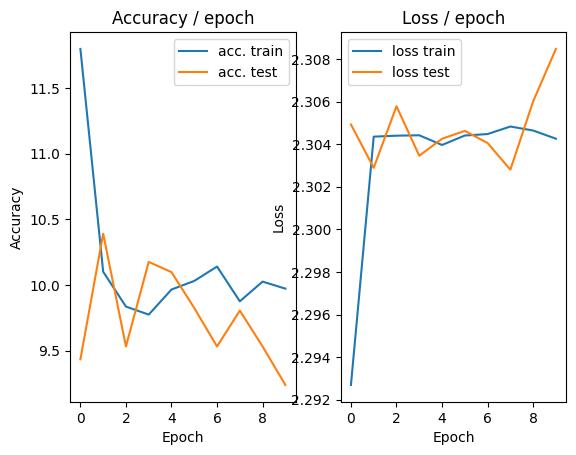

=== EPOCH 11 =====

[TRAIN Batch 000/352]	Time 0.218s (0.218s)	Loss 2.3074 (2.3074)	Prec@1   8.6 (  8.6)	Prec@5  46.9 ( 46.9)


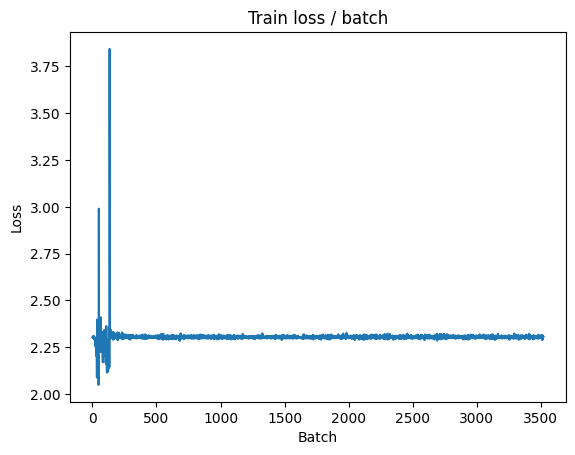

[TRAIN Batch 200/352]	Time 0.009s (0.032s)	Loss 2.3004 (2.3043)	Prec@1  10.2 (  9.9)	Prec@5  54.7 ( 50.0)


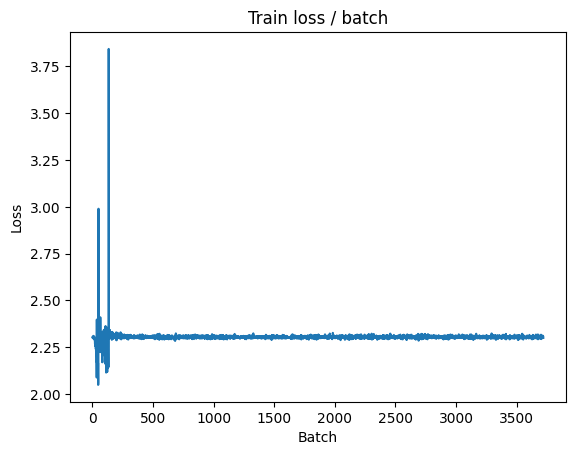


===============> Total time 10s	Avg loss 2.3044	Avg Prec@1  9.99 %	Avg Prec@5 50.03 %

[EVAL Batch 000/040]	Time 0.155s (0.155s)	Loss 2.3221 (2.3221)	Prec@1   9.4 (  9.4)	Prec@5  40.6 ( 40.6)

===============> Total time 0s	Avg loss 2.3054	Avg Prec@1  9.80 %	Avg Prec@5 49.02 %

[EVAL Batch 000/079]	Time 0.132s (0.132s)	Loss 2.3177 (2.3177)	Prec@1   8.6 (  8.6)	Prec@5  43.0 ( 43.0)

===============> Total time 1s	Avg loss 2.3056	Avg Prec@1  9.96 %	Avg Prec@5 49.72 %



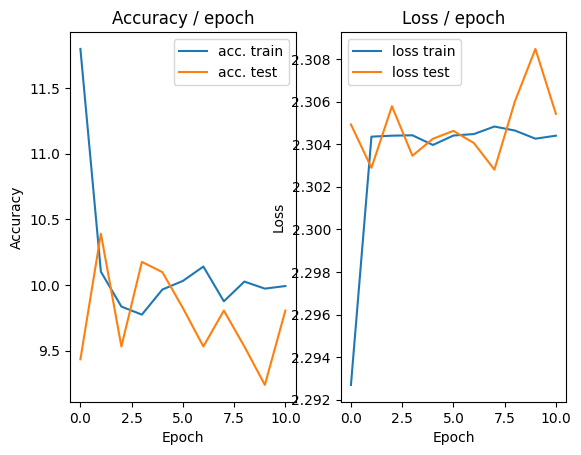

=== EPOCH 12 =====

[TRAIN Batch 000/352]	Time 0.496s (0.496s)	Loss 2.3154 (2.3154)	Prec@1  10.2 ( 10.2)	Prec@5  40.6 ( 40.6)


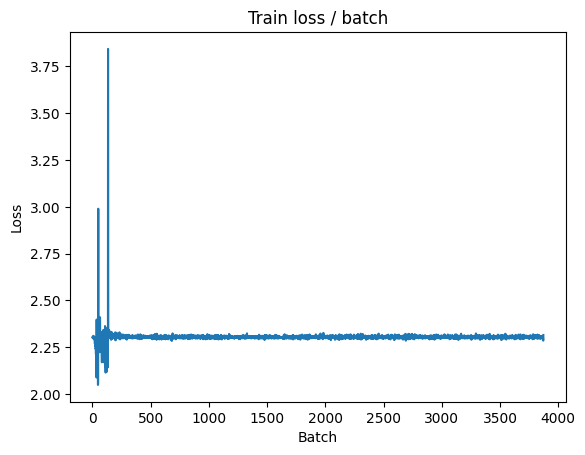

[TRAIN Batch 200/352]	Time 0.012s (0.034s)	Loss 2.3119 (2.3045)	Prec@1   7.0 (  9.7)	Prec@5  43.8 ( 49.9)


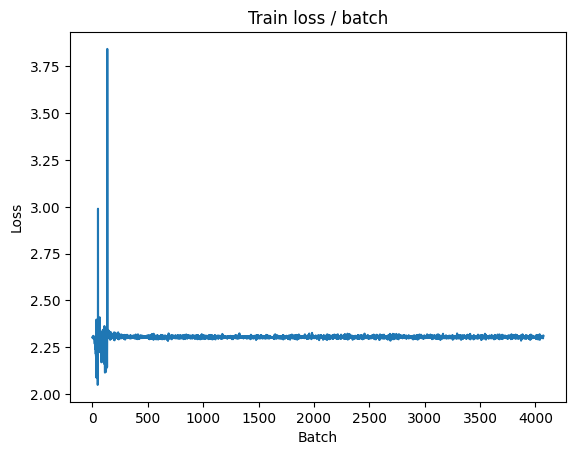


===============> Total time 10s	Avg loss 2.3046	Avg Prec@1  9.78 %	Avg Prec@5 49.65 %

[EVAL Batch 000/040]	Time 0.154s (0.154s)	Loss 2.3052 (2.3052)	Prec@1   8.6 (  8.6)	Prec@5  46.9 ( 46.9)

===============> Total time 0s	Avg loss 2.3041	Avg Prec@1  9.84 %	Avg Prec@5 48.77 %

[EVAL Batch 000/079]	Time 0.131s (0.131s)	Loss 2.3024 (2.3024)	Prec@1   8.6 (  8.6)	Prec@5  53.1 ( 53.1)

===============> Total time 1s	Avg loss 2.3037	Avg Prec@1  9.89 %	Avg Prec@5 49.72 %



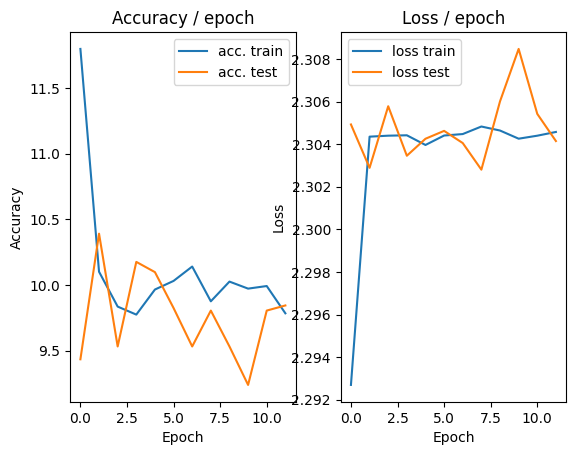

=== EPOCH 13 =====

[TRAIN Batch 000/352]	Time 0.496s (0.496s)	Loss 2.3128 (2.3128)	Prec@1   5.5 (  5.5)	Prec@5  38.3 ( 38.3)


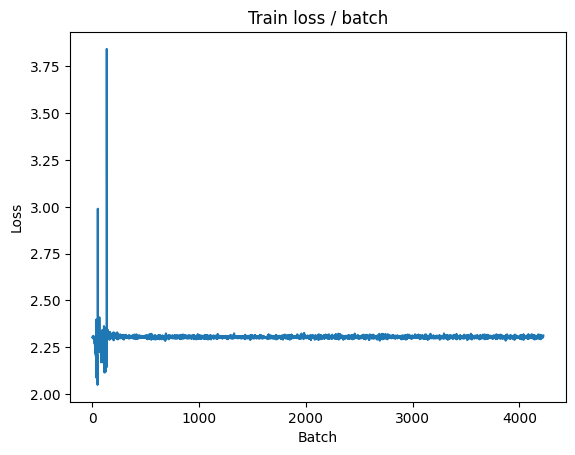

[TRAIN Batch 200/352]	Time 0.018s (0.032s)	Loss 2.3050 (2.3044)	Prec@1   7.8 ( 10.2)	Prec@5  49.2 ( 49.6)


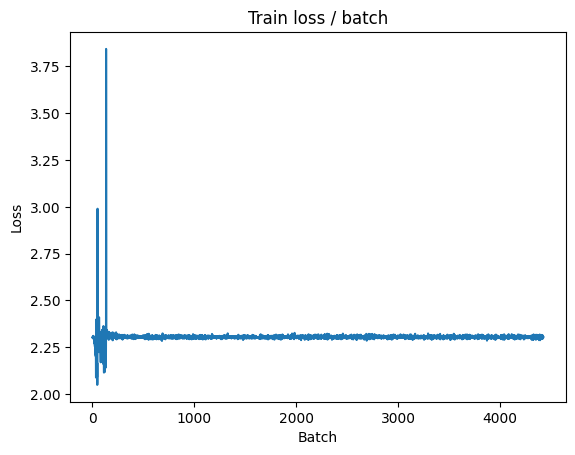


===============> Total time 10s	Avg loss 2.3045	Avg Prec@1 10.12 %	Avg Prec@5 49.49 %

[EVAL Batch 000/040]	Time 0.143s (0.143s)	Loss 2.2976 (2.2976)	Prec@1  13.3 ( 13.3)	Prec@5  51.6 ( 51.6)

===============> Total time 0s	Avg loss 2.3046	Avg Prec@1 10.29 %	Avg Prec@5 48.96 %

[EVAL Batch 000/079]	Time 0.140s (0.140s)	Loss 2.3033 (2.3033)	Prec@1  11.7 ( 11.7)	Prec@5  52.3 ( 52.3)

===============> Total time 1s	Avg loss 2.3041	Avg Prec@1 10.10 %	Avg Prec@5 49.86 %



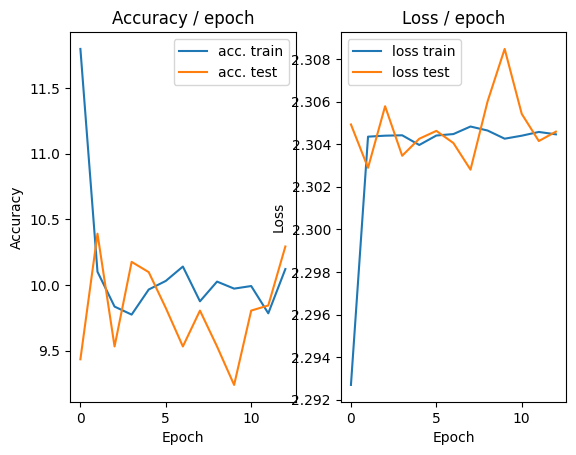

=== EPOCH 14 =====

[TRAIN Batch 000/352]	Time 0.247s (0.247s)	Loss 2.2960 (2.2960)	Prec@1   8.6 (  8.6)	Prec@5  60.9 ( 60.9)


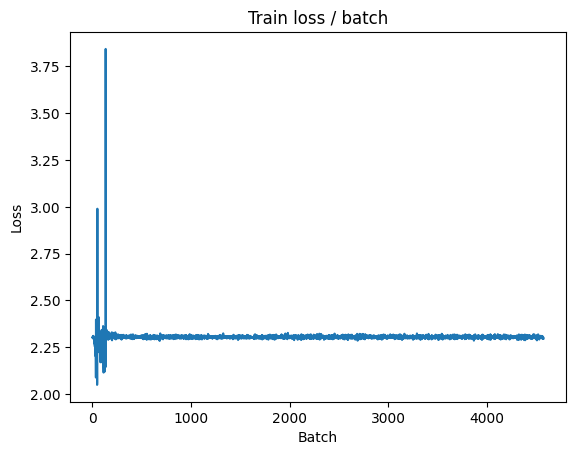

[TRAIN Batch 200/352]	Time 0.017s (0.026s)	Loss 2.3063 (2.3045)	Prec@1   6.2 (  9.9)	Prec@5  49.2 ( 49.8)


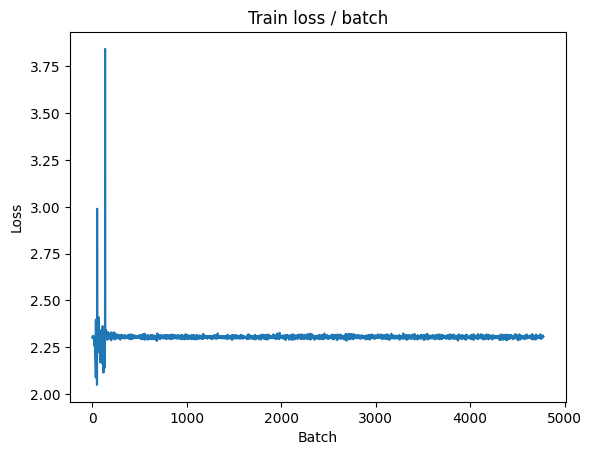


===============> Total time 10s	Avg loss 2.3045	Avg Prec@1  9.79 %	Avg Prec@5 50.06 %

[EVAL Batch 000/040]	Time 0.157s (0.157s)	Loss 2.2980 (2.2980)	Prec@1  10.2 ( 10.2)	Prec@5  53.1 ( 53.1)

===============> Total time 0s	Avg loss 2.3080	Avg Prec@1  9.51 %	Avg Prec@5 48.71 %

[EVAL Batch 000/079]	Time 0.135s (0.135s)	Loss 2.3092 (2.3092)	Prec@1   8.6 (  8.6)	Prec@5  48.4 ( 48.4)

===============> Total time 1s	Avg loss 2.3058	Avg Prec@1  9.96 %	Avg Prec@5 49.86 %



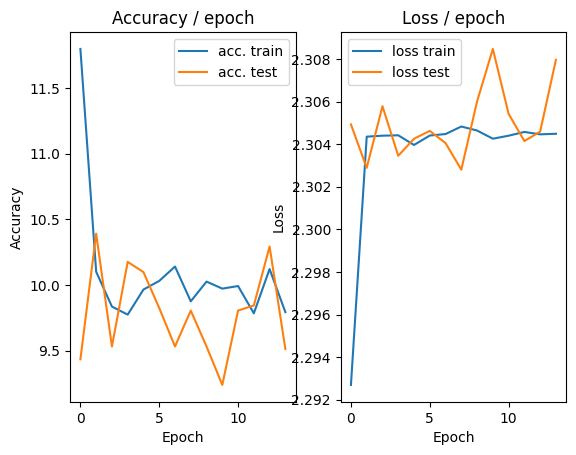

=== EPOCH 15 =====

[TRAIN Batch 000/352]	Time 0.486s (0.486s)	Loss 2.3000 (2.3000)	Prec@1  10.9 ( 10.9)	Prec@5  54.7 ( 54.7)


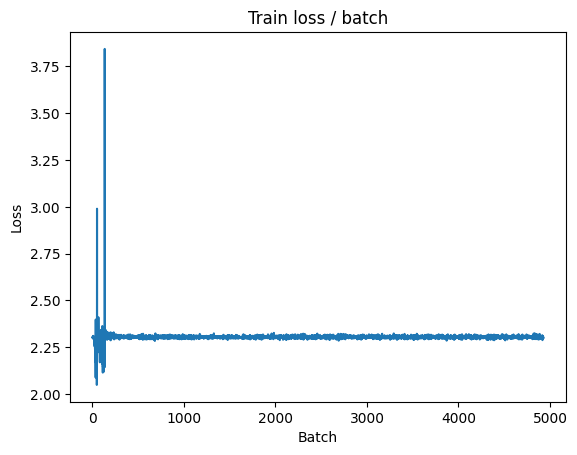

[TRAIN Batch 200/352]	Time 0.014s (0.025s)	Loss 2.3056 (2.3044)	Prec@1   9.4 ( 10.1)	Prec@5  47.7 ( 49.7)


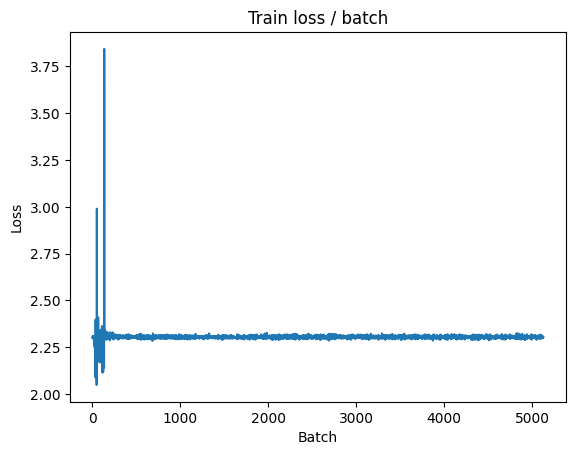


===============> Total time 10s	Avg loss 2.3045	Avg Prec@1 10.06 %	Avg Prec@5 49.73 %

[EVAL Batch 000/040]	Time 0.164s (0.164s)	Loss 2.3073 (2.3073)	Prec@1   8.6 (  8.6)	Prec@5  45.3 ( 45.3)

===============> Total time 0s	Avg loss 2.3040	Avg Prec@1 10.10 %	Avg Prec@5 50.68 %

[EVAL Batch 000/079]	Time 0.139s (0.139s)	Loss 2.2983 (2.2983)	Prec@1  10.2 ( 10.2)	Prec@5  57.0 ( 57.0)

===============> Total time 1s	Avg loss 2.3039	Avg Prec@1 10.10 %	Avg Prec@5 50.28 %



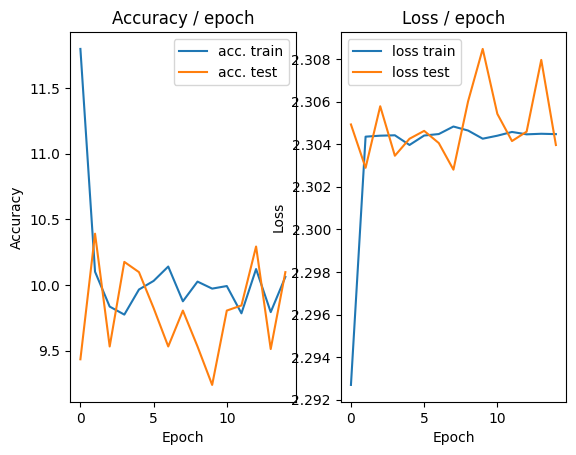

=== EPOCH 16 =====

[TRAIN Batch 000/352]	Time 0.247s (0.247s)	Loss 2.3015 (2.3015)	Prec@1  10.9 ( 10.9)	Prec@5  51.6 ( 51.6)


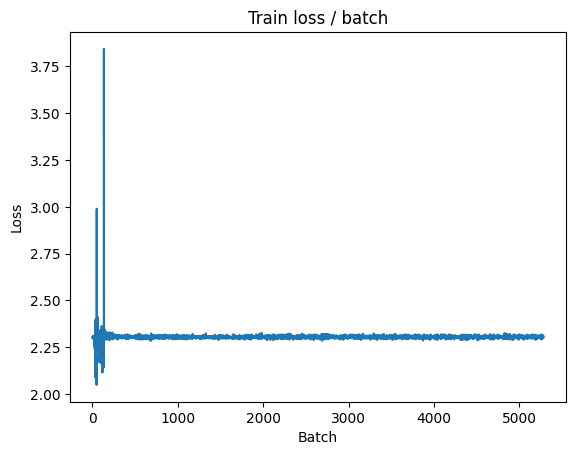

[TRAIN Batch 200/352]	Time 0.026s (0.024s)	Loss 2.3070 (2.3043)	Prec@1   8.6 ( 10.1)	Prec@5  45.3 ( 49.5)


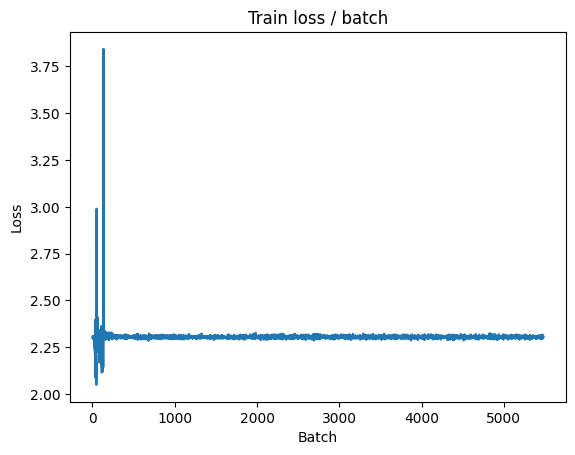


===============> Total time 9s	Avg loss 2.3047	Avg Prec@1 10.04 %	Avg Prec@5 49.34 %

[EVAL Batch 000/040]	Time 0.176s (0.176s)	Loss 2.3048 (2.3048)	Prec@1   7.0 (  7.0)	Prec@5  46.9 ( 46.9)

===============> Total time 1s	Avg loss 2.3042	Avg Prec@1  9.53 %	Avg Prec@5 49.39 %

[EVAL Batch 000/079]	Time 0.132s (0.132s)	Loss 2.3028 (2.3028)	Prec@1   7.8 (  7.8)	Prec@5  49.2 ( 49.2)

===============> Total time 1s	Avg loss 2.3037	Avg Prec@1  9.89 %	Avg Prec@5 49.65 %



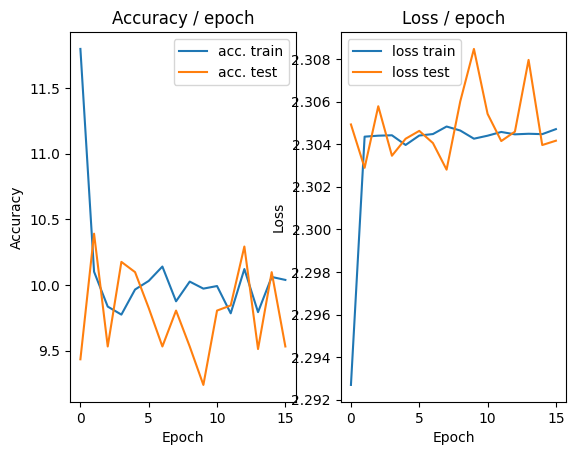

=== EPOCH 17 =====

[TRAIN Batch 000/352]	Time 0.506s (0.506s)	Loss 2.3031 (2.3031)	Prec@1  10.9 ( 10.9)	Prec@5  51.6 ( 51.6)


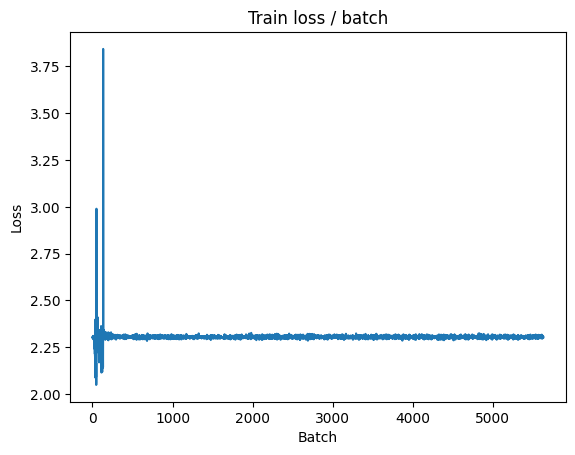

[TRAIN Batch 200/352]	Time 0.014s (0.026s)	Loss 2.3021 (2.3044)	Prec@1  10.9 (  9.7)	Prec@5  50.8 ( 50.0)


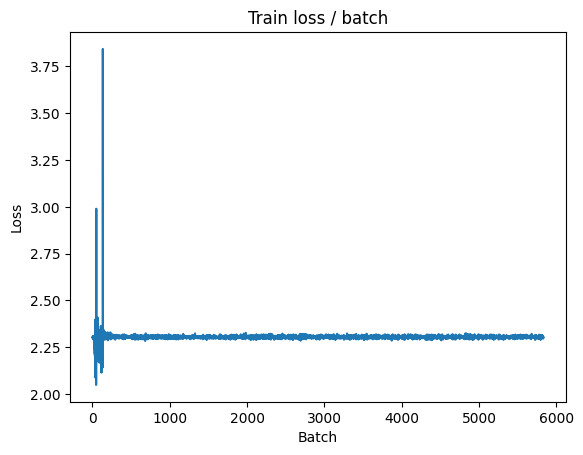


===============> Total time 9s	Avg loss 2.3044	Avg Prec@1  9.81 %	Avg Prec@5 49.95 %

[EVAL Batch 000/040]	Time 0.256s (0.256s)	Loss 2.3047 (2.3047)	Prec@1  10.2 ( 10.2)	Prec@5  51.6 ( 51.6)

===============> Total time 1s	Avg loss 2.3036	Avg Prec@1  9.51 %	Avg Prec@5 51.04 %

[EVAL Batch 000/079]	Time 0.238s (0.238s)	Loss 2.3086 (2.3086)	Prec@1   8.6 (  8.6)	Prec@5  46.1 ( 46.1)

===============> Total time 2s	Avg loss 2.3041	Avg Prec@1  9.96 %	Avg Prec@5 50.14 %



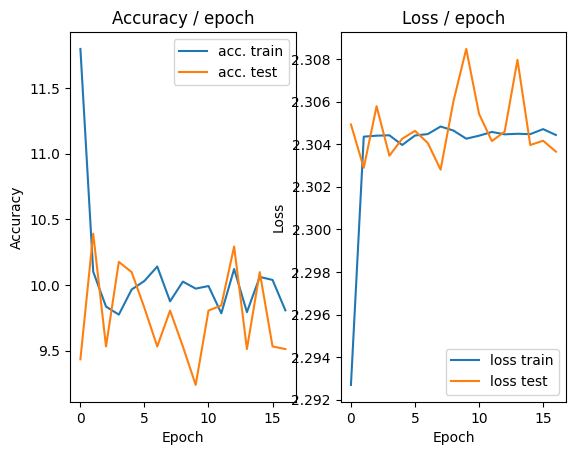

=== EPOCH 18 =====

[TRAIN Batch 000/352]	Time 0.248s (0.248s)	Loss 2.3096 (2.3096)	Prec@1  10.9 ( 10.9)	Prec@5  45.3 ( 45.3)


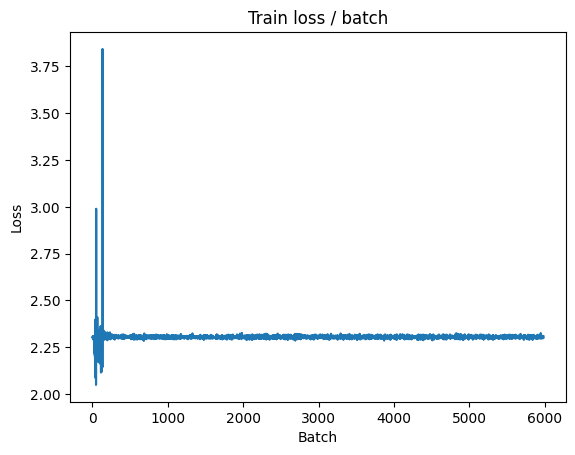

[TRAIN Batch 200/352]	Time 0.027s (0.024s)	Loss 2.3056 (2.3044)	Prec@1  10.9 ( 10.0)	Prec@5  50.0 ( 49.7)


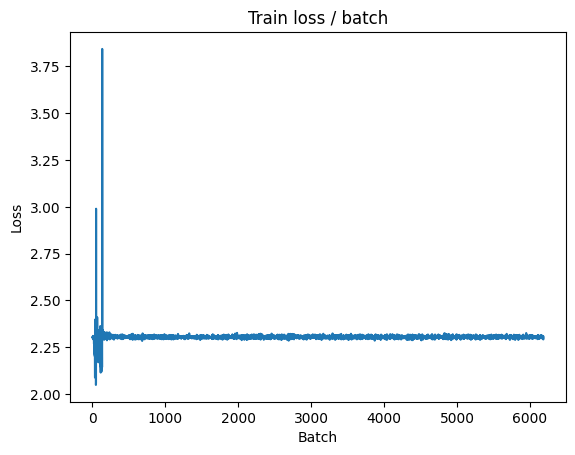


===============> Total time 8s	Avg loss 2.3043	Avg Prec@1  9.98 %	Avg Prec@5 49.69 %

[EVAL Batch 000/040]	Time 0.159s (0.159s)	Loss 2.3020 (2.3020)	Prec@1  10.2 ( 10.2)	Prec@5  51.6 ( 51.6)

===============> Total time 1s	Avg loss 2.3042	Avg Prec@1 10.12 %	Avg Prec@5 50.12 %

[EVAL Batch 000/079]	Time 0.220s (0.220s)	Loss 2.3021 (2.3021)	Prec@1  10.2 ( 10.2)	Prec@5  53.1 ( 53.1)

===============> Total time 2s	Avg loss 2.3048	Avg Prec@1 10.03 %	Avg Prec@5 49.93 %



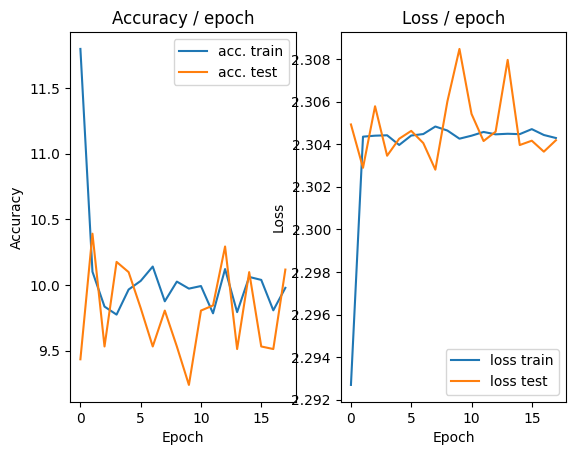

=== EPOCH 19 =====

[TRAIN Batch 000/352]	Time 0.543s (0.543s)	Loss 2.3028 (2.3028)	Prec@1  10.9 ( 10.9)	Prec@5  53.1 ( 53.1)


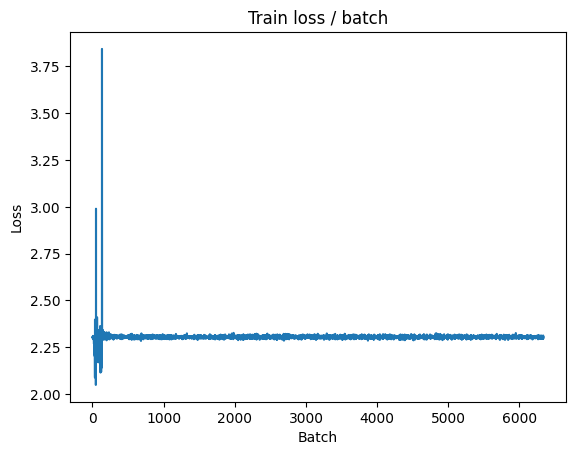

[TRAIN Batch 200/352]	Time 0.009s (0.026s)	Loss 2.2993 (2.3047)	Prec@1   9.4 (  9.9)	Prec@5  51.6 ( 49.9)


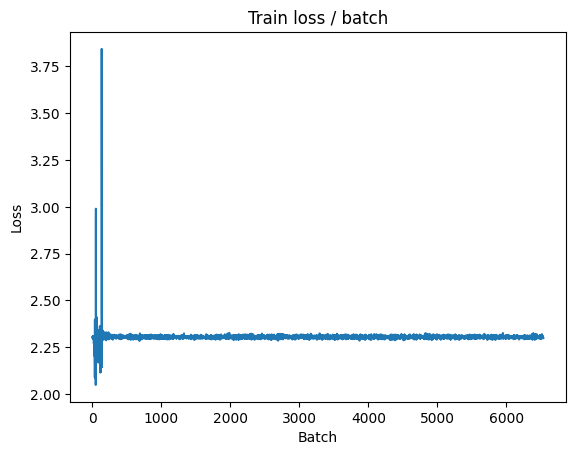


===============> Total time 8s	Avg loss 2.3045	Avg Prec@1 10.02 %	Avg Prec@5 49.81 %

[EVAL Batch 000/040]	Time 0.159s (0.159s)	Loss 2.2977 (2.2977)	Prec@1  12.5 ( 12.5)	Prec@5  58.6 ( 58.6)

===============> Total time 0s	Avg loss 2.3037	Avg Prec@1  9.84 %	Avg Prec@5 51.41 %

[EVAL Batch 000/079]	Time 0.138s (0.138s)	Loss 2.3054 (2.3054)	Prec@1   8.6 (  8.6)	Prec@5  50.8 ( 50.8)

===============> Total time 2s	Avg loss 2.3041	Avg Prec@1  9.89 %	Avg Prec@5 49.93 %



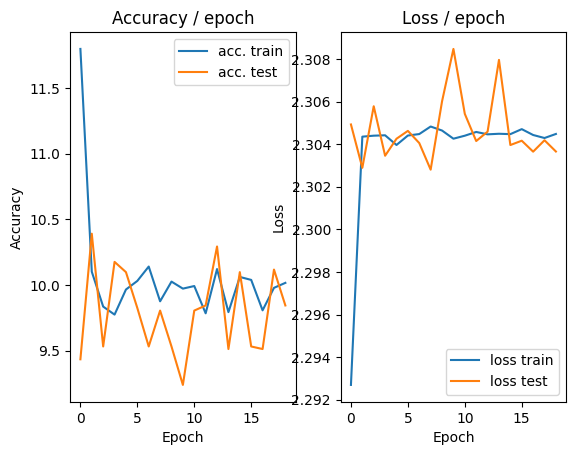

=== EPOCH 20 =====

[TRAIN Batch 000/352]	Time 0.348s (0.348s)	Loss 2.2997 (2.2997)	Prec@1  13.3 ( 13.3)	Prec@5  53.9 ( 53.9)


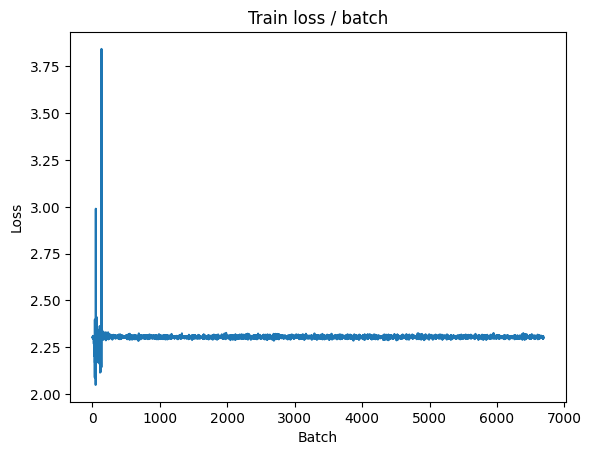

[TRAIN Batch 200/352]	Time 0.014s (0.027s)	Loss 2.3062 (2.3046)	Prec@1   6.2 (  9.7)	Prec@5  44.5 ( 49.7)


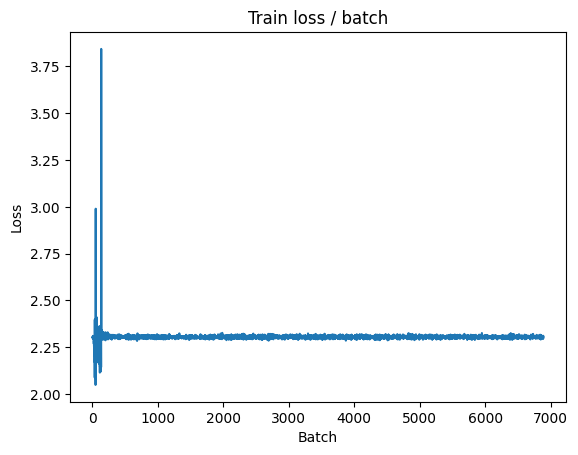


===============> Total time 9s	Avg loss 2.3045	Avg Prec@1  9.84 %	Avg Prec@5 49.83 %

[EVAL Batch 000/040]	Time 0.165s (0.165s)	Loss 2.3009 (2.3009)	Prec@1   7.8 (  7.8)	Prec@5  54.7 ( 54.7)

===============> Total time 0s	Avg loss 2.3033	Avg Prec@1  9.41 %	Avg Prec@5 49.22 %

[EVAL Batch 000/079]	Time 0.131s (0.131s)	Loss 2.3009 (2.3009)	Prec@1  13.3 ( 13.3)	Prec@5  54.7 ( 54.7)

===============> Total time 1s	Avg loss 2.3030	Avg Prec@1 10.10 %	Avg Prec@5 50.00 %



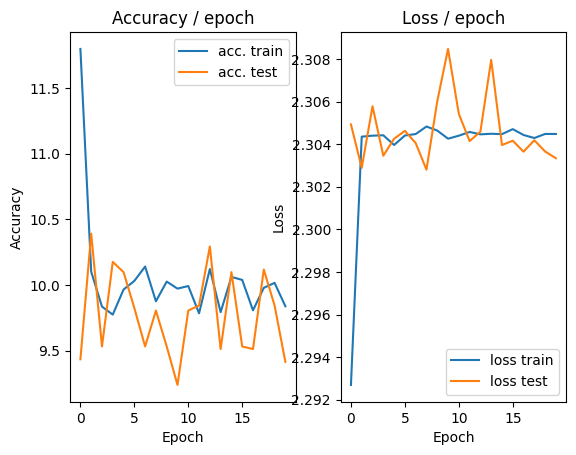

=== EPOCH 21 =====

[TRAIN Batch 000/352]	Time 0.345s (0.345s)	Loss 2.2982 (2.2982)	Prec@1  12.5 ( 12.5)	Prec@5  52.3 ( 52.3)


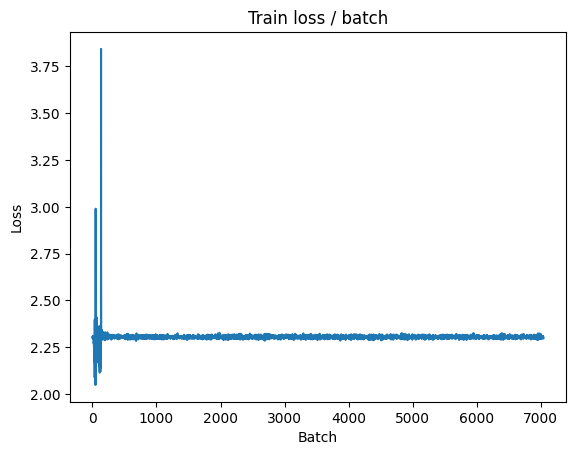

[TRAIN Batch 200/352]	Time 0.033s (0.031s)	Loss 2.2957 (2.3040)	Prec@1   9.4 ( 10.2)	Prec@5  58.6 ( 50.3)


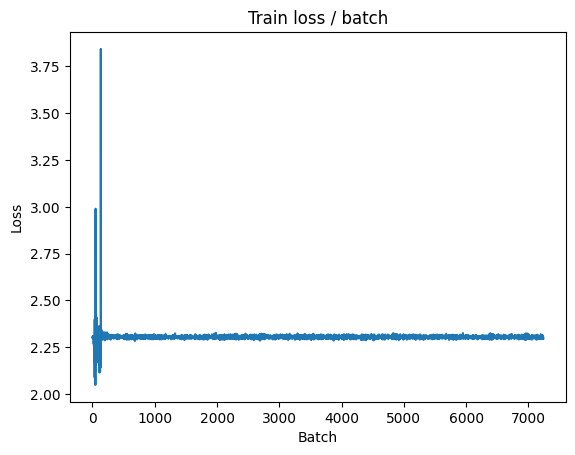


===============> Total time 9s	Avg loss 2.3041	Avg Prec@1 10.09 %	Avg Prec@5 50.09 %

[EVAL Batch 000/040]	Time 0.161s (0.161s)	Loss 2.3056 (2.3056)	Prec@1   9.4 (  9.4)	Prec@5  52.3 ( 52.3)

===============> Total time 0s	Avg loss 2.3031	Avg Prec@1 10.10 %	Avg Prec@5 51.91 %

[EVAL Batch 000/079]	Time 0.141s (0.141s)	Loss 2.3137 (2.3137)	Prec@1   8.6 (  8.6)	Prec@5  46.1 ( 46.1)

===============> Total time 1s	Avg loss 2.3040	Avg Prec@1  9.96 %	Avg Prec@5 50.14 %



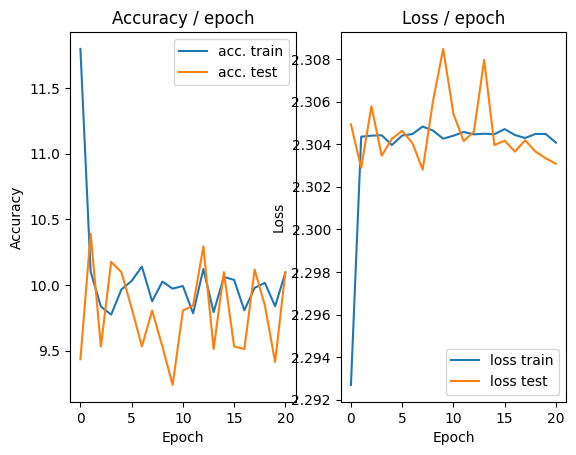

=== EPOCH 22 =====

[TRAIN Batch 000/352]	Time 0.285s (0.285s)	Loss 2.3049 (2.3049)	Prec@1  10.9 ( 10.9)	Prec@5  50.0 ( 50.0)


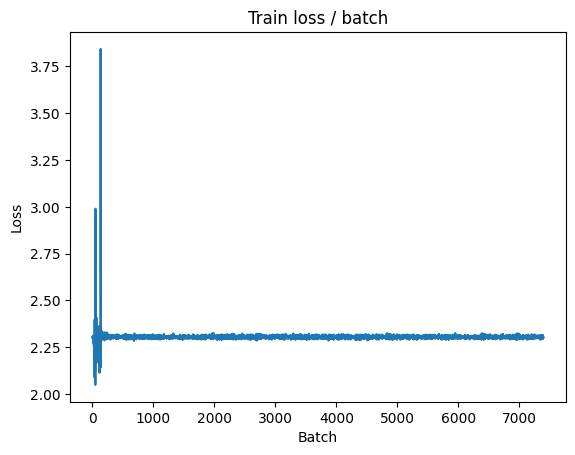

[TRAIN Batch 200/352]	Time 0.022s (0.033s)	Loss 2.2990 (2.3043)	Prec@1  14.8 ( 10.2)	Prec@5  53.1 ( 50.2)


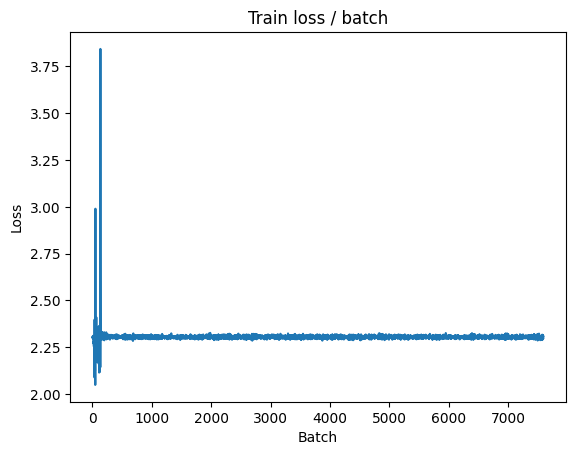


===============> Total time 10s	Avg loss 2.3044	Avg Prec@1 10.06 %	Avg Prec@5 50.04 %

[EVAL Batch 000/040]	Time 0.180s (0.180s)	Loss 2.2917 (2.2917)	Prec@1  14.1 ( 14.1)	Prec@5  60.2 ( 60.2)

===============> Total time 0s	Avg loss 2.3058	Avg Prec@1  9.41 %	Avg Prec@5 48.73 %

[EVAL Batch 000/079]	Time 0.151s (0.151s)	Loss 2.2972 (2.2972)	Prec@1  13.3 ( 13.3)	Prec@5  57.0 ( 57.0)

===============> Total time 1s	Avg loss 2.3042	Avg Prec@1 10.10 %	Avg Prec@5 50.07 %



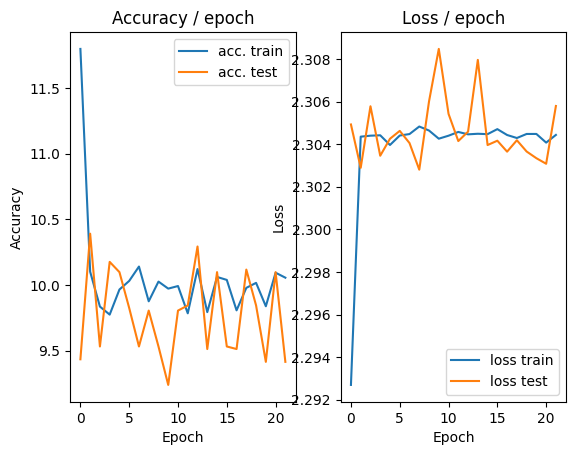

=== EPOCH 23 =====

[TRAIN Batch 000/352]	Time 0.265s (0.265s)	Loss 2.3057 (2.3057)	Prec@1   6.2 (  6.2)	Prec@5  52.3 ( 52.3)


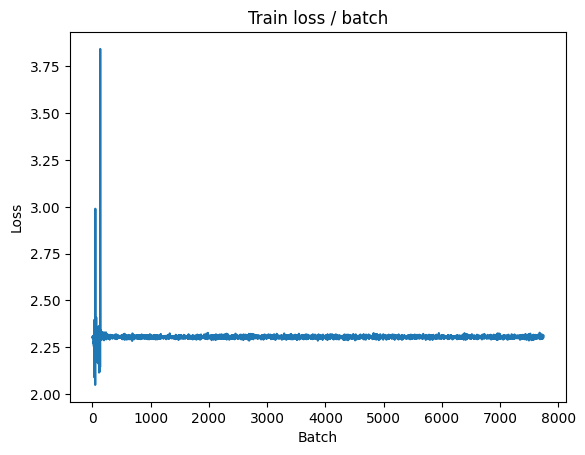

[TRAIN Batch 200/352]	Time 0.035s (0.032s)	Loss 2.3099 (2.3046)	Prec@1   7.0 (  9.8)	Prec@5  43.8 ( 49.9)


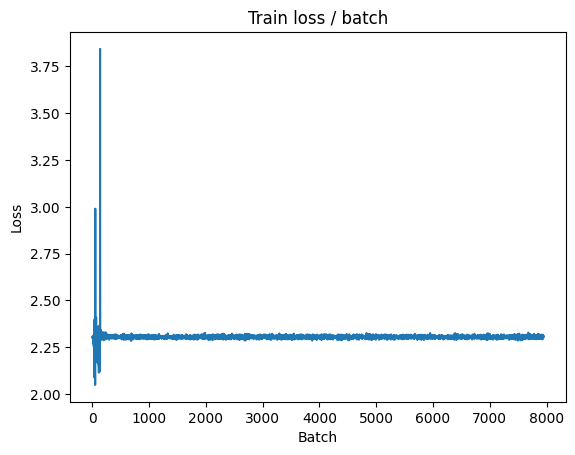


===============> Total time 10s	Avg loss 2.3045	Avg Prec@1  9.91 %	Avg Prec@5 49.82 %

[EVAL Batch 000/040]	Time 0.165s (0.165s)	Loss 2.3157 (2.3157)	Prec@1   7.0 (  7.0)	Prec@5  43.8 ( 43.8)

===============> Total time 0s	Avg loss 2.3076	Avg Prec@1  9.41 %	Avg Prec@5 48.44 %

[EVAL Batch 000/079]	Time 0.159s (0.159s)	Loss 2.2970 (2.2970)	Prec@1  13.3 ( 13.3)	Prec@5  54.7 ( 54.7)

===============> Total time 1s	Avg loss 2.3056	Avg Prec@1 10.10 %	Avg Prec@5 49.93 %



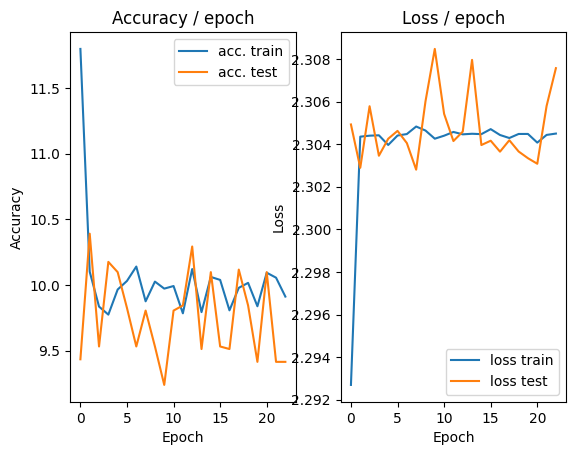

=== EPOCH 24 =====

[TRAIN Batch 000/352]	Time 0.790s (0.790s)	Loss 2.3077 (2.3077)	Prec@1  11.7 ( 11.7)	Prec@5  47.7 ( 47.7)


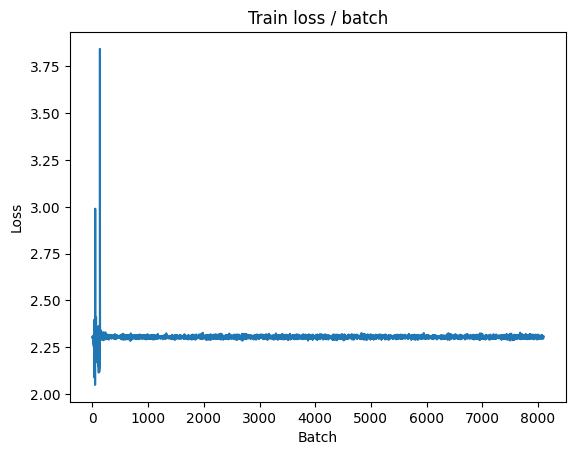

[TRAIN Batch 200/352]	Time 0.038s (0.045s)	Loss 2.3052 (2.3044)	Prec@1   7.8 (  9.8)	Prec@5  51.6 ( 49.9)


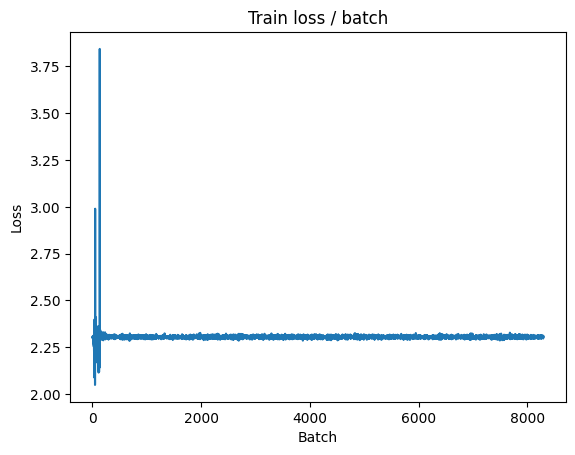


===============> Total time 13s	Avg loss 2.3043	Avg Prec@1  9.78 %	Avg Prec@5 49.89 %

[EVAL Batch 000/040]	Time 0.189s (0.189s)	Loss 2.3053 (2.3053)	Prec@1   7.8 (  7.8)	Prec@5  43.8 ( 43.8)

===============> Total time 0s	Avg loss 2.3063	Avg Prec@1  9.88 %	Avg Prec@5 49.32 %

[EVAL Batch 000/079]	Time 0.149s (0.149s)	Loss 2.2933 (2.2933)	Prec@1  14.8 ( 14.8)	Prec@5  57.0 ( 57.0)

===============> Total time 1s	Avg loss 2.3051	Avg Prec@1  9.89 %	Avg Prec@5 50.07 %



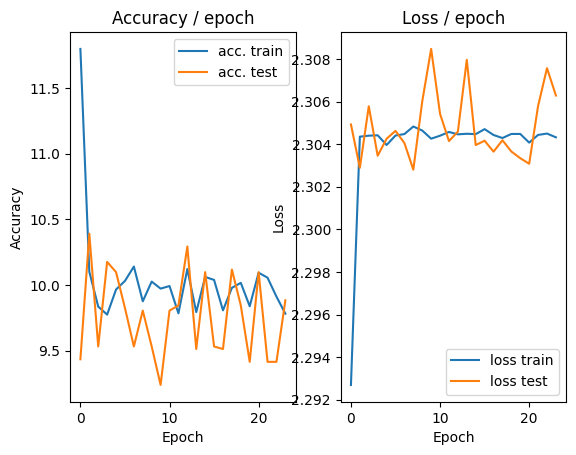

=== EPOCH 25 =====

[TRAIN Batch 000/352]	Time 0.282s (0.282s)	Loss 2.3039 (2.3039)	Prec@1  10.2 ( 10.2)	Prec@5  49.2 ( 49.2)


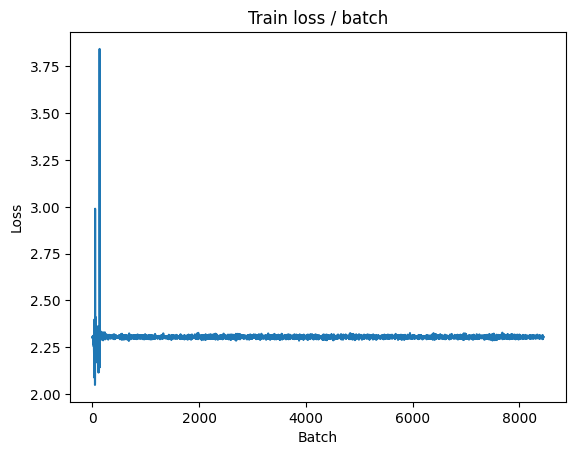

[TRAIN Batch 200/352]	Time 0.025s (0.033s)	Loss 2.3016 (2.3040)	Prec@1  14.1 ( 10.0)	Prec@5  51.6 ( 50.7)


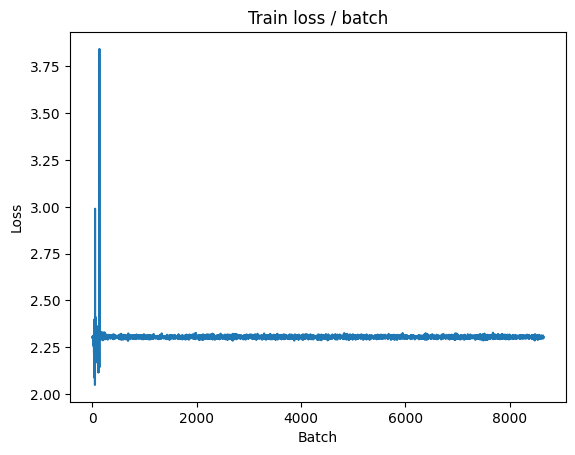


===============> Total time 10s	Avg loss 2.3042	Avg Prec@1  9.86 %	Avg Prec@5 50.41 %

[EVAL Batch 000/040]	Time 0.169s (0.169s)	Loss 2.2909 (2.2909)	Prec@1  15.6 ( 15.6)	Prec@5  50.8 ( 50.8)

===============> Total time 0s	Avg loss 2.3056	Avg Prec@1  9.80 %	Avg Prec@5 49.34 %

[EVAL Batch 000/079]	Time 0.155s (0.155s)	Loss 2.2978 (2.2978)	Prec@1  10.2 ( 10.2)	Prec@5  55.5 ( 55.5)

===============> Total time 1s	Avg loss 2.3050	Avg Prec@1 10.10 %	Avg Prec@5 49.93 %



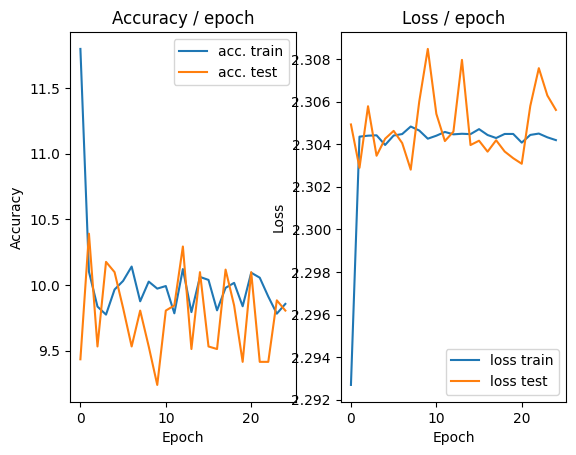

=== EPOCH 26 =====

[TRAIN Batch 000/352]	Time 0.536s (0.536s)	Loss 2.3025 (2.3025)	Prec@1  11.7 ( 11.7)	Prec@5  48.4 ( 48.4)


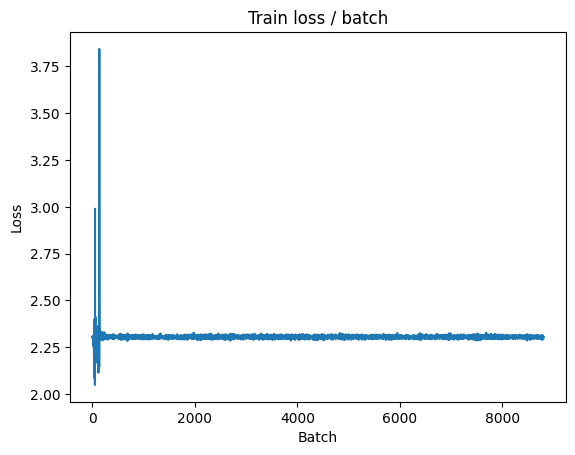

[TRAIN Batch 200/352]	Time 0.024s (0.034s)	Loss 2.3022 (2.3041)	Prec@1  11.7 (  9.9)	Prec@5  50.8 ( 50.4)


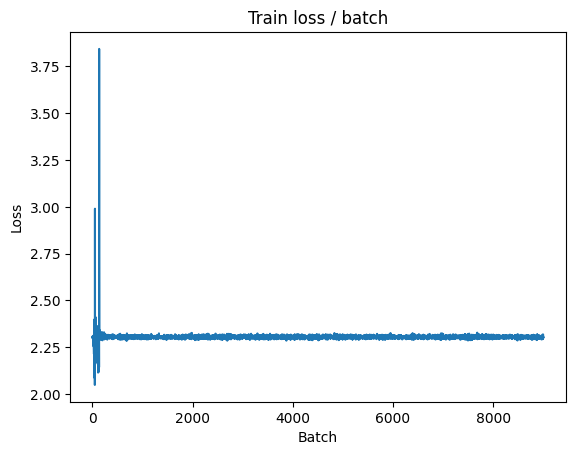


===============> Total time 10s	Avg loss 2.3042	Avg Prec@1  9.79 %	Avg Prec@5 50.12 %

[EVAL Batch 000/040]	Time 0.163s (0.163s)	Loss 2.3075 (2.3075)	Prec@1   8.6 (  8.6)	Prec@5  48.4 ( 48.4)

===============> Total time 0s	Avg loss 2.3027	Avg Prec@1 10.88 %	Avg Prec@5 50.08 %

[EVAL Batch 000/079]	Time 0.156s (0.156s)	Loss 2.3107 (2.3107)	Prec@1  11.7 ( 11.7)	Prec@5  44.5 ( 44.5)

===============> Total time 1s	Avg loss 2.3047	Avg Prec@1 10.10 %	Avg Prec@5 49.79 %



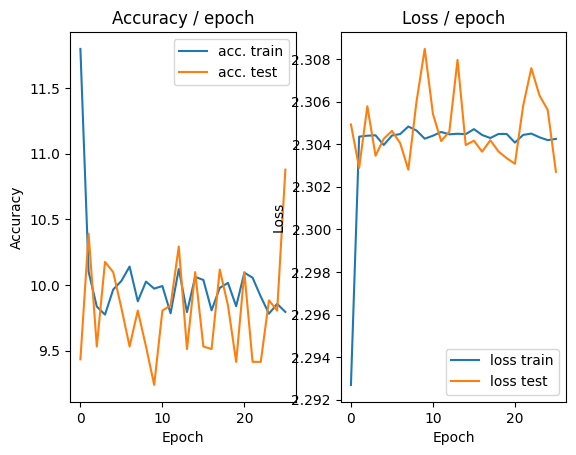

=== EPOCH 27 =====

[TRAIN Batch 000/352]	Time 0.250s (0.250s)	Loss 2.3163 (2.3163)	Prec@1   6.2 (  6.2)	Prec@5  43.8 ( 43.8)


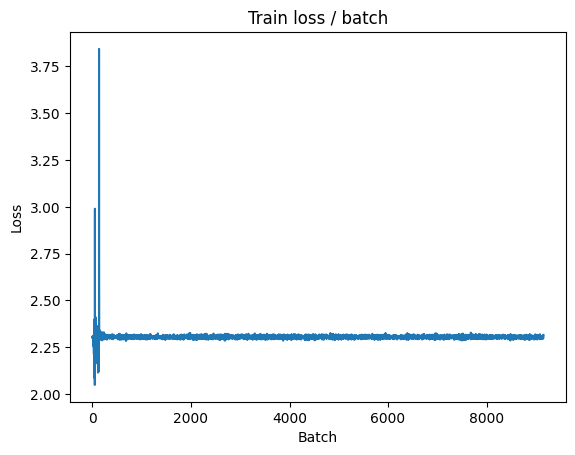

[TRAIN Batch 200/352]	Time 0.015s (0.033s)	Loss 2.3045 (2.3045)	Prec@1  10.2 (  9.8)	Prec@5  50.0 ( 50.0)


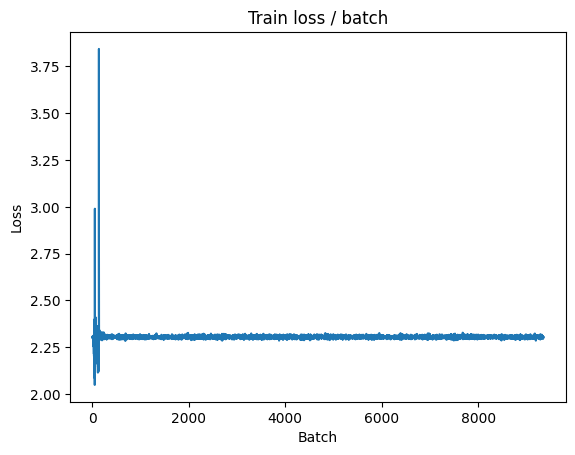


===============> Total time 10s	Avg loss 2.3044	Avg Prec@1 10.01 %	Avg Prec@5 50.01 %

[EVAL Batch 000/040]	Time 0.221s (0.221s)	Loss 2.3130 (2.3130)	Prec@1  10.2 ( 10.2)	Prec@5  45.3 ( 45.3)

===============> Total time 0s	Avg loss 2.3048	Avg Prec@1  9.82 %	Avg Prec@5 51.13 %

[EVAL Batch 000/079]	Time 0.153s (0.153s)	Loss 2.3027 (2.3027)	Prec@1  10.2 ( 10.2)	Prec@5  53.9 ( 53.9)

===============> Total time 1s	Avg loss 2.3051	Avg Prec@1 10.03 %	Avg Prec@5 50.00 %



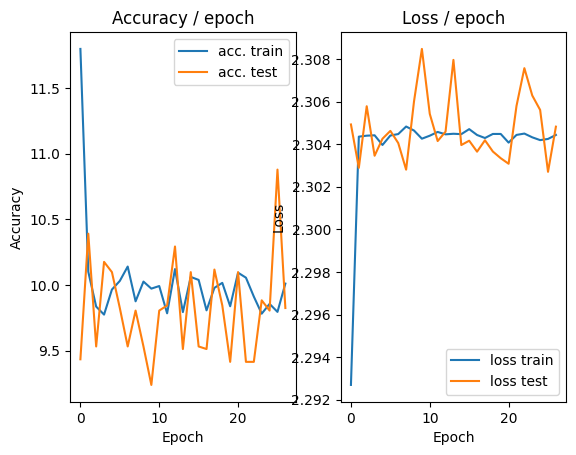

=== EPOCH 28 =====

[TRAIN Batch 000/352]	Time 0.522s (0.522s)	Loss 2.3112 (2.3112)	Prec@1   8.6 (  8.6)	Prec@5  42.2 ( 42.2)


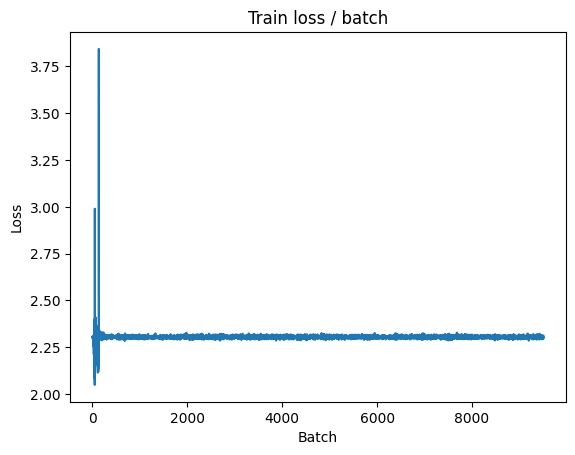

[TRAIN Batch 200/352]	Time 0.015s (0.033s)	Loss 2.3030 (2.3044)	Prec@1   7.8 ( 10.1)	Prec@5  50.8 ( 50.1)


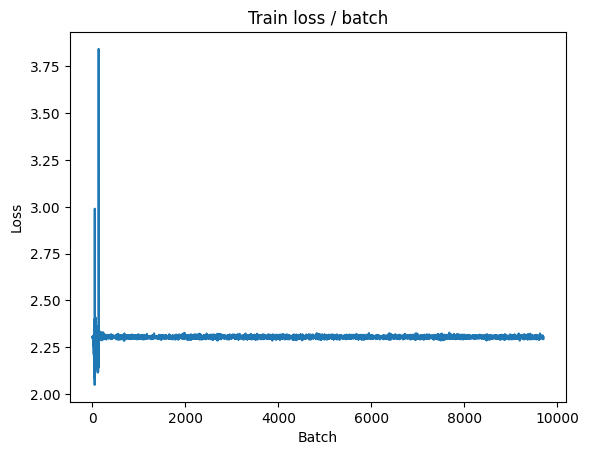


===============> Total time 10s	Avg loss 2.3045	Avg Prec@1  9.83 %	Avg Prec@5 49.76 %

[EVAL Batch 000/040]	Time 0.157s (0.157s)	Loss 2.3080 (2.3080)	Prec@1   6.2 (  6.2)	Prec@5  45.3 ( 45.3)

===============> Total time 0s	Avg loss 2.3041	Avg Prec@1  9.82 %	Avg Prec@5 49.00 %

[EVAL Batch 000/079]	Time 0.154s (0.154s)	Loss 2.3062 (2.3062)	Prec@1  10.2 ( 10.2)	Prec@5  46.9 ( 46.9)

===============> Total time 1s	Avg loss 2.3034	Avg Prec@1 10.03 %	Avg Prec@5 49.86 %



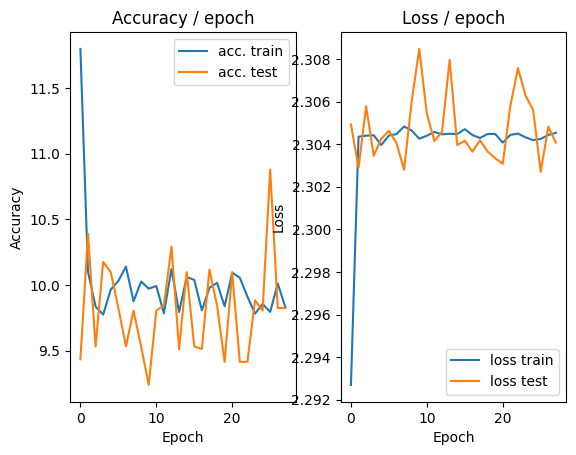

=== EPOCH 29 =====

[TRAIN Batch 000/352]	Time 0.274s (0.274s)	Loss 2.3101 (2.3101)	Prec@1   7.0 (  7.0)	Prec@5  44.5 ( 44.5)


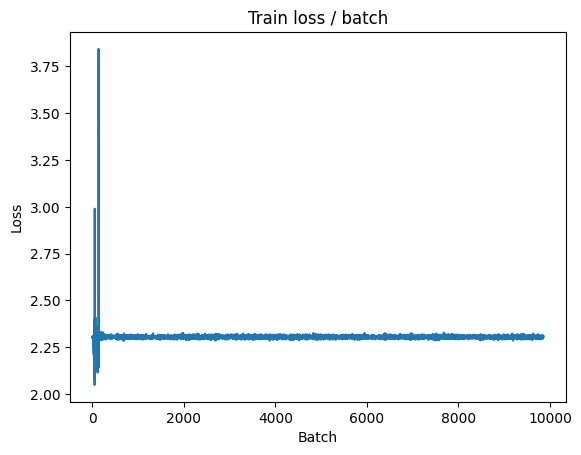

[TRAIN Batch 200/352]	Time 0.038s (0.028s)	Loss 2.2937 (2.3042)	Prec@1  14.1 ( 10.0)	Prec@5  53.9 ( 50.2)


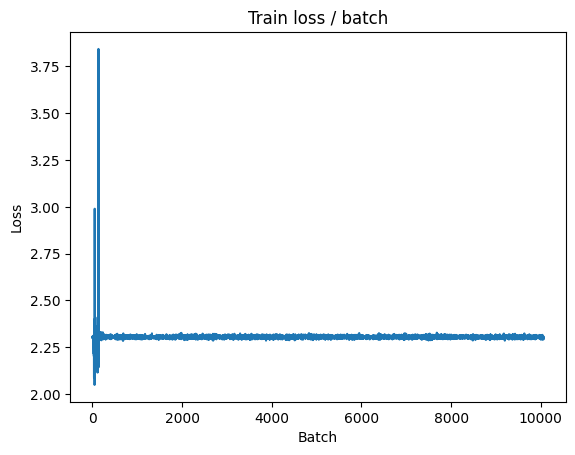


===============> Total time 10s	Avg loss 2.3043	Avg Prec@1 10.07 %	Avg Prec@5 50.04 %

[EVAL Batch 000/040]	Time 0.168s (0.168s)	Loss 2.3042 (2.3042)	Prec@1   7.8 (  7.8)	Prec@5  46.9 ( 46.9)

===============> Total time 0s	Avg loss 2.3043	Avg Prec@1 10.41 %	Avg Prec@5 49.65 %

[EVAL Batch 000/079]	Time 0.152s (0.152s)	Loss 2.3024 (2.3024)	Prec@1  10.2 ( 10.2)	Prec@5  55.5 ( 55.5)

===============> Total time 1s	Avg loss 2.3047	Avg Prec@1 10.03 %	Avg Prec@5 49.86 %



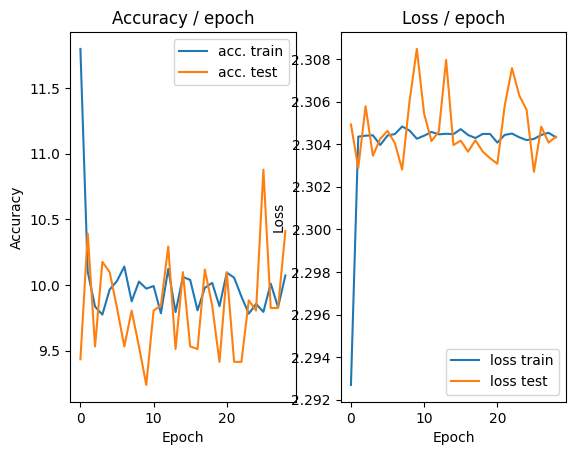

=== EPOCH 30 =====

[TRAIN Batch 000/352]	Time 0.272s (0.272s)	Loss 2.3037 (2.3037)	Prec@1   9.4 (  9.4)	Prec@5  50.0 ( 50.0)


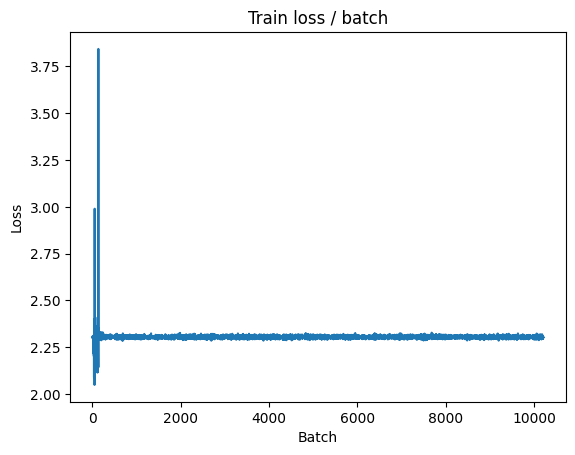

[TRAIN Batch 200/352]	Time 0.015s (0.025s)	Loss 2.3026 (2.3032)	Prec@1   8.6 ( 10.2)	Prec@5  53.1 ( 50.2)


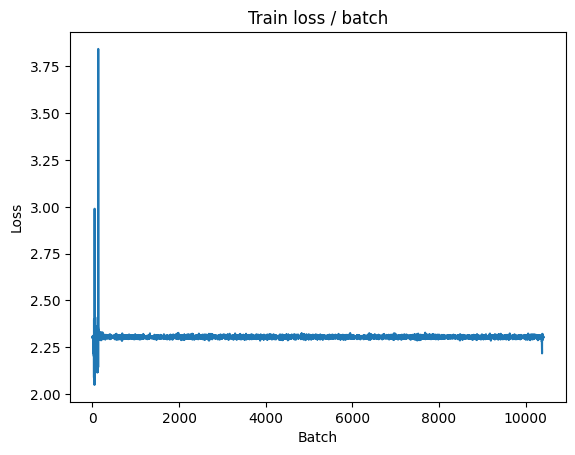


===============> Total time 10s	Avg loss 2.3037	Avg Prec@1  9.93 %	Avg Prec@5 50.24 %

[EVAL Batch 000/040]	Time 0.170s (0.170s)	Loss 2.3057 (2.3057)	Prec@1   9.4 (  9.4)	Prec@5  49.2 ( 49.2)

===============> Total time 0s	Avg loss 2.3068	Avg Prec@1  9.82 %	Avg Prec@5 49.00 %

[EVAL Batch 000/079]	Time 0.152s (0.152s)	Loss 2.3097 (2.3097)	Prec@1  10.2 ( 10.2)	Prec@5  45.3 ( 45.3)

===============> Total time 1s	Avg loss 2.3052	Avg Prec@1 10.03 %	Avg Prec@5 49.93 %



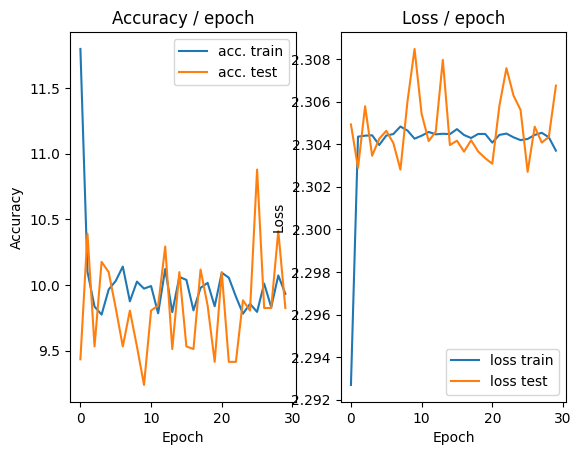

Final perfomance is <utils.AverageMeter object at 0x7d920f5ef940>


In [ ]:
main(128, 0.1, epochs=30, cuda=True)